In [1]:
#%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime
import osmnx as ox, geopandas as gpd, pandas as pd, networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
from IPython.display import Image
from descartes import PolygonPatch
from itertools import combinations, combinations_with_replacement
%matplotlib inline
ox.config(log_console=True, use_cache=True)
%config IPCompleter.greedy=True

import libpysal as lp

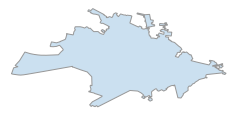

{'init': 'epsg:4326'}


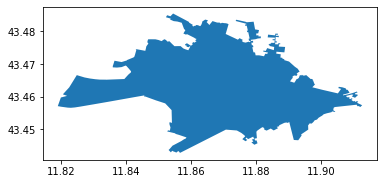

time: 351 ms


In [2]:
city = ox.gdf_from_place('Arezzo, Italy')
#city = ox.project_gdf(city)
fig, ax = ox.plot_shape(city, figsize=(4,4))
ox.save_gdf_shapefile(city)
crs = {'init': 'epsg:4326'}
city = city.to_crs(crs)
print(city.crs)
city.plot()

7612
data max index: 7611
number of NA prices: 10
average bedroom price 72.56627313420978
pointinpoly length: 217
check contains: True
check if there are NAs: False


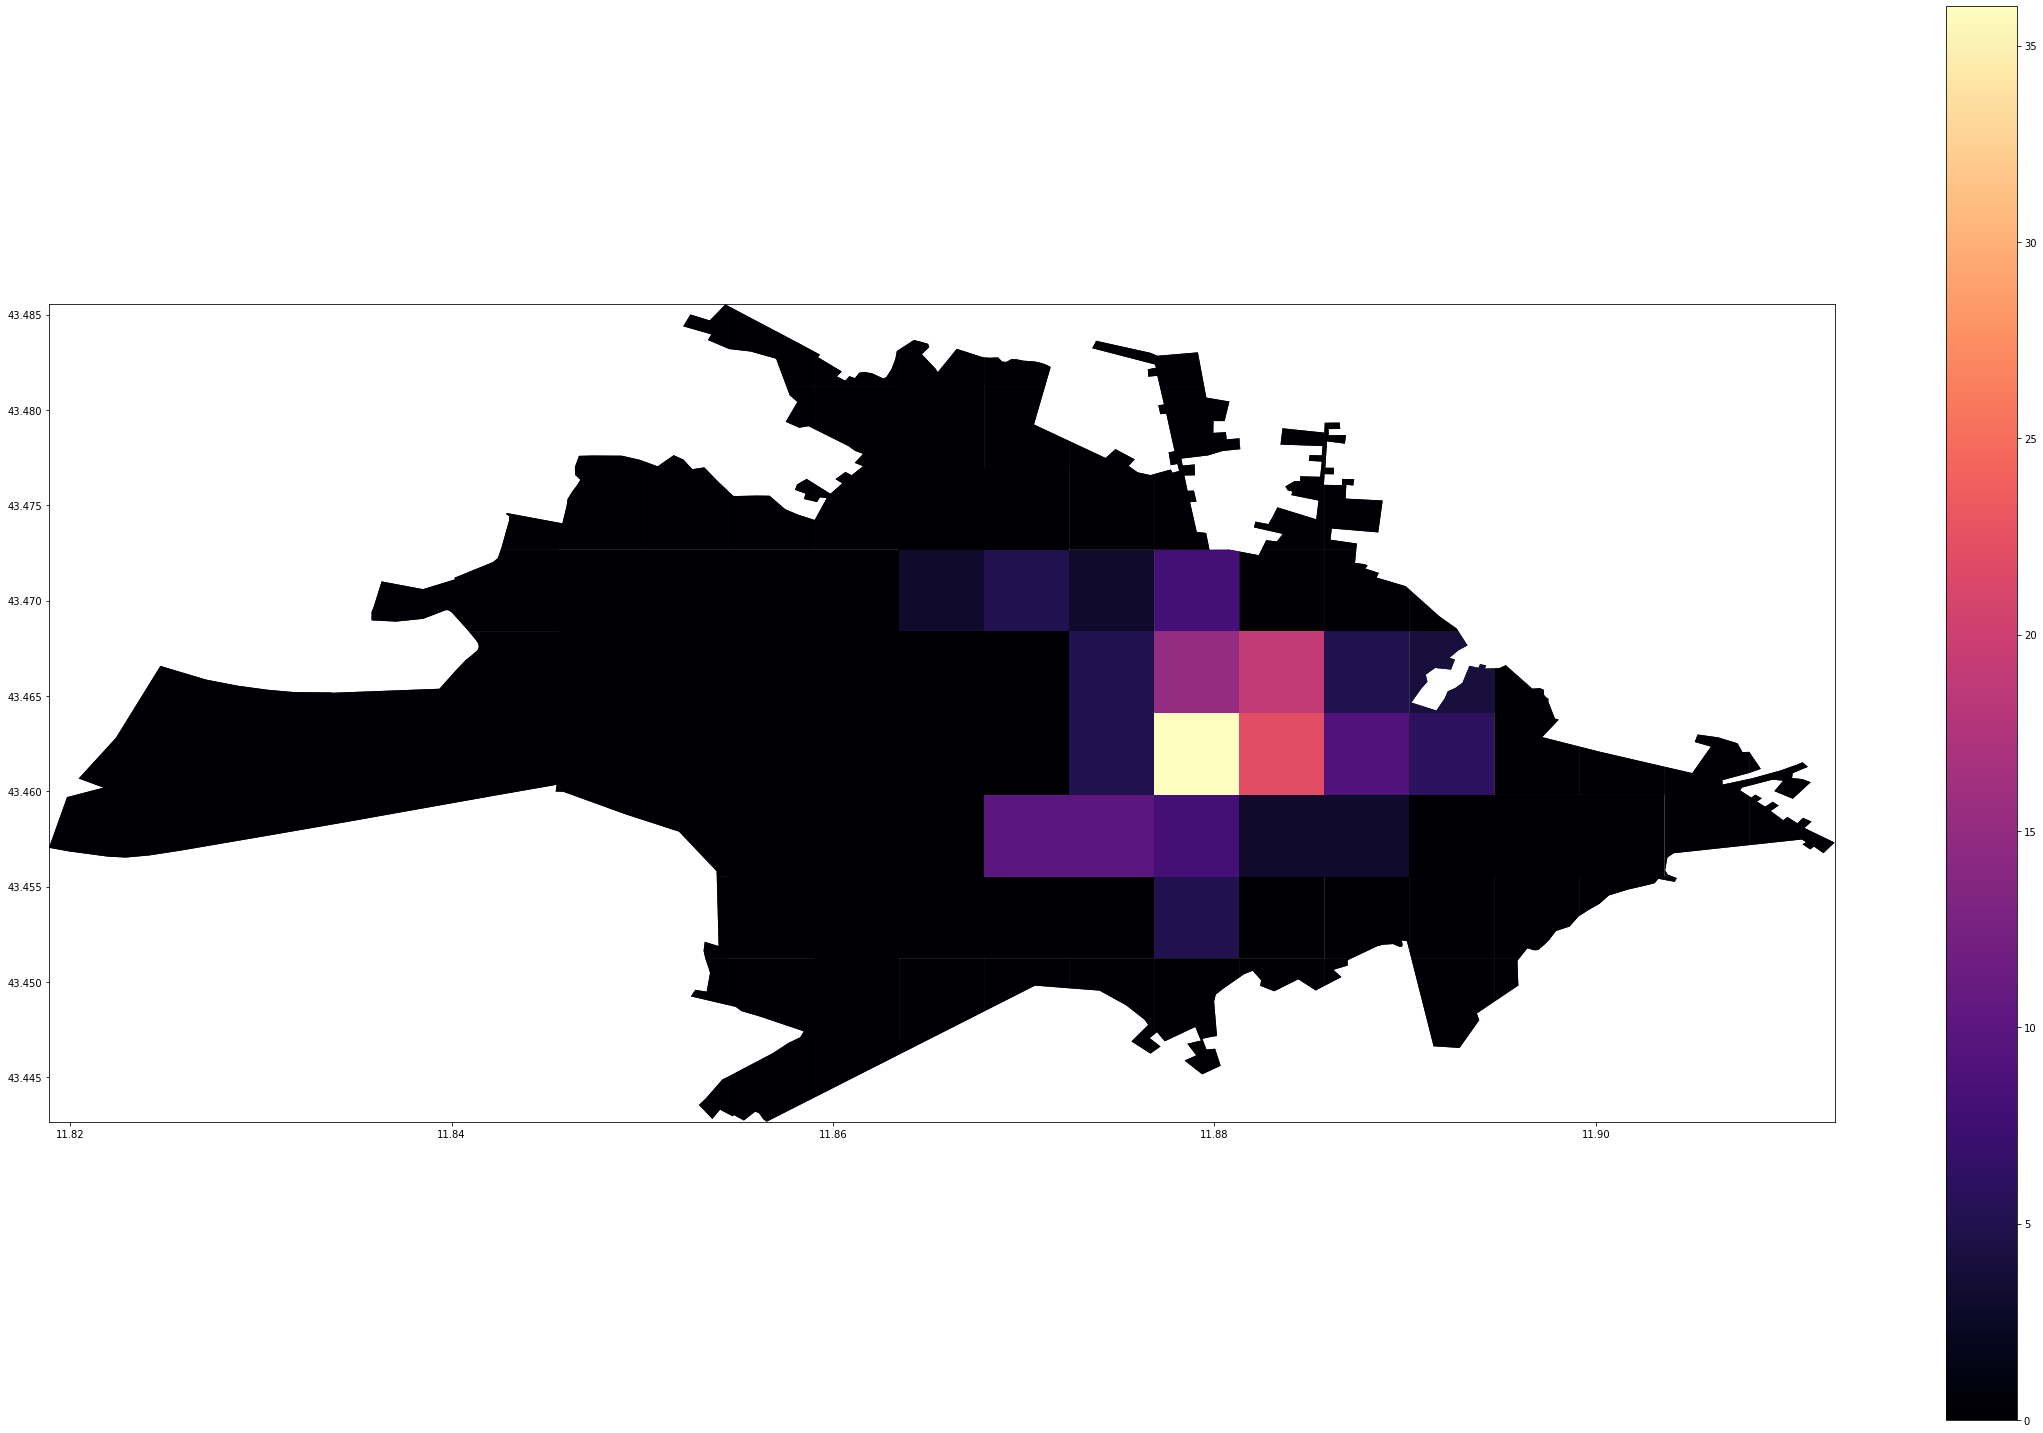

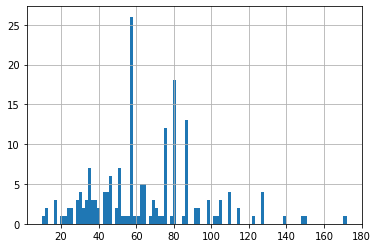

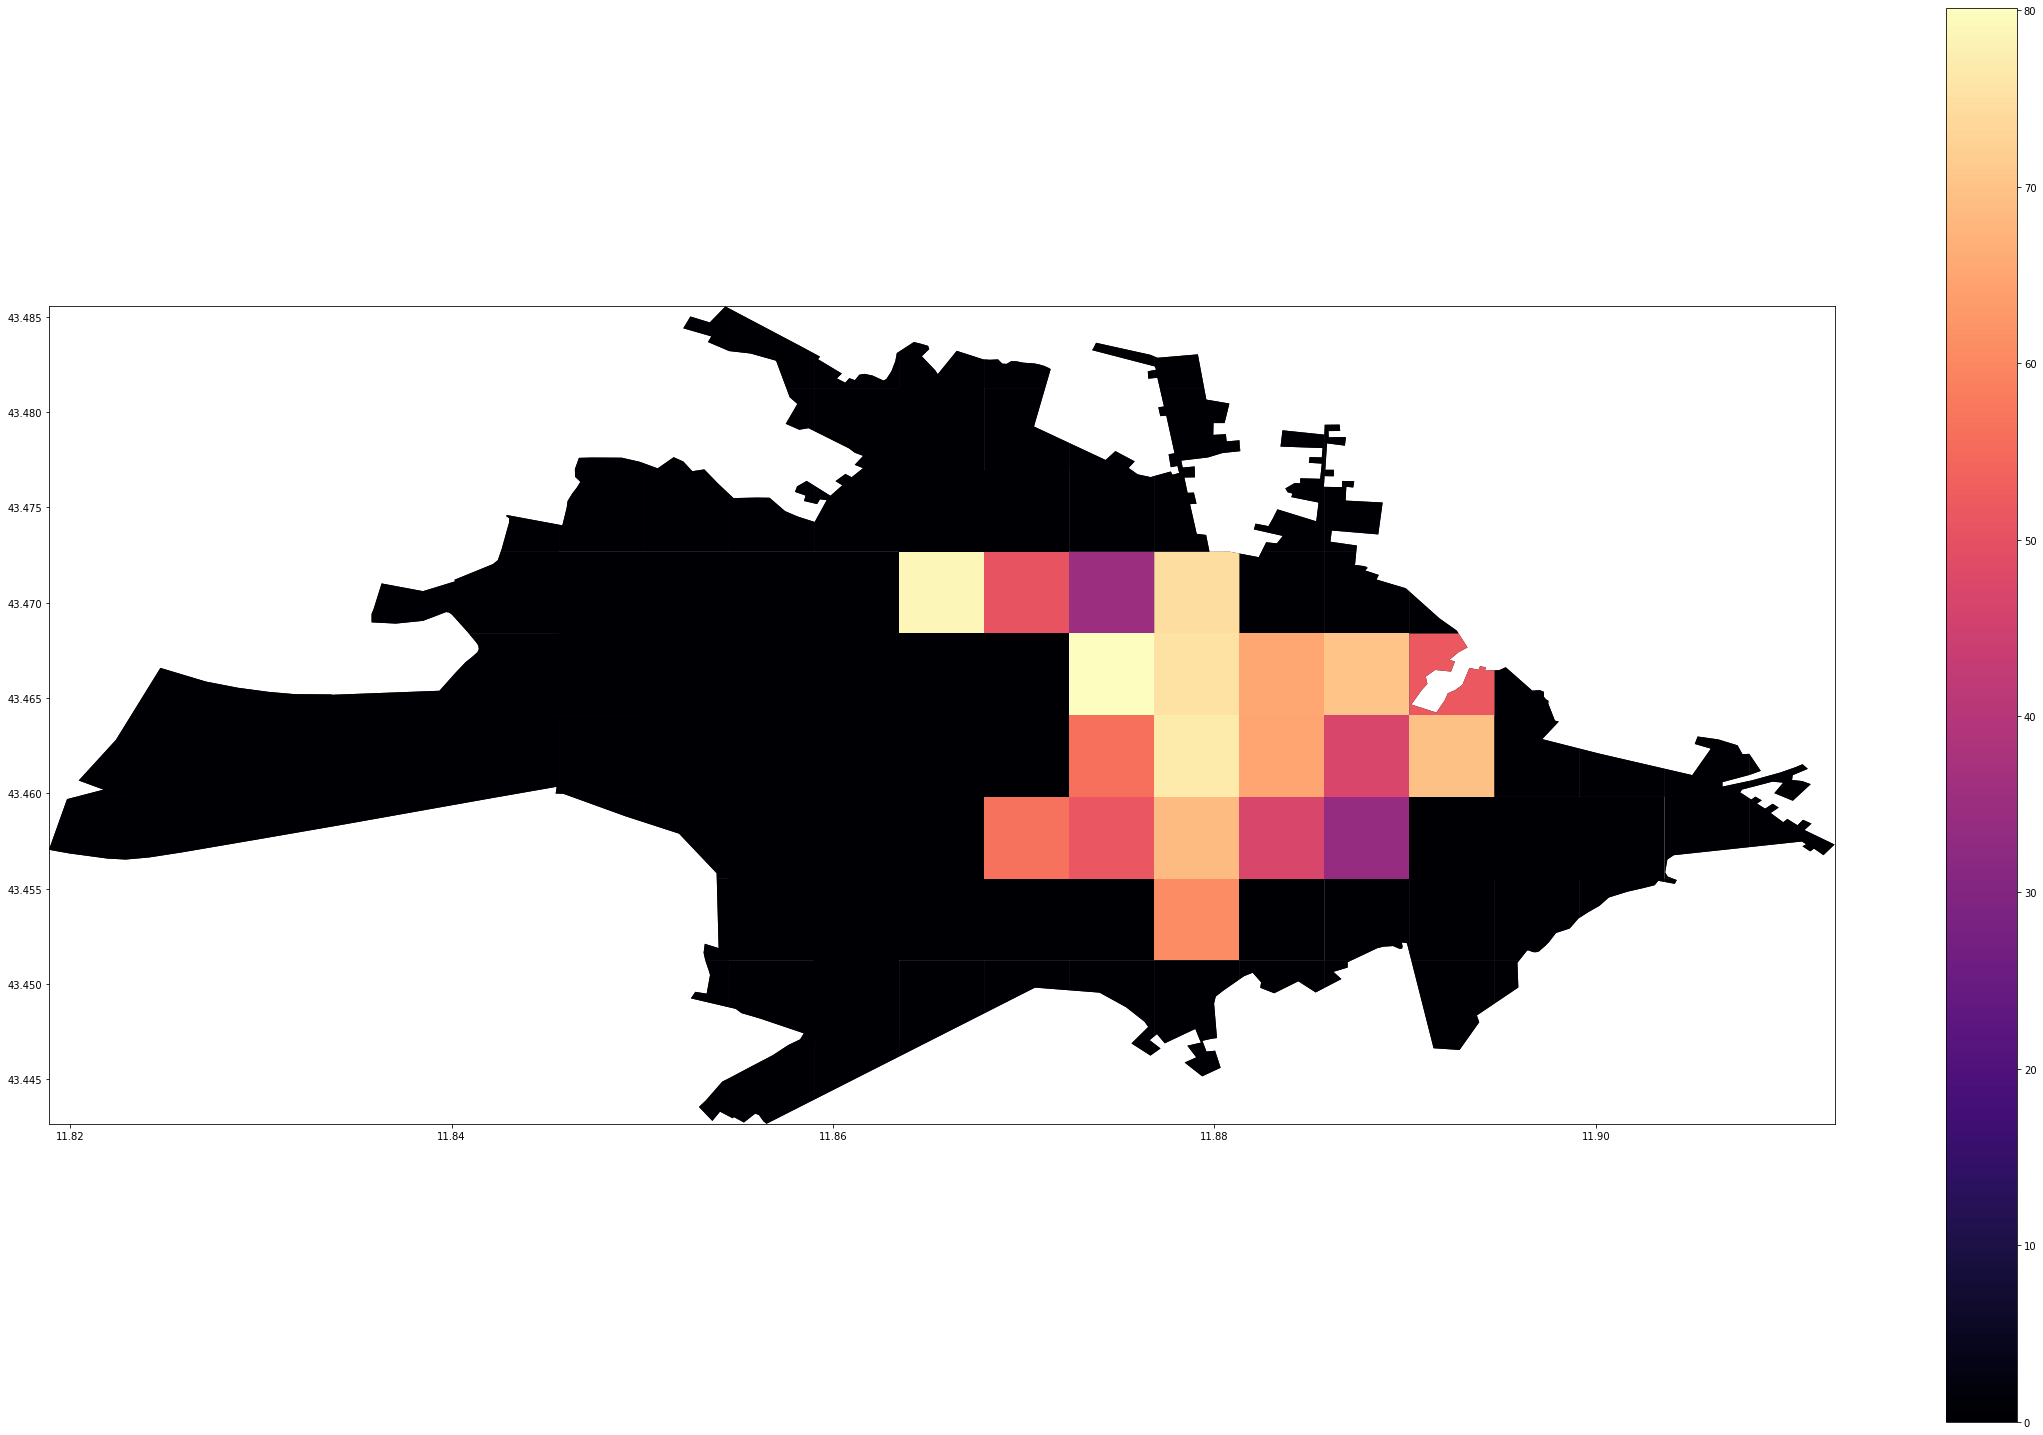

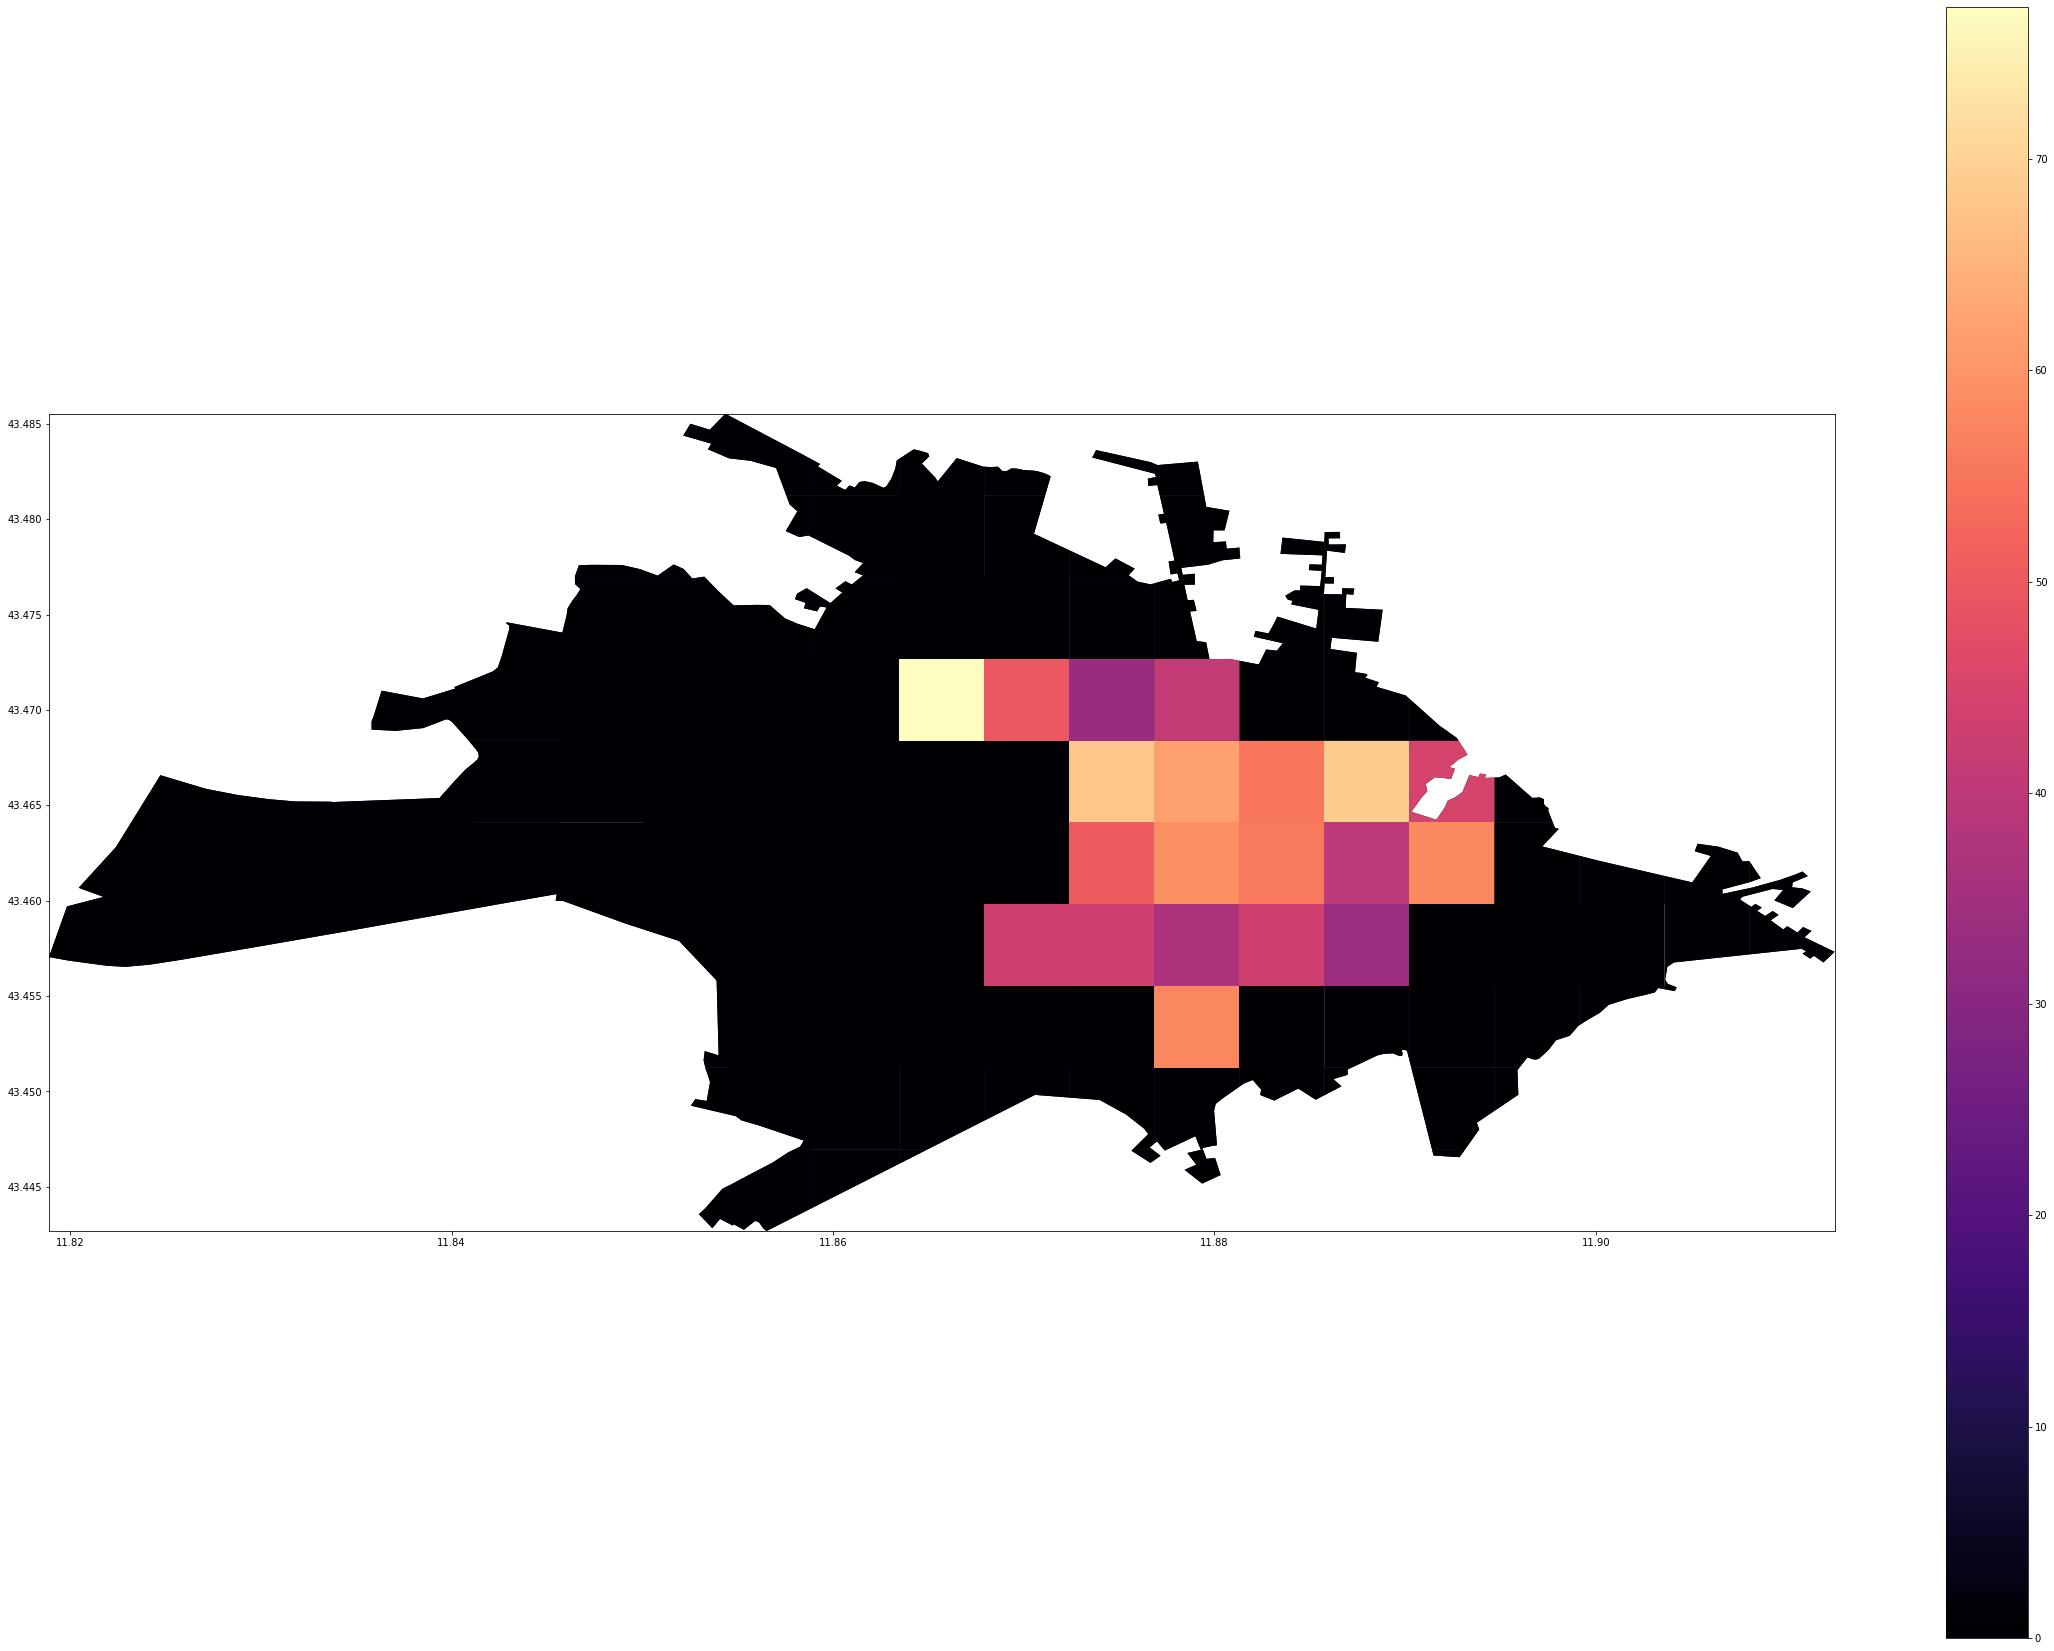

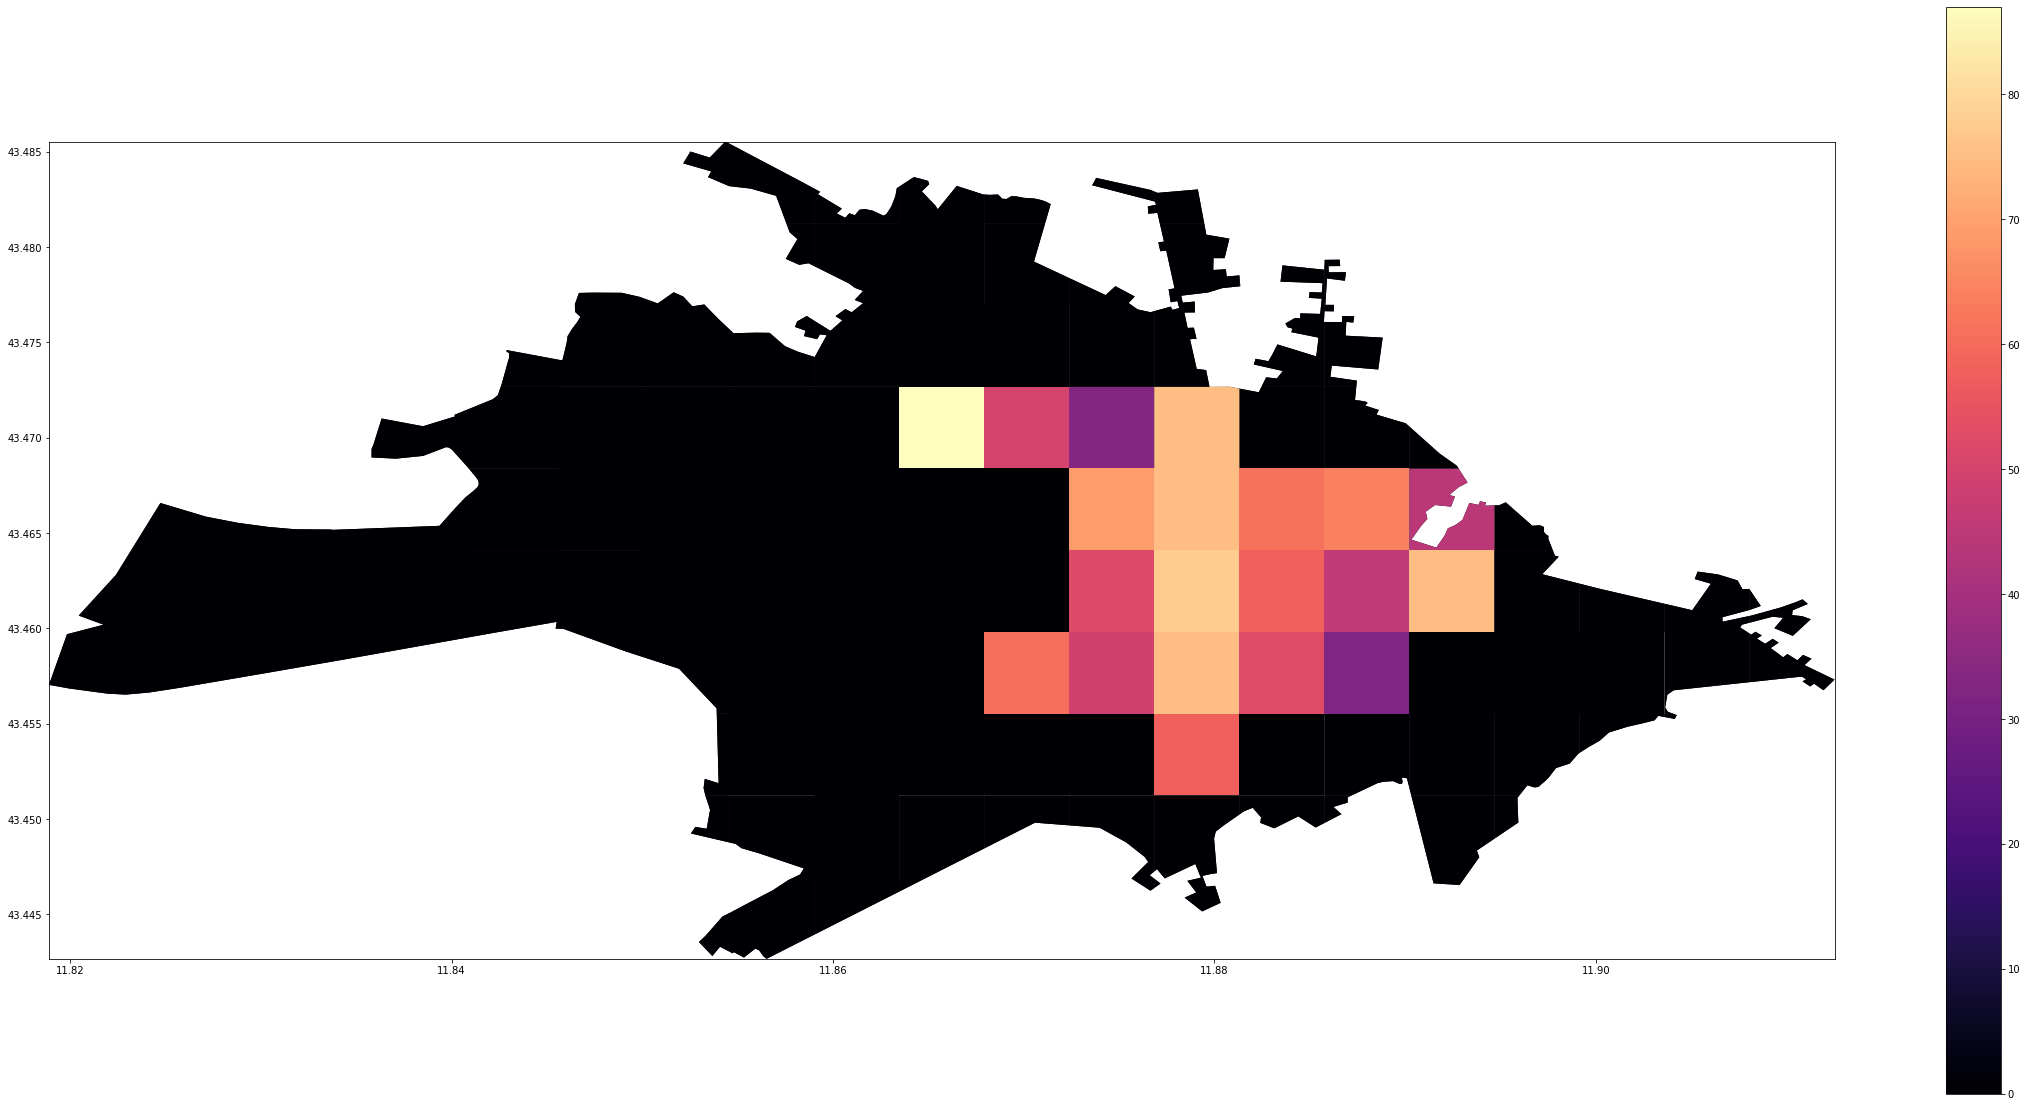

time: 4.98 s


In [3]:
data = pd.read_csv('data/Airbnb_Tuscany.csv', header=0, index_col=0)
data = data[['room_id','latitude', 'longitude', 'bedrooms', 'price']]
print(len(data))

data.reset_index(drop=True, inplace=True)
print("data max index:", data.index.max())
print("number of NA prices:", data.price.isna().sum())

data.loc[data.bedrooms == 0, 'bedrooms'] = 1

price_proom = np.divide(np.array(data[pd.notnull(data['bedrooms'])].price),np.array(data[pd.notnull(data['bedrooms'])].bedrooms))
mean_bed = np.mean(price_proom)
print("average bedroom price",mean_bed)

nan_list = data[data.bedrooms.isna()].index.tolist()
data.loc[data.bedrooms.isna(), 'bedrooms'] = np.ceil(data.loc[data.bedrooms.isna(), 'price']/mean_bed)

geometry = [Point(xy) for xy in zip(data.longitude, data.latitude)]
#data = data.drop(['longitude', 'latitude'], axis=1)
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(data, crs=crs, geometry=geometry)

meter_500 = 0.00899928/2


# make the geometry a multipolygon if it's not already
geometry = city['geometry'].iloc[0]
if isinstance(geometry, Polygon):
    geometry = MultiPolygon([geometry])
    
# quadrat_width is in the units the geometry is in, so we'll do a tenth of a degree
geometry_cut = ox.quadrat_cut_geometry(geometry, quadrat_width=meter_500)

city['coords'] = city['geometry'].apply(lambda x: x.representative_point().coords[:])
city['coords'] = [coords[0] for coords in city['coords']]

polylist = [p for p in geometry_cut]


polyframe = gpd.GeoDataFrame(geometry=polylist)
polyframe.crs = city.geometry.crs
polyframe['center_lon'] = polyframe['geometry'].apply(lambda x: x.centroid.coords[0][0])
polyframe['center_lat'] = polyframe['geometry'].apply(lambda x: x.centroid.coords[0][1])


pointInPoly = gpd.sjoin(polyframe, gdf, op='contains')
print("pointinpoly length:",len(pointInPoly))

#pointInPoly.sort_values(['PlateID', 'Time'], inplace=True)
pointInPoly['index'] = pointInPoly.index
pointInPoly.reset_index(drop=True, inplace=True)


present_ind = list(pointInPoly['index_right'])
gdf_test_dropped = gdf.iloc[present_ind,:]
gdf_dropped = gdf_test_dropped.copy()
gdf_dropped.reset_index(drop=True, inplace=True)

print("check contains:",polyframe.iloc[pointInPoly.loc[len(pointInPoly)-1, 'index']].geometry.contains(gdf_dropped.loc[len(pointInPoly)-1,'geometry']))
gdf_dropped['pindex'] = pointInPoly['index']

print("check if there are NAs:", gdf_dropped.isna().values.any())

pindex = gdf_dropped.pindex.unique()
airbnb_dict = dict(gdf_dropped.pindex.value_counts())
counts = pd.DataFrame(list(airbnb_dict.items()), columns=['key', 'count'])
counts = counts[counts['count']>2]
counts = counts.copy()
airbnb_dict = dict(zip(list(counts['key']), list(counts['count'])))
polyair = polyframe.copy()
polyair['count'] = 0
polyair['count'].update(pd.Series(airbnb_dict))

# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='count',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


gdf_dropped = gdf_dropped[gdf_dropped.pindex.isin(airbnb_dict.keys())]
gdf_dropped = gdf_dropped.copy()
gdf_dropped = gdf_dropped[gdf_dropped['price'] > 0]
gdf_dropped = gdf_dropped.copy()
gdf_dropped['price_normalized'] = gdf_dropped.price.divide(gdf_dropped.bedrooms)
gdf_dropped = gdf_dropped[gdf_dropped.price_normalized<270]
gdf_dropped = gdf_dropped.copy()
gdf_dropped.reset_index(drop=True, inplace=True)
gdf_dropped.price_normalized.hist(bins=100)

prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].mean())
from scipy import stats
hmean_prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].apply(lambda x: stats.hmean(x)))
median_prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].median())

polyair['prices'] = 0
polyair['hmean_prices'] = 0
polyair['median_prices'] = 0
polyair['prices'].update(pd.Series(prices_dict))
polyair['hmean_prices'].update(pd.Series(hmean_prices_dict))
polyair['median_prices'].update(pd.Series(median_prices_dict))


# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()



# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,30))

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='hmean_prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,20))

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='median_prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


In [4]:
polyair.loc[polyair.index==108, 'median_prices'] = 60
polyair.loc[polyair.index==108, 'hmean_prices'] = 59
polyair.loc[polyair.index==108, 'prices'] = 63
polyair.loc[polyair.index==123, 'median_prices'] = 36
polyair.loc[polyair.index==123, 'hmean_prices'] = 34
polyair.loc[polyair.index==123, 'prices'] = 40

time: 9 ms


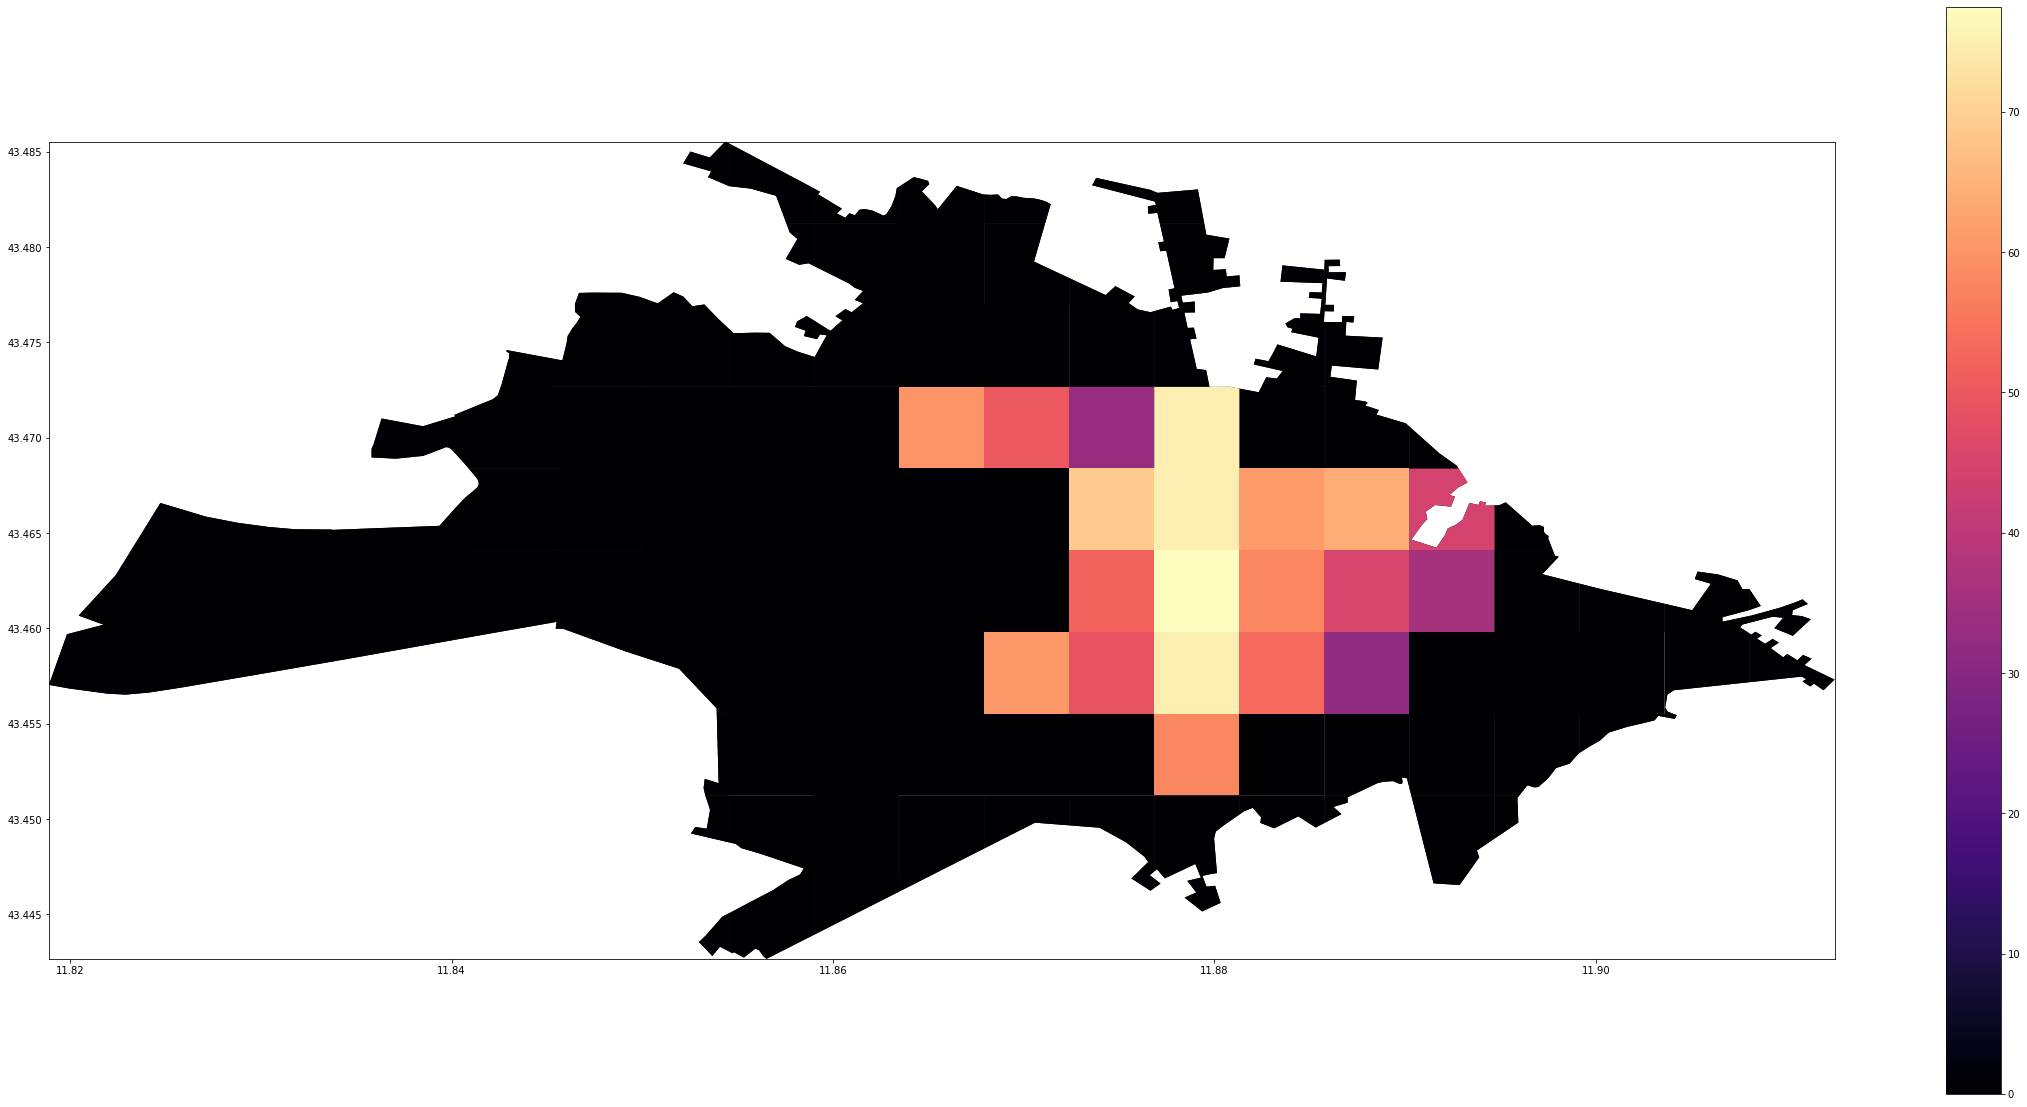

time: 887 ms


In [5]:
# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,20))
# for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
#     p = polygon.representative_point().coords[:][0]
#     patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', zorder=2)
#     ax.add_patch(patch)
#     plt.annotate(s=n, xy=p,
#                  horizontalalignment='center', size=7)

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='median_prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

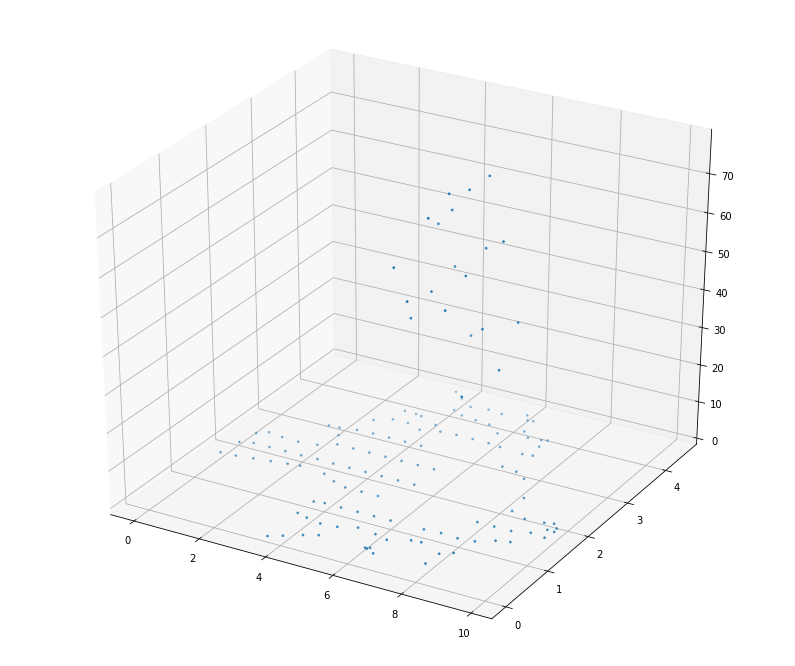

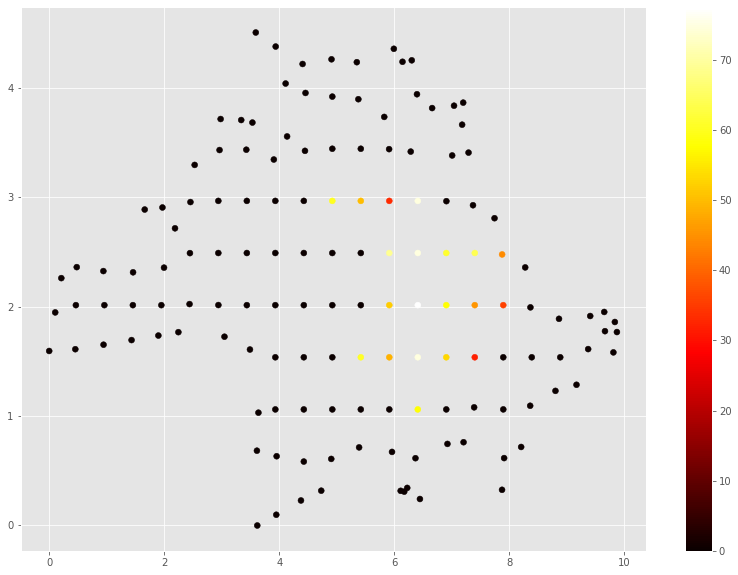

time: 1.59 s


In [6]:
import plotly.plotly as py
import plotly.graph_objs as go

# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab
from mpl_toolkits.mplot3d import Axes3D
#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)

x = np.array(polyair.center_lon)*500/meter_500
x = x-x.min()
x = x/1000

y = np.array(polyair.center_lat)*500/meter_500 
y = y-y.min()
y = y/1000


# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, np.array(polyair.median_prices), cmap='plasma', s=3)
ax.set_zlim(0,np.max(np.array(polyair.median_prices))+2)
ax.view_init(30, 300)
plt.show()


plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(14,10))
scat = ax.scatter(x, y, c=np.array(polyair.median_prices), s=35, cmap='hot')
cbar = fig.colorbar(scat)
#cbar.set_clim(0, 250)
plt.savefig('images/Arezzo_observed.jpg')
plt.show()

In [7]:
cdf = polyair[polyair.median_prices == polyair.median_prices.max()]
cdf["cen_lon_km"] = cdf['center_lon'].apply(lambda x: (x*500/meter_500 - (polyair.center_lon*500/meter_500).min())/1000)
cdf["cen_lat_km"] = cdf['center_lat'].apply(lambda x: (x*500/meter_500 - (polyair.center_lat*500/meter_500).min())/1000)
cdf

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



geometry  center_lon  \
119  POLYGON ((11.87684712381402 43.4641000999955, ...   11.879076   

     center_lat  count     prices  hmean_prices  median_prices  cen_lon_km  \
119   43.461957     36  76.895833     59.140998           77.5    6.408968   

     cen_lat_km  
119    2.012637

time: 173 ms


Fitted parameters:
[72.86391961  6.52325279  2.11379899  0.86750145  0.71992781  3.25337994
  1.52913307]
RMS residual = 10.686421402915856


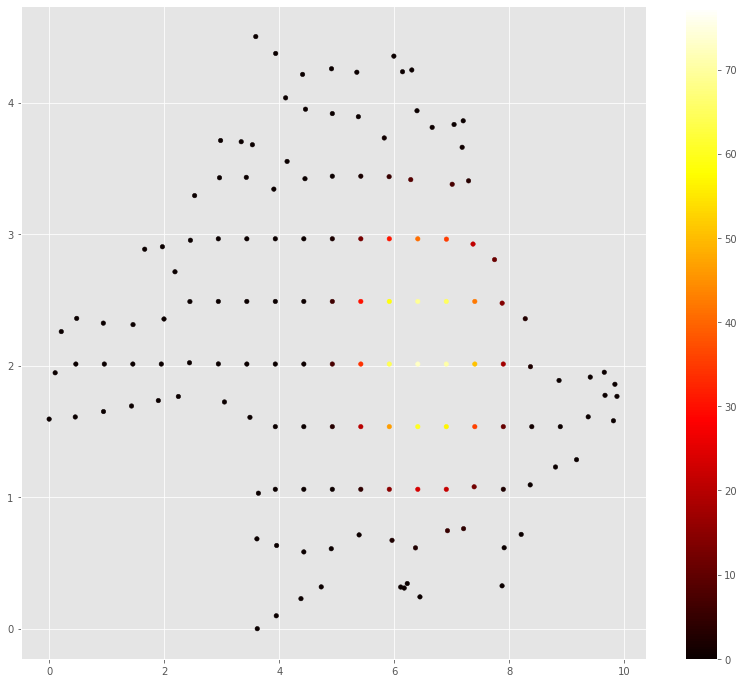

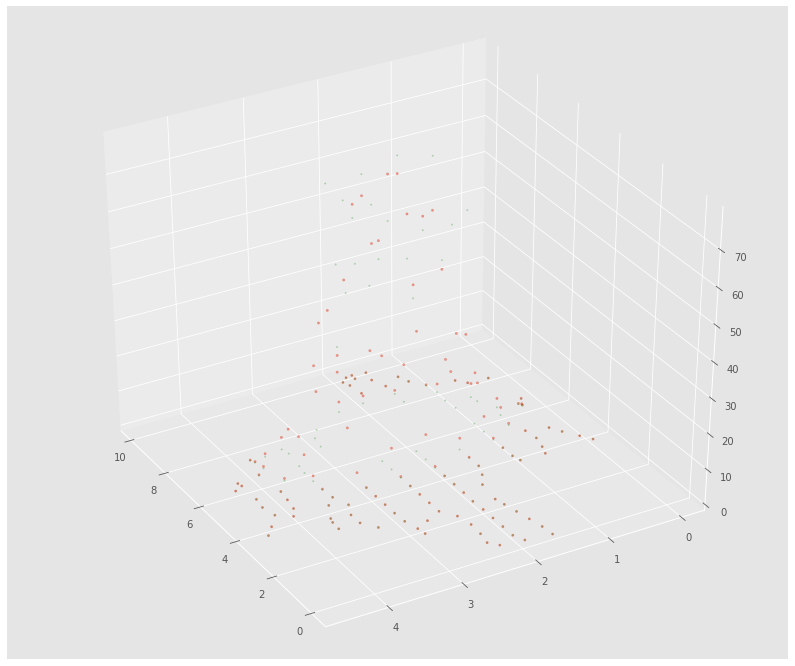

{'Arezzo': 1.5291330654483044}
time: 741 ms


In [8]:
alphas = {}
xy = np.vstack([x, y])
zobs = np.array(polyair.median_prices)
#zobs = np.where(zobs>0, zobs, 0.1*zobs.max())
import scipy.optimize as opt
import matplotlib.pyplot as plt

def _gaussian(M, *args):
    xy = M
    arr = np.zeros(len(zobs))
    for i in range(len(args)//7):
        arr += twoD_Gaussian_alpha(xy, *args[i*7:i*7+7])
    return arr

guess_prms = [(77.5,6.408968, 2.012637, 2, 0.3,3, 1.5)
             ]
# Flatten the initial guess parameter list.
p0 = [p for prms in guess_prms for p in prms]

def twoD_Gaussian_alpha(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, alpha):
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2))**alpha)
    return g.ravel()
popt, pcov = opt.curve_fit(_gaussian, xy, zobs, p0)
#pred_params, uncert_cov = opt.curve_fit(gauss2d, xy, zobs, p0=guess)

zpred = np.zeros(len(zobs))
for i in range(len(popt)//7):
    zpred += twoD_Gaussian_alpha(xy, *popt[i*7:i*7+7])

# for i in range(len(popt)//5):
#     fit += gaussian(X, Y, *popt[i*5:i*5+5])
print('Fitted parameters:')
print(popt)

rms = np.sqrt(np.mean((zobs - zpred)**2))
print('RMS residual =', rms)


fig, ax = plt.subplots(figsize=(14,12))
scat = ax.scatter(x, y, c=zpred, vmin=0, vmax=zobs.max(), s=20, cmap='hot')
fig.colorbar(scat)
plt.savefig('Arezzo_fitted.jpg')
plt.show()


#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)
# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, zpred, cmap='plasma', s=5, alpha=0.5)
ax.scatter(x, y, zobs, color='green', s=2, alpha=0.2)
ax.set_zlim(0,np.max(np.array(polyair.median_prices))+2)
ax.view_init(35, 150)
plt.show()

alphas['Arezzo'] = np.mean(popt[6::7])
print(alphas)

In [9]:
import pickle
pickle_in = open("alphas.pickle","rb")
alphas_dict = pickle.load(pickle_in)
#prices_params_dict = {}
alphas_dict['Arezzo'] = alphas['Arezzo']
print(alphas_dict)
pickle_out = open("alphas.pickle","wb")
pickle.dump(alphas_dict, pickle_out)
pickle_out.close()

{'Paris': 1.9119263949210794, 'Amsterdam': 1.6077156181165682, 'Stockholm': 1.4869621148124246, 'Arezzo': 1.5291330654483044, 'Berlin': 1.3281036059479567, 'Bordeaux': 1.387341915093677, 'Denver': 0.9886695315944182, 'Edinburgh': 1.7431661910906637, 'Lyon': 1.840995035260712, 'Madrid': 1.561423826026336, 'Buenos_Aires': 2.0626361633770363, 'Los_Angeles': 1.7386638625850566, 'Beijing': 1.77233254047711, 'Florence': 1.052999973906332, 'Moscow': 1.822610958759147, 'Porto': 1.4172416677632145, 'Prague': 1.3671832768992007, 'Reykjavik': 1.4194582940670377, 'Riga': 1.4587192546215861, 'Rome': 1.8608390724186512, 'Seoul': 1.3208669147673713, 'Siena': 0.6212787996336754, 'Sydney': 2.584174464016137, 'Tallin': 2.014994948135572, 'Treviso': 1.07320426583068, 'Valencia': 1.5432619, 'Venezia': 1.3156028460923, 'Verona': 1.4364606330705336, 'Vicenza': 1.20971848439062, 'Vienna': 1.3399164167136137, 'Wellington': 1.46363348, 'Zurich': 1.72383878, 'Aarhus': 1.87621535, 'Milan': 2.1468310347956194, 'B

Fitted parameters:
[86.02745782  6.49932413  2.13395715  0.78033872  0.64915283  3.3792082 ]
RMS residual = 10.862959537371538


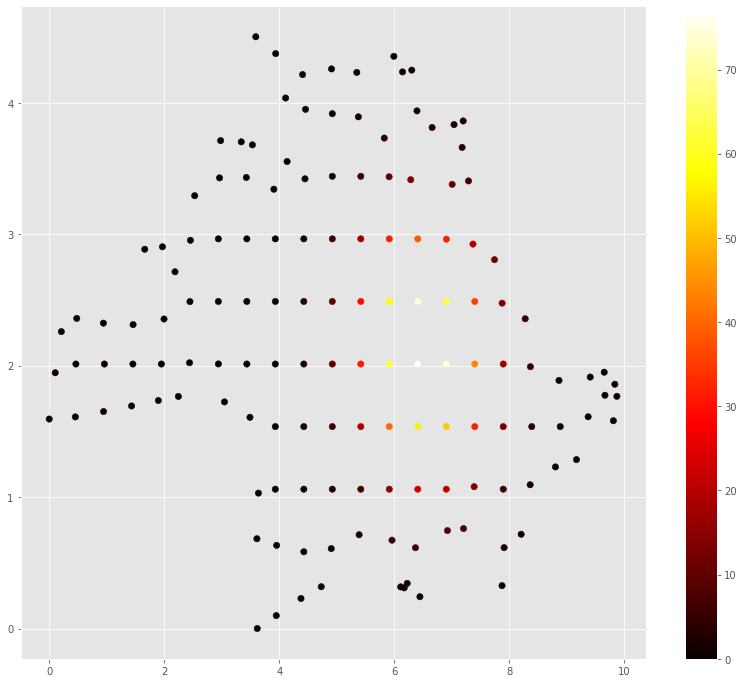

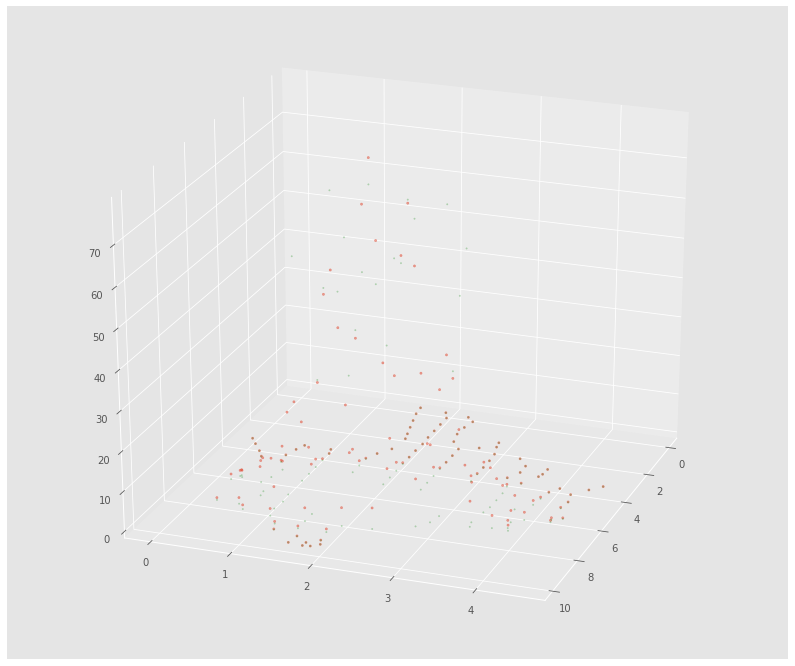

[86.02745782]
time: 736 ms


In [10]:
xy = np.vstack([x, y])
zobs = np.array(polyair.median_prices)
#zobs = np.where(zobs>0, zobs, 0.1*zobs.max())
import scipy.optimize as opt
import matplotlib.pyplot as plt

def _gaussian(M, *args):
    xy = M
    arr = np.zeros(len(zobs))
    for i in range(len(args)//6):
        arr += twoD_Gaussian(xy, *args[i*6:i*6+6])
    return arr


guess_prms = [(77.5,6.408968, 2.012637, 2, 0.3,3)
             ]

# Flatten the initial guess parameter list.
p0 = [p for prms in guess_prms for p in prms]

def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, theta):
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()
popt, pcov = opt.curve_fit(_gaussian, xy, zobs, p0)
#pred_params, uncert_cov = opt.curve_fit(gauss2d, xy, zobs, p0=guess)

zpred = np.zeros(len(zobs))
for i in range(len(popt)//6):
    zpred += twoD_Gaussian(xy, *popt[i*6:i*6+6])

# for i in range(len(popt)//5):
#     fit += gaussian(X, Y, *popt[i*5:i*5+5])
print('Fitted parameters:')
print(popt)

rms = np.sqrt(np.mean((zobs - zpred)**2))
print('RMS residual =', rms)


fig, ax = plt.subplots(figsize=(14,12))
scat = ax.scatter(x, y, c=zpred, vmin=0, vmax=zobs.max(), s=40, cmap='hot')
fig.colorbar(scat)
plt.savefig('Arezzo_fitted.jpg')
plt.show()


#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)
# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, zpred, cmap='plasma', s=5, alpha=0.5)
ax.scatter(x, y, zobs, color='green', s=2, alpha=0.2)
ax.set_zlim(0,np.max(np.array(polyair.median_prices))+2)
ax.view_init(25, 20)
plt.show()

print(popt[::6])

In [11]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

sqrt_eigs_long = np.array([])
sqrt_eigs_short = np.array([])
for i in range(0, len(popt), 6):
    a = (np.cos(popt[i+5])**2)/(2*popt[i+3]**2) + (np.sin(popt[i+5])**2)/(2*popt[i+4]**2)
    b = -(np.sin(2*popt[i+5]))/(4*popt[i+3]**2) + (np.sin(2*popt[i+5]))/(4*popt[i+4]**2)
    c = (np.sin(popt[i+5])**2)/(2*popt[i+3]**2) + (np.cos(popt[i+5])**2)/(2*popt[i+4]**2)
    cov = np.array([a, b, b, c]).reshape(-1, 2)
    print("Is cov_{} positive definite?: ".format(i//6+1), is_pos_def(cov))
    eigenvalues = np.linalg.eigvals(cov)
    eigenvalues = eigenvalues[eigenvalues>0]
    if eigenvalues.size!=0:
        stds = np.sqrt(eigenvalues)/popt[i]
        #stds = stds[stds>=0]
        sqrt_eigs_long = np.append(sqrt_eigs_long,max(stds))
        sqrt_eigs_short = np.append(sqrt_eigs_short,min(stds))

print('long stds: ', sqrt_eigs_long, 'mean: ', np.mean(sqrt_eigs_long))
print('short stds: ', sqrt_eigs_short, 'mean: ', np.mean(sqrt_eigs_short))

Is cov_1 positive definite?:  True
long stds:  [0.01266196] mean:  0.012661960610292892
short stds:  [0.01053331] mean:  0.010533307389713151
time: 6 ms


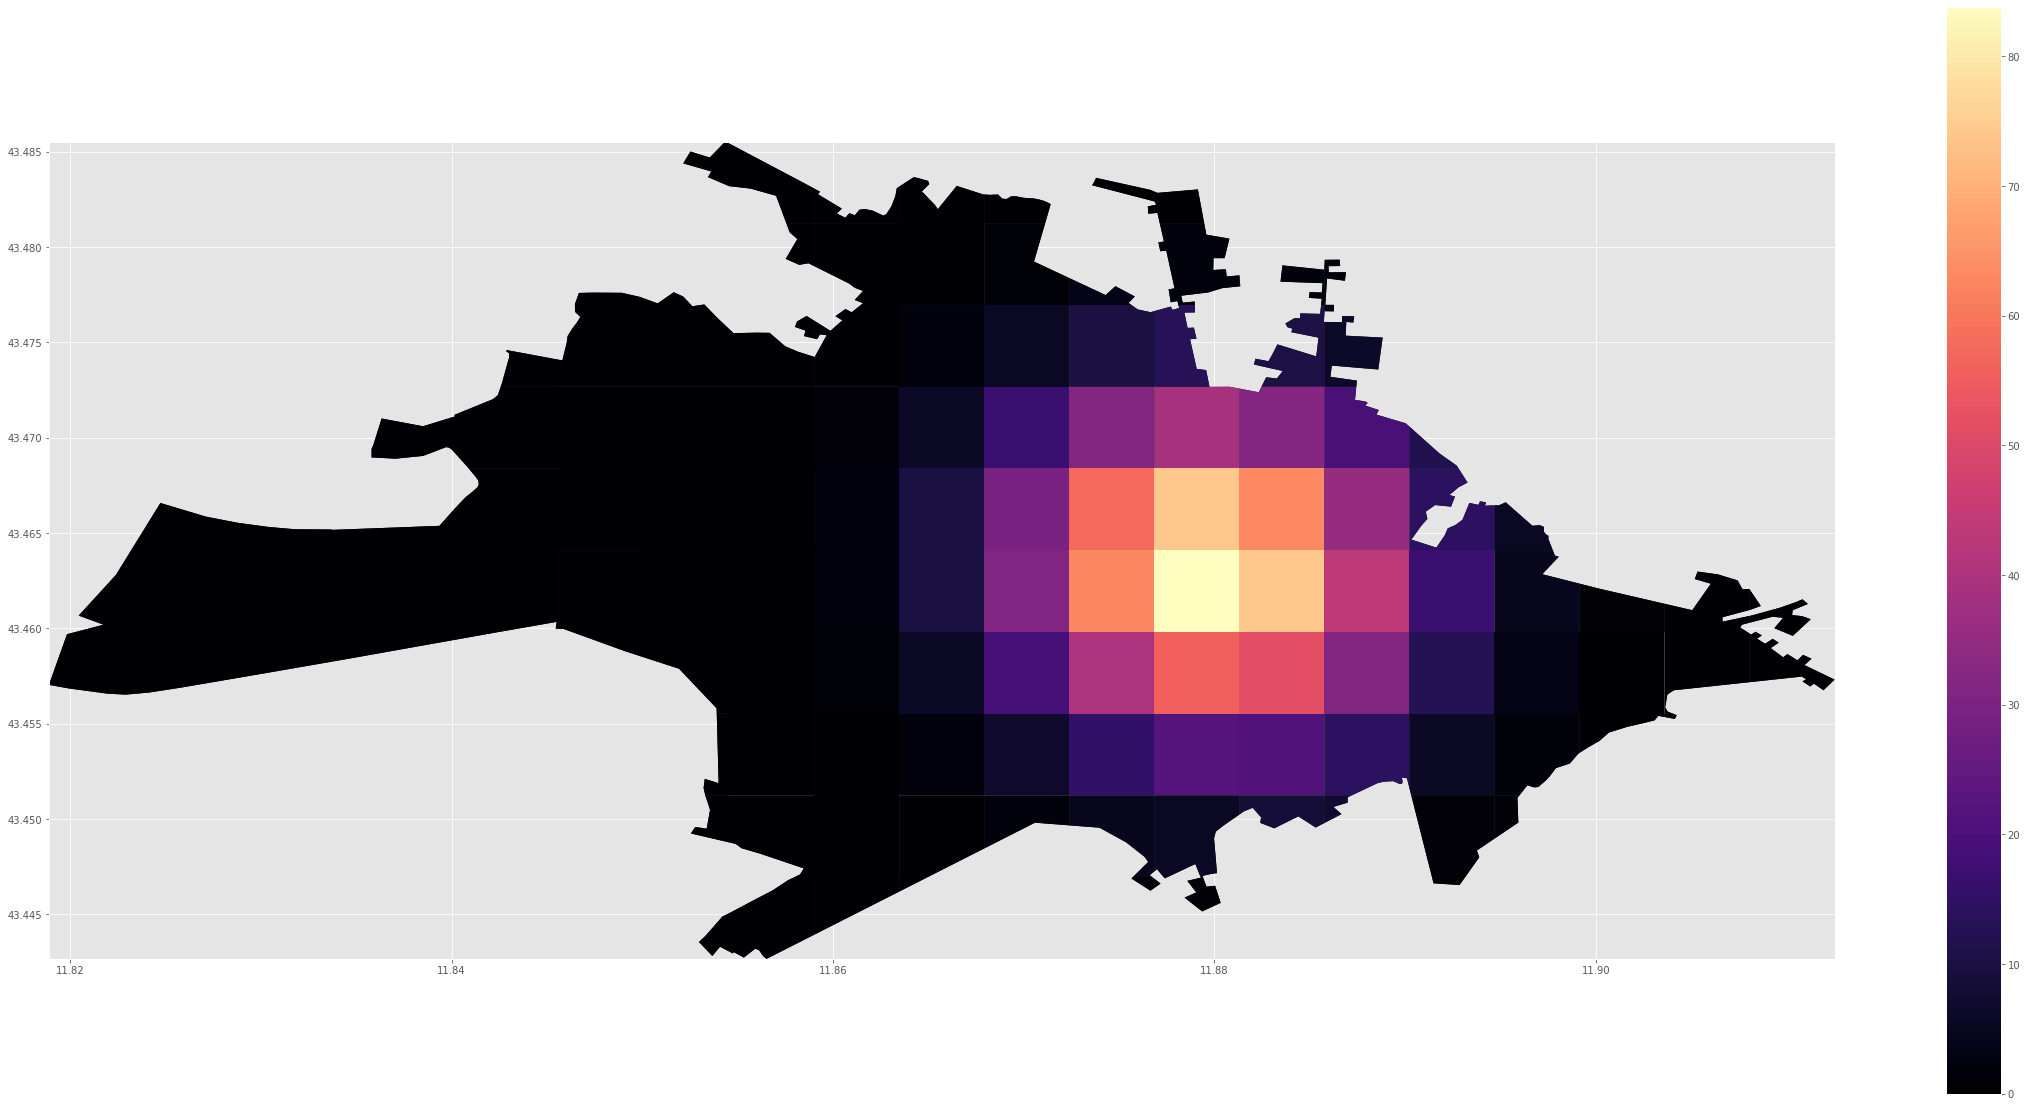

time: 907 ms


In [12]:
polyair['zpred'] = zpred
# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,20))

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='zpred',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

In [13]:
import pickle
pickle_in = open("Prices_params.pickle","rb")
prices_params_dict = pickle.load(pickle_in)
#prices_params_dict = {}
prices_params_dict['Arezzo'] = popt
pickle_out = open("Prices_params.pickle","wb")
pickle.dump(prices_params_dict, pickle_out)
pickle_out.close()

#average_slopes = {}
pickle_in_long = open("Average_price_slopes_long.pickle","rb")
average_slopes_long = pickle.load(pickle_in_long)
average_slopes_long['Arezzo'] = np.mean(sqrt_eigs_long)
pickle_out_long = open("Average_price_slopes_long.pickle","wb")
pickle.dump(average_slopes_long, pickle_out_long)
pickle_out_long.close()

pickle_in_short = open("Average_price_slopes_short.pickle","rb")
average_slopes_short = pickle.load(pickle_in_short)
average_slopes_short['Arezzo'] = np.mean(sqrt_eigs_short)
pickle_out_short = open("Average_price_slopes_short.pickle","wb")
pickle.dump(average_slopes_short, pickle_out_short)
pickle_out_short.close()

print('long: ', average_slopes_long, ' short: ', average_slopes_short)

long:  {'Paris': 0.010453121182320417, 'Amsterdam': 0.017790862401138207, 'Stockholm': 0.01160078748441716, 'Arezzo': 0.012661960610292892, 'Berlin': 0.017168942092868542, 'Bordeaux': 0.0057209390468692745, 'Denver': 0.00873766709683174, 'Edinburgh': 0.012921100209712873, 'Lyon': 0.00594530194011358, 'Madrid': 0.01315080289968449, 'Buenos_Aires': 0.00938788752473718, 'Palermo': 0.02659431146972356, 'Los_Angeles': 0.0056655377791732745, 'Beijing': 0.03548021455387483, 'Florence': 0.011913882705309832, 'Moscow': 0.026524810524746, 'Porto': 0.03745056113103571, 'Prague': 0.01850581507565583, 'Reykjavik': 0.04000475004839031, 'Riga': 0.02150786435094239, 'Rome': 0.009635062558537275, 'Seoul': 0.013154650694260608, 'Siena': 0.013838139160990736, 'Sydney': 0.009200022664460229, 'Tallin': 0.024848430854086192, 'Treviso': 0.015264513943951563, 'Valencia': 0.01982718757582555, 'Venezia': 0.013133572970121148, 'Verona': 0.01119208328282184, 'Vicenza': 0.029546407262138693, 'Vienna': 0.0120270170

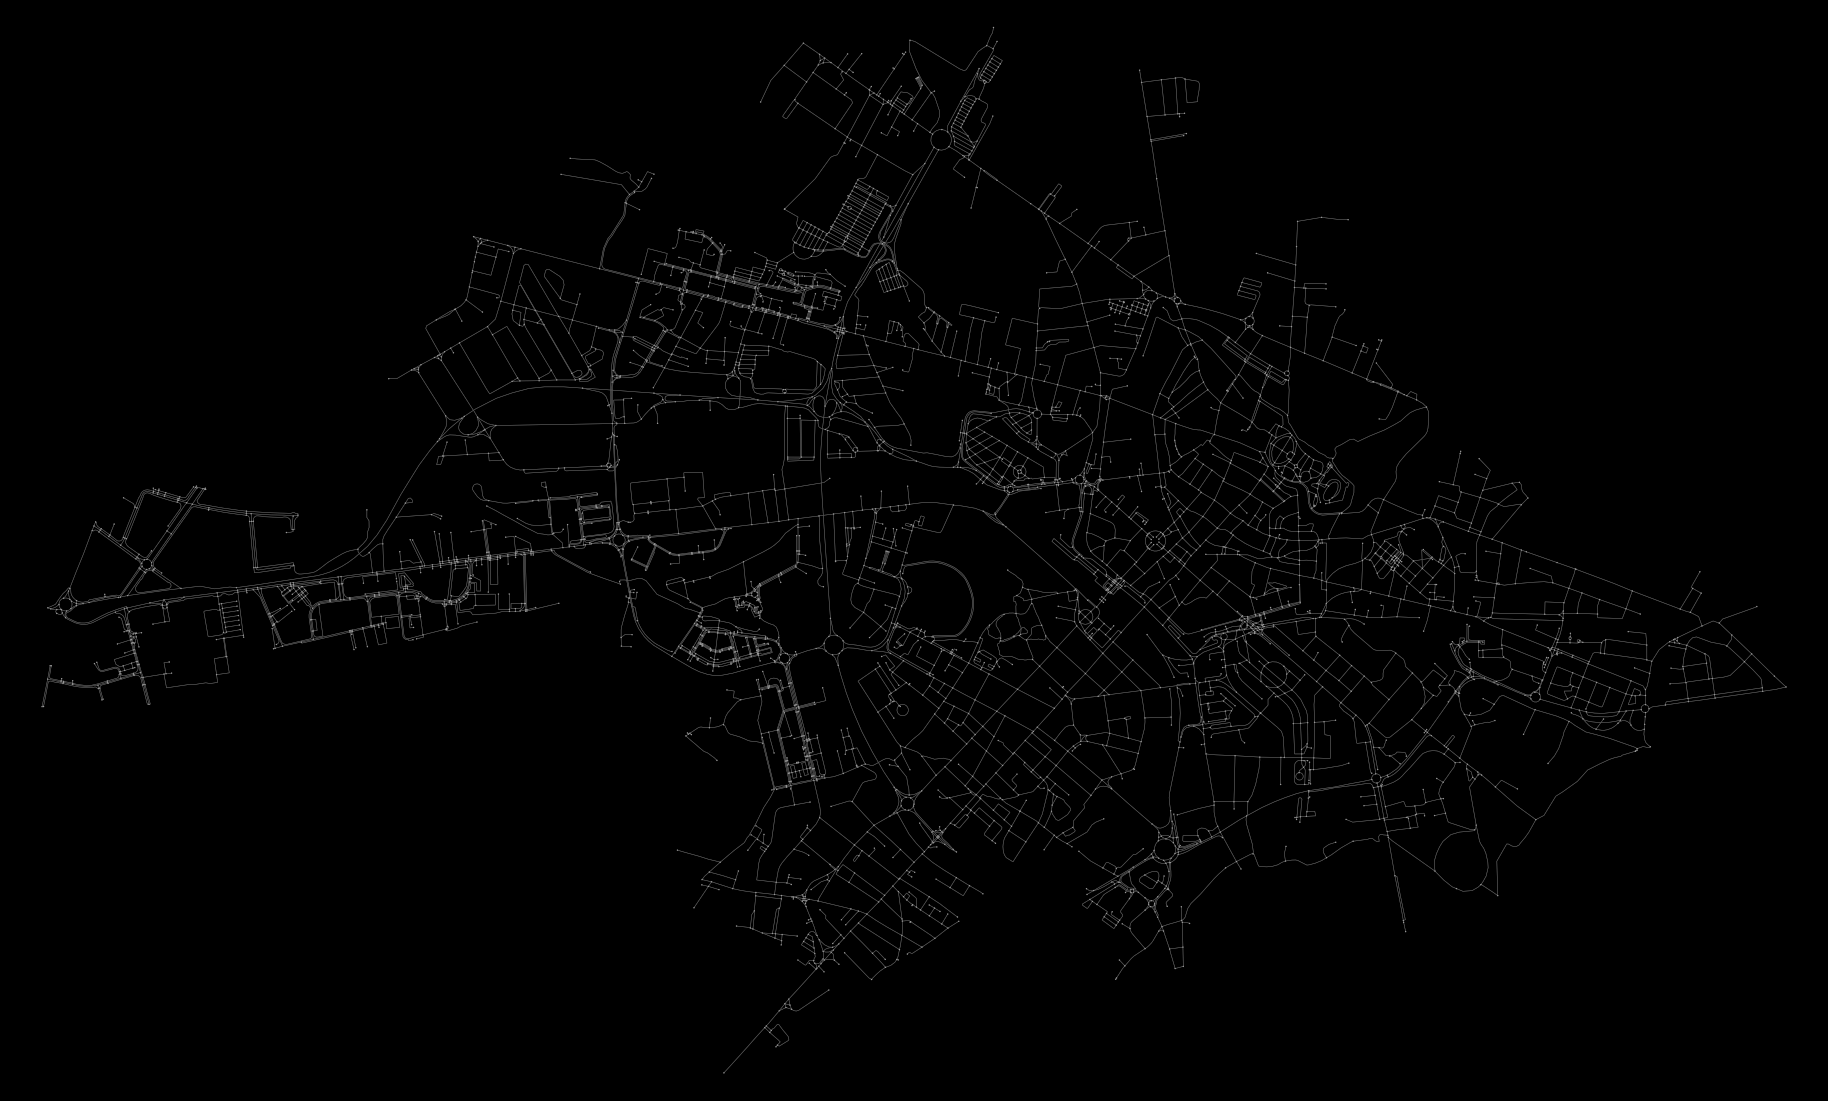

time: 11.8 s


In [14]:
# download and project a street network
G = ox.graph_from_place('Arezzo, Italy', network_type="walk")
#G = ox.project_graph(G)
fig, ax = ox.plot_graph(G, fig_height=20, bgcolor='k', node_size=2, node_color='#999999', node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=0.5, edge_alpha=1)

In [15]:
centers = {}
for i in range(0, len(popt), 6):
    lon = popt[i+1]*1000 + (np.array(polyair.center_lon)*500/meter_500).min()
    lon = lon*meter_500/500
    lat = popt[i+2]*1000 + (np.array(polyair.center_lat)*500/meter_500).min()
    lat = lat*meter_500/500
    centers['center_node_{}'.format(i//6+1)] = ox.get_nearest_node(G, (lat,lon))

centers

{'center_node_1': 243466238}

time: 20 ms


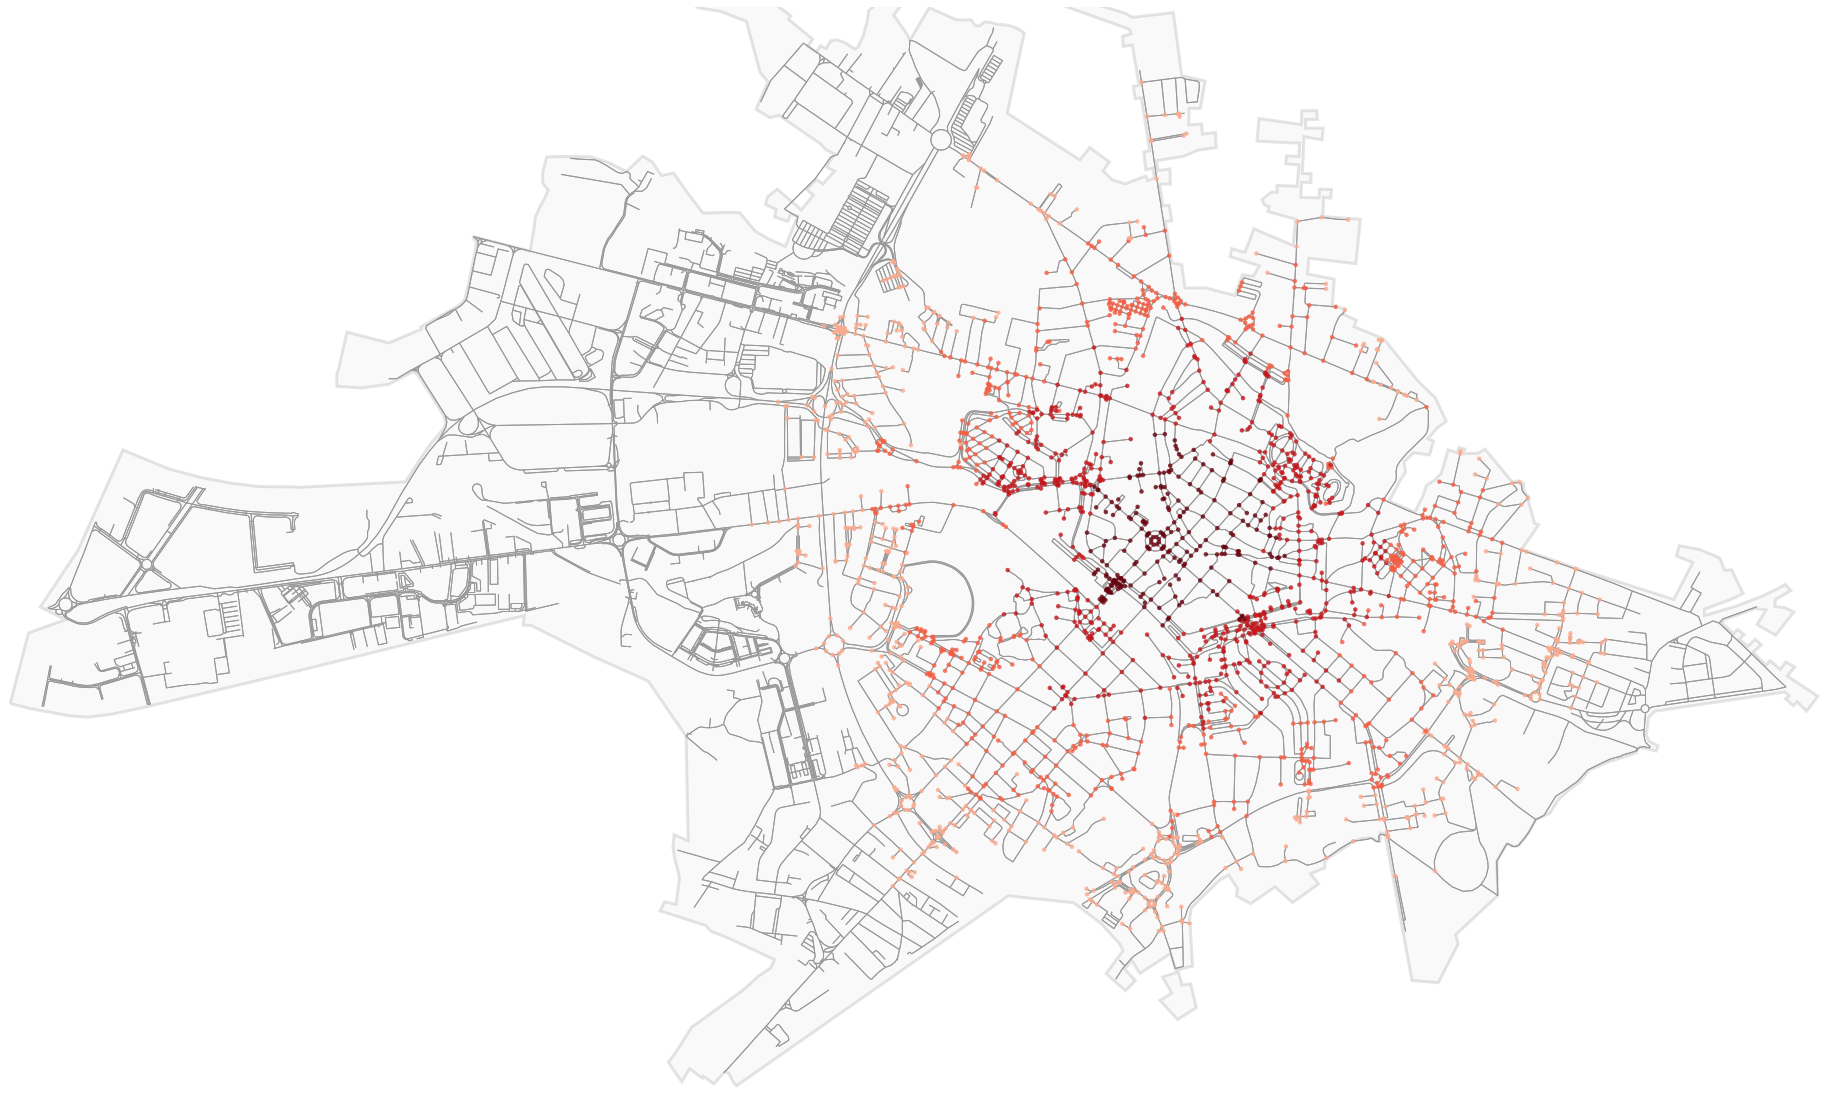

time: 3.99 s


In [16]:
import networkx as nx
#center_node = ox.get_nearest_node(G, (popt[8],popt[7]))
center_node = centers['center_node_1']
# list of distances from center
dists = np.arange(500, 2500, 500)
dists

# get one color for each isochrone
iso_colors = ox.get_colors(n=len(dists), cmap='Reds', start=0.3, return_hex=True)
# color the nodes according to isochrone then plot the street network
node_colors = {}
for dist, color in zip(sorted(dists, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=dist, distance='length')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [20 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, fig_height=20,show=False, close=False, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2)
plt.close()
# to this matplotlib axis, add the place shape as descartes polygon patches
for geometry in city['geometry'].tolist():
    if isinstance(geometry, (Polygon, MultiPolygon)):
        if isinstance(geometry, Polygon):
            geometry = MultiPolygon([geometry])
        for polygon in geometry:
            patch = PolygonPatch(polygon, fc='#cccccc', ec='k', linewidth=3, alpha=0.1, zorder=-1)
            ax.add_patch(patch)
            
fig

144
144 45
Number of cells with price above 5th percentile:  45



[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Yes


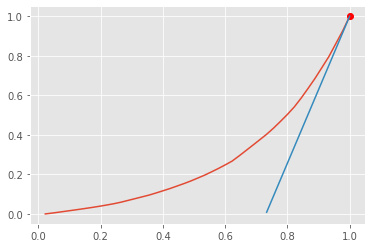

Loubar price:  31.765356275694476
Average price:  25.44449961265943
average city distance:  1662.0178383704194
eta =  0.5574311537992848
time: 404 ms


In [17]:
from tqdm import tqdm_notebook

#poly_prices = polyair[polyair.median_prices>0]
poly_prices = polyair.copy()
print(len(poly_prices))
poly_prices['zpred'] = zpred

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys = np.array(keys)

vals_cut = vals[vals>0.05*vals.max()]
print(len(vals), len(vals_cut))

L = np.cumsum(vals_cut)/np.sum(vals_cut)
keys = keys[vals>0.05*vals.max()]
print('Number of cells with price above 5th percentile: ', len(keys))



mat = np.zeros(shape=(len(geometry_cut), len(geometry_cut)))
for pair in tqdm_notebook(combinations(sorted(keys), 2)):
    mat[pair[0], pair[1]] = geometry_cut[pair[0]].centroid.distance(geometry_cut[pair[1]].centroid)
    
print(mat)


def isuppertriangular(M): 
    for i in range(1, len(M)): 
        for j in range(0, i): 
            if(M[i][j] != 0):  
                    return False
    return True

  
if isuppertriangular(mat): 
    print ("Yes") 
else: 
    print ("No") 
    
    
L1= L
F1 = np.arange(1, len(L1)+1)/len(L1)

L1 = (L1 - L1.min())/(L1.max()-L1.min())

from scipy import interpolate
tck = interpolate.splrep(F1,L1)
x0_1 =1
y0_1 = interpolate.splev(x0_1,tck)
dydx = interpolate.splev(x0_1,tck,der=1)
tngnt1 = lambda x: dydx*x + (y0_1-dydx*x0_1)
plt.plot(F1, L1)
plt.plot(x0_1,y0_1, "or")
plt.plot(F1[tngnt1(F1)>0],tngnt1(F1[tngnt1(F1)>0]), label="tangent")
plt.show()

indlist = poly_prices.index.tolist()

loubar_val = vals_cut[np.where(tngnt1(F1)>0)[0][0]]

print('Loubar price: ', loubar_val)
print('Average price: ', np.mean(vals_cut))

if loubar_val > np.mean(vals_cut):
    loubar_keys = keys[vals_cut>loubar_val]
else:
    loubar_keys = keys[vals_cut>np.mean(vals_cut)]
#loubar_keys = keys[vals_cut>np.mean(vals_cut)]
dist_mat = mat[keys.reshape(-1,1), keys]

total_dist = dist_mat.sum()
dist_corr = dist_mat[dist_mat>0]

loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]
loubar_dist = loubar_dist_mat.sum()

loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
eta_loubar = loubar_dist_corr.mean()/dist_corr.mean()
avg_dist_meters = (dist_corr.mean()/0.00899928)*1000
print('average city distance: ', avg_dist_meters)
print('eta = ', eta_loubar)

In [18]:
pickle_in = open("City_spreading_index.pickle","rb")
spreading_index_dict = pickle.load(pickle_in)
#spreading_index_dict = {}
spreading_index_dict['Arezzo'] = eta_loubar


pickle_out = open("City_spreading_index.pickle","wb")
pickle.dump(spreading_index_dict, pickle_out)
pickle_out.close()

spreading_index_dict

{'Paris': 0.7251609142253275,
 'Amsterdam': 0.6513935879350918,
 'Stockholm': 0.6839327295656318,
 'Arezzo': 0.5574311537992848,
 'Berlin': 0.7499866909236614,
 'Bordeaux': 0.5818334466519048,
 'Denver': 0.6312111392217781,
 'Edinburgh': 0.6813298654934006,
 'Lyon': 0.6138305864151811,
 'Madrid': 0.6426066210787698,
 'Buenos_Aires': 0.8337988194080271,
 'Palermo': 0.8841435007903967,
 'Los_Angeles': 0.7889452782510832,
 'Beijing': 0.6425383574699105,
 'Florence': 0.5049117106731263,
 'Moscow': 0.6925493573699144,
 'Porto': 0.7058843952576399,
 'Prague': 0.5522963433539414,
 'Reykjavik': 0.8276260142343259,
 'Riga': 0.6850021296374689,
 'Rome': 0.5803964773671335,
 'Seoul': 0.8924742030382572,
 'Siena': 0.5646389917673048,
 'Sydney': 0.7909301400958108,
 'Tallin': 0.5690189423395199,
 'Treviso': 0.5345662066021125,
 'Valencia': 0.6956994914059091,
 'Venezia': 0.656650370883064,
 'Verona': 0.5707647012625697,
 'Vicenza': 0.5117751186840898,
 'Vienna': 0.6189242538490607,
 'Wellington': 0

time: 7.99 ms


In [19]:
pickle_in = open("avg_distances_dict.pickle","rb")
avg_distances_dict = pickle.load(pickle_in)
#avg_distances_dict = {}
avg_distances_dict['Arezzo'] = avg_dist_meters


pickle_out = open("avg_distances_dict.pickle","wb")
pickle.dump(avg_distances_dict, pickle_out)
pickle_out.close()

avg_distances_dict

{'Venezia': 2398.636425932576,
 'Verona': 3141.8502884813342,
 'Vicenza': 1988.2224372858566,
 'Vienna': 5125.89366602888,
 'Wellington': 2806.4963410749997,
 'Zurich': 2068.4583585914684,
 'Aarhus': 2857.919349359045,
 'Milan': 6008.128043000454,
 'Busan': 7348.804402235624,
 'Valencia': 4090.433301180094,
 'Bologna': 2104.4589605649485,
 'Barcelona': 4218.232625020259,
 'Bremen': 3772.1380465457137,
 'Brno': 2231.9772664038364,
 'Budapest': 3463.3335339061914,
 'Dublin': 4138.1465107736385,
 'Boston': 5610.60832524716,
 'Rio': 8357.334811118957,
 'NY': 8563.096975538809,
 'Ottawa': 2220.3476963993976,
 'Nashville': 5606.900406329212,
 'New_Orleans': 5048.047130029565,
 'Shanghai': 5452.583570486633,
 'Portland': 5406.388840795854,
 'Amsterdam': 7020.480387015727,
 'Arezzo': 1662.0178383704194}

time: 4.98 ms


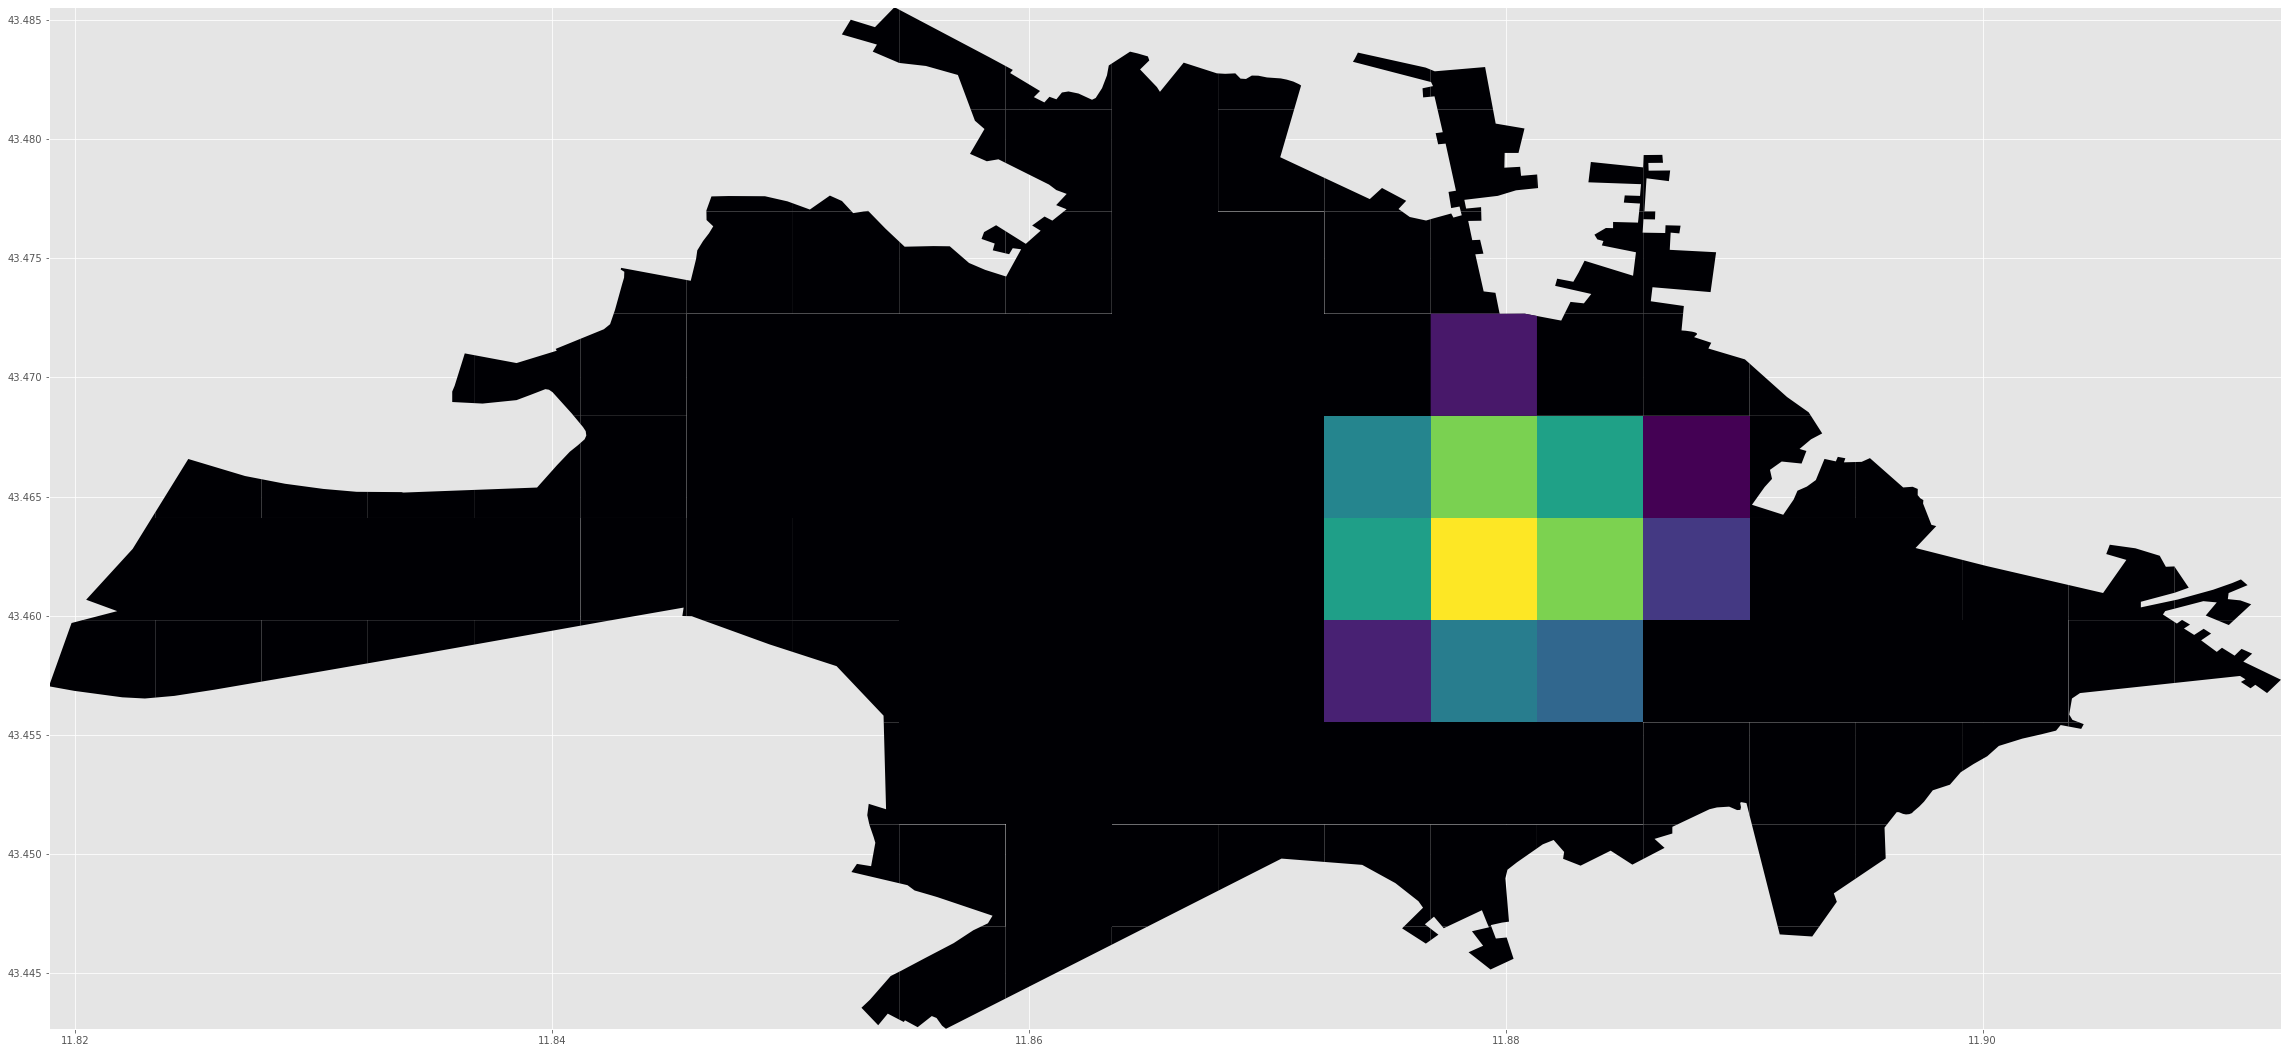

time: 944 ms


In [20]:
# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))

polyframe.plot(ax=ax, color='#000004')
#polyair.plot(column='prices',  legend=True, cmap='magma', ax=ax)    
poly_prices[poly_prices.index.isin(loubar_keys)].plot(ax=ax, column='zpred')
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

In [21]:
lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    
print(len(keys))
vals = np.array(vals)
keys = np.array(keys)
keys = keys[vals>=0.01*vals.max()]
print(len(keys))

indlist = poly_prices.index.tolist()
mat = np.zeros(shape=(len(geometry_cut), len(geometry_cut)))
for pair in tqdm_notebook(combinations(sorted(keys), 2)):
    mat[pair[0], pair[1]] = geometry_cut[pair[0]].centroid.distance(geometry_cut[pair[1]].centroid)

print(mat)


def isuppertriangular(M): 
    for i in range(1, len(M)): 
        for j in range(0, i): 
            if(M[i][j] != 0):  
                    return False
    return True


if isuppertriangular(mat): 
    print ("Yes") 
else: 
    print ("No")

144
67



[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Yes
time: 239 ms


144


144 67
Number of cells with price above 1.0th percentile:  67
Loubar price:  21.005258805683283
Average price:  17.73944494939159
eta =  0.558066231781893
144 58
Number of cells with price above 2.0th percentile:  58
Loubar price:  30.93963055475684
Average price:  20.28510225046123
eta =  0.5413645041341291
144 49
Number of cells with price above 3.0th percentile:  49
Loubar price:  31.374643771369023
Average price:  23.636665957398474
eta =  0.5489791867098104
144 47
Number of cells with price above 4.0th percentile:  47
Loubar price:  31.765356275694476
Average price:  24.509778703802702
eta =  0.5453002185984605
144 45
Number of cells with price above 5.0th percentile:  45
Loubar price:  31.765356275694476
Average price:  25.44449961265943
eta =  0.5574311537992848
144 43
Number of cells with price above 6.000000000000001th percentile:  43
Loubar price:  35.59231477070731
Average price:  26.405923262049146
eta =  0.5459112677673079
144 39
Number of cells with price above 6.99999999

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning:

Mean of empty slice.

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning:

invalid value encountered in double_scalars



eta =  nan
144 7
Number of cells with price above 63.0th percentile:  7
Loubar price:  74.26724830323059
Average price:  67.35518682276994
eta =  nan
144 7
Number of cells with price above 64.0th percentile:  7
Loubar price:  74.26724830323059
Average price:  67.35518682276994
eta =  nan
144 7
Number of cells with price above 65.0th percentile:  7
Loubar price:  74.26724830323059
Average price:  67.35518682276994
eta =  nan
144 7
Number of cells with price above 66.0th percentile:  7
Loubar price:  74.26724830323059
Average price:  67.35518682276994
eta =  nan
144 6
Number of cells with price above 67.0th percentile:  6
Loubar price:  74.26724830323059
Average price:  69.27543693455222
eta =  nan
144 6
Number of cells with price above 68.0th percentile:  6
Loubar price:  74.26724830323059
Average price:  69.27543693455222
eta =  nan
144 5
Number of cells with price above 69.0th percentile:  5
Loubar price:  74.26724830323059
Average price:  71.60680650615184
eta =  nan
144 5
Number of 

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning:

invalid value encountered in true_divide



Loubar price:  83.83065703527548
Average price:  83.83065703527548
eta =  nan
144 1
Number of cells with price above 90.0th percentile:  1
Loubar price:  83.83065703527548
Average price:  83.83065703527548
eta =  nan
144 1
Number of cells with price above 91.0th percentile:  1
Loubar price:  83.83065703527548
Average price:  83.83065703527548
eta =  nan
144 1
Number of cells with price above 92.0th percentile:  1
Loubar price:  83.83065703527548
Average price:  83.83065703527548
eta =  nan
144 1
Number of cells with price above 93.0th percentile:  1
Loubar price:  83.83065703527548
Average price:  83.83065703527548
eta =  nan
144 1
Number of cells with price above 94.0th percentile:  1
Loubar price:  83.83065703527548
Average price:  83.83065703527548
eta =  nan
144 1
Number of cells with price above 95.0th percentile:  1
Loubar price:  83.83065703527548
Average price:  83.83065703527548
eta =  nan
144 1
Number of cells with price above 96.00000000000001th percentile:  1
Loubar price: 

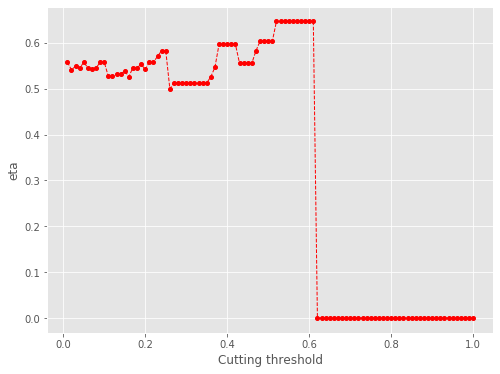

time: 2.51 s


In [22]:
from tqdm import tqdm_notebook

#poly_prices = polyair[polyair.median_prices>0]
poly_prices = polyair.copy()
print(len(poly_prices))
poly_prices['zpred'] = zpred

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys_initial = np.array(keys)


perc_vals = np.linspace(0.01, 1, 100)
etas_cut = []
for i in tqdm_notebook(perc_vals):
    keys = keys_initial
    vals_cut = vals[vals>=i*vals.max()]
    print(len(vals), len(vals_cut))

    L = np.cumsum(vals_cut)/np.sum(vals_cut)
    keys = keys[vals>=i*vals.max()]
    print('Number of cells with price above {}th percentile: '.format(i*100), len(keys))
    
    
        
    L1= L
    F1 = np.arange(1, len(L1)+1)/len(L1)

    L1 = (L1 - L1.min())/(L1.max()-L1.min())
    

    loubar_val = vals_cut[np.where(tngnt1(F1)>0)[0][0]]

    print('Loubar price: ', loubar_val)
    print('Average price: ', np.mean(vals_cut))
    
    
    loubar_keys = keys[vals_cut>loubar_val]
    dist_mat = mat[keys.reshape(-1,1), keys]

    total_dist = dist_mat.sum()
    dist_corr = dist_mat[dist_mat>0]

    loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

    loubar_dist = loubar_dist_mat.sum()

    loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
    eta = loubar_dist_corr.mean()/dist_corr.mean()
    etas_cut.append(eta)
    print('eta = ', eta)
etas_cut = np.array(etas_cut)
etas_cut = np.where(np.isnan(etas_cut), 0, etas_cut)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(perc_vals, etas_cut, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
plt.xlabel("Cutting threshold")
plt.ylabel("eta")
plt.show()

eta =  1.0
eta =  1.0
eta =  1.0
eta =  0.9826790541889018
eta =  0.905851995556138
eta =  0.8853260236982895
eta =  0.8222772481974272
eta =  0.8222772481974272
eta =  0.7877704841698318
eta =  0.7498271875355369
eta =  0.7104639668359044
eta =  0.7104639668359044
eta =  0.6797514234722674
eta =  0.6488740075964148
eta =  0.6488740075964148
eta =  0.6488740075964148
eta =  0.6488740075964148
eta =  0.6488740075964148
eta =  0.6322263444291591
eta =  0.5574311537992848
eta =  0.5574311537992848
eta =  0.5364555682806424
eta =  0.5364555682806424
eta =  0.5116111772588097
eta =  0.4939426807806762
eta =  0.4939426807806762
eta =  0.4608792520194343
eta =  0.4608792520194343
eta =  0.4608792520194343
eta =  0.4608792520194343
eta =  0.4608792520194343
eta =  0.4380592578921534
eta =  0.4380592578921534
eta =  0.4147281086726919
eta =  0.3965258254408888
eta =  0.3965258254408888
eta =  0.3965258254408888
eta =  0.3326854866904326
eta =  0.3326854866904326
eta =  0.3326854866904326
eta = 

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning:

Mean of empty slice.



eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan



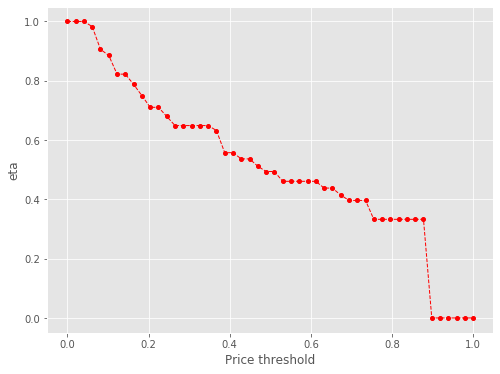

time: 371 ms


In [36]:
lval = np.linspace(0, max(vals_cut), 50)
etas = []
for i in tqdm_notebook(lval):
    loubar_keys = keys[vals_cut>=i]
    dist_mat = mat[keys.reshape(-1,1), keys]

    total_dist = dist_mat.sum()
    dist_corr = dist_mat[dist_mat>0]

    loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

    loubar_dist = loubar_dist_mat.sum()

    loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
    eta = loubar_dist_corr.mean()/dist_corr.mean()
    etas.append(eta)
    print('eta = ', eta)
etas = np.array(etas)
etas = np.where(np.isnan(etas), 0, etas)
lval = lval/lval.max()
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(lval, etas, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
plt.xlabel("Price threshold")
plt.ylabel("eta")
plt.show()

In [23]:
pickle_in = open("etas_cut_dict.pickle","rb")
etas_cut_dict = pickle.load(pickle_in)
#etas_cut_dict = {}
etas_cut_dict['Arezzo'] = etas_cut


pickle_out = open("etas_cut_dict.pickle","wb")
pickle.dump(etas_cut_dict, pickle_out)
pickle_out.close()

etas_cut_dict

{'Boston': array([0.54176111, 0.69697859, 0.70601119, 0.71142664, 0.72735905,
        0.71723297, 0.69152614, 0.68969459, 0.69338651, 0.68627389,
        0.68571239, 0.68565242, 0.66080855, 0.68568495, 0.66662135,
        0.65169235, 0.66853925, 0.64080339, 0.6392735 , 0.64870117,
        0.66369008, 0.64936606, 0.65513408, 0.65817401, 0.54708479,
        0.54484174, 0.5177247 , 0.54225619, 0.54660686, 0.55128317,
        0.55836993, 0.56571414, 0.52792612, 0.52759205, 0.55096732,
        0.46941853, 0.48021089, 0.47484233, 0.46129546, 0.46439344,
        0.4699713 , 0.50255475, 0.51573036, 0.52765377, 0.52765377,
        0.53943229, 0.54404083, 0.54813213, 0.6100999 , 0.50092562,
        0.52536404, 0.56707558, 0.56150998, 0.61316219, 0.66467806,
        0.74541769, 0.74541769, 0.77652679, 0.74895419, 0.92876367,
        0.92876367, 0.90963119, 0.90963119, 1.05344906, 1.15130075,
        1.15130075, 1.22651104, 1.26738008, 0.62257449, 0.62257449,
        0.64231201, 0.64231201, 0.6240

time: 32 ms


100
100
100
100
100
100
100
100
100
100
100
100


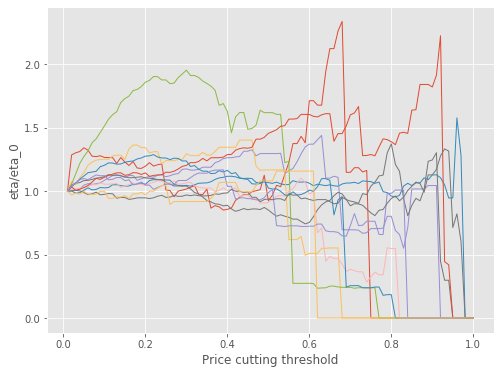

time: 309 ms


In [24]:
fig, ax = plt.subplots(figsize=(8, 6))
for key in etas_cut_dict:
    print(len(etas_cut_dict[key]))
    etas = etas_cut_dict[key]#[1:]
    vals = etas/etas[0]
    plt.plot(np.linspace(0.01, 1, 100), vals, linestyle='-', linewidth=1)
plt.xlabel("Price cutting threshold")
plt.ylabel("eta/eta_0")
plt.show()

144 45
Number of cells with price above 5th percentile:  45


eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  0.9826790541889018
eta =  0.9271776377563916
eta =  0.905851995556138
eta =  0.8853260236982895
eta =  0.8853260236982895
eta =  0.8749869456848516
eta =  0.8301194857181923
eta =  0.8222772481974272
eta =  0.8222772481974272
eta =  0.8003008143373842
eta =  0.7877704841698318
eta =  0.7593670652249569
eta =  0.7498271875355369
eta =  0.7498271875355369
eta =  0.7104639668359044
eta =  0.7104639668359044
eta =  0.7104639668359044
eta =  0.6948530408604354
eta =  0.6797514234722674
eta =  0.6655210290988804
eta =  0.6488740075964148
eta =  0.6488740075964148
eta =  0.6488740075964148
eta =  0.6488740075964148
eta =  0.6488740075964148
eta =  0.6488740075964148
eta =  0.6488740075964148
eta =  0.6488740075964148
eta =  0.6488740075964148
eta =  0.6322263444291591
eta =  0.6322263444291591
eta =  0.5880402173554435
eta =  0.5574311537992848
eta =  0.5574311537992848
eta =  0.5574311537992848
eta =  0.5574311537992848

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning:

Mean of empty slice.



eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan



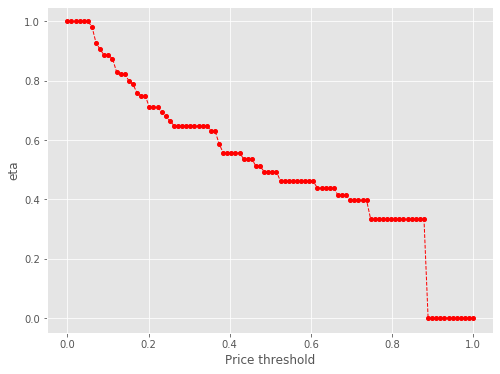

time: 827 ms


In [25]:
lval = np.linspace(0, max(vals_cut), 100)
etas = []

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys = np.array(keys)
vals_cut = vals[vals>0.05*vals.max()]
print(len(vals), len(vals_cut))

L = np.cumsum(vals_cut)/np.sum(vals_cut)
keys = keys[vals>0.05*vals.max()]
print('Number of cells with price above 5th percentile: ', len(keys))

for i in tqdm_notebook(lval):
    loubar_keys = keys[vals_cut>=i]
    dist_mat = mat[keys.reshape(-1,1), keys]

    total_dist = dist_mat.sum()
    dist_corr = dist_mat[dist_mat>0]

    loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

    loubar_dist = loubar_dist_mat.sum()

    loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
    eta = loubar_dist_corr.mean()/dist_corr.mean()
    etas.append(eta)
    print('eta = ', eta)
etas = np.array(etas)
etas = np.where(np.isnan(etas), 0, etas)
lval = lval/lval.max()
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(lval, etas, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
plt.xlabel("Price threshold")
plt.ylabel("eta")
plt.show()

etas_cut_threshold = etas

In [26]:
pickle_in = open("etas_cut_threshold_dict.pickle","rb")
etas_cut_threshold_dict = pickle.load(pickle_in)
#etas_cut_threshold_dict = {}
etas_cut_threshold_dict['Arezzo'] = etas_cut_threshold


pickle_out = open("etas_cut_threshold_dict.pickle","wb")
pickle.dump(etas_cut_threshold_dict, pickle_out)
pickle_out.close()

etas_cut_threshold_dict

{'NY': array([1.        , 1.        , 1.        , 1.        , 1.        ,
        0.99991145, 0.98955316, 0.97868522, 0.96344498, 0.95205618,
        0.94615067, 0.93194961, 0.92540239, 0.92150344, 0.91822455,
        0.91569734, 0.91218202, 0.90337978, 0.898264  , 0.89376519,
        0.89441924, 0.88573077, 0.88617046, 0.87902683, 0.87195329,
        0.87101443, 0.87158631, 0.86935351, 0.86321974, 0.86053312,
        0.86079304, 0.86069179, 0.86140605, 0.85888874, 0.8617884 ,
        0.85709178, 0.8579834 , 0.85179248, 0.84947743, 0.84847717,
        0.84228408, 0.82983947, 0.82767187, 0.82334824, 0.81678545,
        0.81788964, 0.81304395, 0.807866  , 0.79902867, 0.79698224,
        0.78820712, 0.76853775, 0.76312442, 0.75071909, 0.7481045 ,
        0.73389742, 0.71700231, 0.70245218, 0.68328343, 0.67990807,
        0.66811743, 0.61552082, 0.58620924, 0.57826542, 0.57372339,
        0.55441141, 0.5326264 , 0.53706259, 0.53126932, 0.52772792,
        0.5331439 , 0.51700595, 0.49034259

time: 29 ms


144 67
Number of cells with price above 1.0th percentile:  67


eta =  1.0
eta =  0.9257600742660329
eta =  0.8687075405729011
eta =  0.8470102772533512
eta =  0.8385403426508071
eta =  0.8240160308153327
eta =  0.7666587771430464
eta =  0.7507768256033955
eta =  0.7423815872696402
eta =  0.7423815872696402
eta =  0.7337118532495587
eta =  0.6895126454574334
eta =  0.6895126454574334
eta =  0.6895126454574334
eta =  0.6710845190781901
eta =  0.6605773317259629
eta =  0.6367599190714731
eta =  0.6287603467649401
eta =  0.6287603467649401
eta =  0.595752698191631
eta =  0.595752698191631
eta =  0.595752698191631
eta =  0.5826623069750648
eta =  0.569998991555809
eta =  0.558066231781893
eta =  0.5441070326671
eta =  0.5441070326671
eta =  0.5441070326671
eta =  0.5441070326671
eta =  0.5441070326671
eta =  0.5441070326671
eta =  0.5441070326671
eta =  0.5441070326671
eta =  0.5441070326671
eta =  0.5441070326671
eta =  0.5301472954904943
eta =  0.5100810099786928
eta =  0.467428510711087
eta =  0.467428510711087
eta =  0.467428510711087
eta =  0.4674

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning:

Mean of empty slice.



eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan


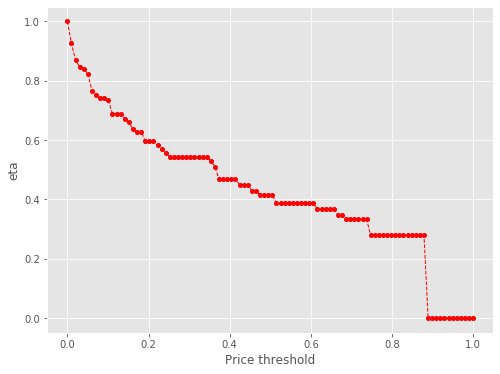

144 58
Number of cells with price above 2.0th percentile:  58


eta =  1.0
eta =  0.9219857586140532
eta =  0.8989577925297121
eta =  0.8899683930883442
eta =  0.8745532987780709
eta =  0.8251587923815027
eta =  0.806179644860966
eta =  0.78791217867006
eta =  0.78791217867006
eta =  0.7787107260244257
eta =  0.7787107260244257
eta =  0.73180076125137
eta =  0.73180076125137
eta =  0.7240647305600694
eta =  0.7010908319190521
eta =  0.6758126868024668
eta =  0.6758126868024668
eta =  0.6673224971849543
eta =  0.6673224971849543
eta =  0.6322904749121205
eta =  0.6322904749121205
eta =  0.6183972442071113
eta =  0.6049572820471284
eta =  0.6049572820471284
eta =  0.5922926808336318
eta =  0.5774773578573753
eta =  0.5774773578573753
eta =  0.5774773578573753
eta =  0.5774773578573753
eta =  0.5774773578573753
eta =  0.5774773578573753
eta =  0.5774773578573753
eta =  0.5774773578573753
eta =  0.5774773578573753
eta =  0.5626614638197368
eta =  0.5626614638197368
eta =  0.5061509919219704
eta =  0.4960961082041311
eta =  0.4960961082041311
eta =  0.4

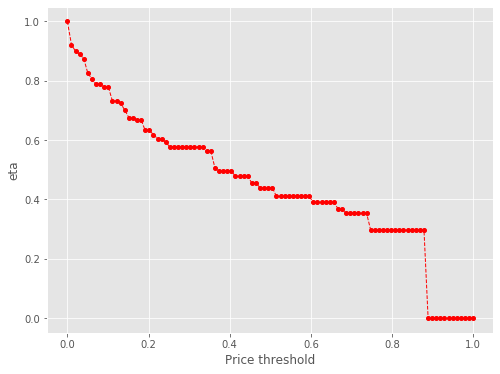

144 49
Number of cells with price above 3.0th percentile:  49


eta =  1.0
eta =  0.9652734706294834
eta =  0.9652734706294834
eta =  0.9369994260962506
eta =  0.8825280561481543
eta =  0.8642457795500061
eta =  0.8545817235338482
eta =  0.844601685816708
eta =  0.844601685816708
eta =  0.7937224131871917
eta =  0.7937224131871917
eta =  0.7937224131871917
eta =  0.760413949314082
eta =  0.760413949314082
eta =  0.7329968825314195
eta =  0.7237882916847722
eta =  0.7237882916847722
eta =  0.6857920190248837
eta =  0.6857920190248837
eta =  0.6857920190248837
eta =  0.6707232063288028
eta =  0.6561460157004073
eta =  0.6561460157004073
eta =  0.6424097935351818
eta =  0.626340865313853
eta =  0.626340865313853
eta =  0.626340865313853
eta =  0.626340865313853
eta =  0.626340865313853
eta =  0.626340865313853
eta =  0.626340865313853
eta =  0.626340865313853
eta =  0.626340865313853
eta =  0.6102713177105257
eta =  0.6102713177105257
eta =  0.5489791867098104
eta =  0.5380735044648329
eta =  0.5380735044648329
eta =  0.5380735044648329
eta =  0.53807

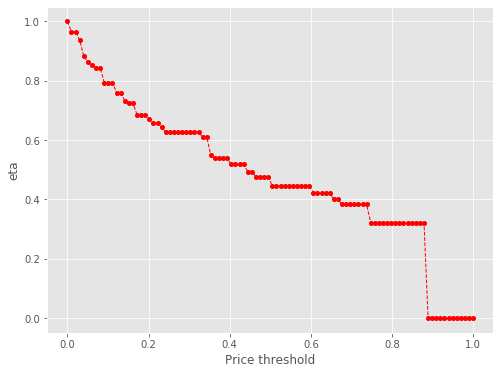

144 47
Number of cells with price above 4.0th percentile:  47


eta =  1.0
eta =  0.9782377875399618
eta =  0.9612937838316136
eta =  0.920613701799623
eta =  0.8861386519714959
eta =  0.8660593706741666
eta =  0.8660593706741666
eta =  0.855945293873098
eta =  0.855945293873098
eta =  0.8043826760210993
eta =  0.8043826760210993
eta =  0.7958793655590976
eta =  0.7706268555235807
eta =  0.7706268555235807
eta =  0.7428415578163757
eta =  0.7335092889720757
eta =  0.7335092889720757
eta =  0.69500269904442
eta =  0.69500269904442
eta =  0.69500269904442
eta =  0.6649585285746505
eta =  0.6649585285746505
eta =  0.6510378190670074
eta =  0.6347530735833051
eta =  0.6347530735833051
eta =  0.6347530735833051
eta =  0.6347530735833051
eta =  0.6347530735833051
eta =  0.6347530735833051
eta =  0.6347530735833051
eta =  0.6347530735833051
eta =  0.6347530735833051
eta =  0.6347530735833051
eta =  0.6184677003988586
eta =  0.5950584525132332
eta =  0.5453002185984605
eta =  0.5453002185984605
eta =  0.5453002185984605
eta =  0.5453002185984605
eta =  0.5

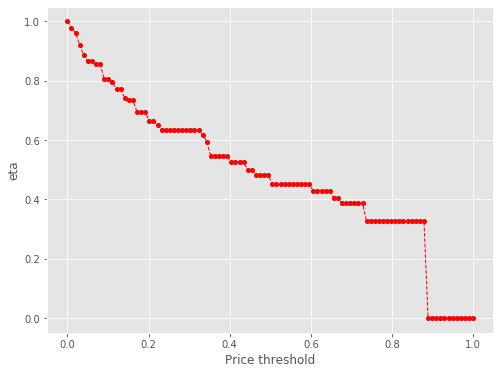

144 45
Number of cells with price above 5.0th percentile:  45


eta =  1.0
eta =  0.9707087728052917
eta =  0.9142777492606646
eta =  0.8953377523018485
eta =  0.8853260236982895
eta =  0.8749869456848516
eta =  0.8749869456848516
eta =  0.8222772481974272
eta =  0.8222772481974272
eta =  0.8222772481974272
eta =  0.8135847701820507
eta =  0.7877704841698318
eta =  0.7593670652249569
eta =  0.7593670652249569
eta =  0.7498271875355369
eta =  0.7498271875355369
eta =  0.7104639668359044
eta =  0.7104639668359044
eta =  0.6948530408604354
eta =  0.6797514234722674
eta =  0.6797514234722674
eta =  0.6655210290988804
eta =  0.6488740075964148
eta =  0.6488740075964148
eta =  0.6488740075964148
eta =  0.6488740075964148
eta =  0.6488740075964148
eta =  0.6488740075964148
eta =  0.6488740075964148
eta =  0.6488740075964148
eta =  0.6488740075964148
eta =  0.6488740075964148
eta =  0.6322263444291591
eta =  0.6082963264071667
eta =  0.5574311537992848
eta =  0.5574311537992848
eta =  0.5574311537992848
eta =  0.5574311537992848
eta =  0.5574311537992848
e

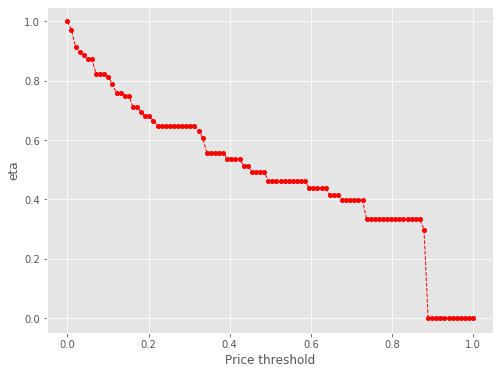

144 43
Number of cells with price above 6.000000000000001th percentile:  43


eta =  1.0
eta =  0.9303930366311765
eta =  0.9111191985676907
eta =  0.9009310007416745
eta =  0.9009310007416745
eta =  0.8904096835635327
eta =  0.8647721255650974
eta =  0.8367709118173183
eta =  0.8367709118173183
eta =  0.8279252180189994
eta =  0.8016559229707542
eta =  0.8016559229707542
eta =  0.772751858287785
eta =  0.7630438283376666
eta =  0.7630438283376666
eta =  0.7229867817039387
eta =  0.7229867817039387
eta =  0.7229867817039387
eta =  0.6917328913999604
eta =  0.6917328913999604
eta =  0.6772516685503164
eta =  0.6603112224997937
eta =  0.6603112224997937
eta =  0.6603112224997937
eta =  0.6603112224997937
eta =  0.6603112224997937
eta =  0.6603112224997937
eta =  0.6603112224997937
eta =  0.6603112224997937
eta =  0.6603112224997937
eta =  0.6603112224997937
eta =  0.6433701234743378
eta =  0.6433701234743378
eta =  0.5787537393423209
eta =  0.5672565741816747
eta =  0.5672565741816747
eta =  0.5672565741816747
eta =  0.5672565741816747
eta =  0.5672565741816747
et

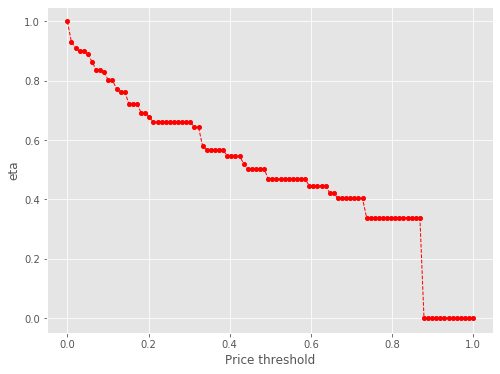

144 39
Number of cells with price above 6.999999999999999th percentile:  39


eta =  1.0
eta =  0.9625521000168311
eta =  0.9407413434985671
eta =  0.9407413434985671
eta =  0.9297551103137932
eta =  0.9297551103137932
eta =  0.873746148301601
eta =  0.873746148301601
eta =  0.8645095809494321
eta =  0.8370794981838237
eta =  0.8370794981838237
eta =  0.8068982205720631
eta =  0.796761212154681
eta =  0.796761212154681
eta =  0.7549341245799657
eta =  0.7549341245799657
eta =  0.7549341245799657
eta =  0.7383460620105724
eta =  0.7222991872430145
eta =  0.7222991872430145
eta =  0.7071780680586803
eta =  0.689489057508578
eta =  0.689489057508578
eta =  0.689489057508578
eta =  0.689489057508578
eta =  0.689489057508578
eta =  0.689489057508578
eta =  0.689489057508578
eta =  0.689489057508578
eta =  0.689489057508578
eta =  0.689489057508578
eta =  0.6717993651298835
eta =  0.6463714925706713
eta =  0.5923225100088162
eta =  0.5923225100088162
eta =  0.5923225100088162
eta =  0.5923225100088162
eta =  0.5923225100088162
eta =  0.570033997107041
eta =  0.5700339

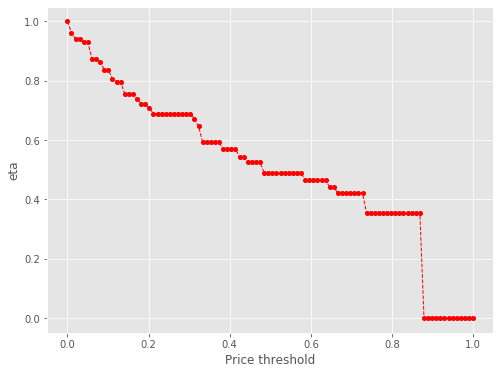

144 36
Number of cells with price above 8.0th percentile:  36


eta =  1.0
eta =  0.9773407002926048
eta =  0.9773407002926048
eta =  0.9659270498682987
eta =  0.9659270498682987
eta =  0.9077390702137814
eta =  0.9077390702137814
eta =  0.898143156026895
eta =  0.8696459112906061
eta =  0.8696459112906061
eta =  0.8382904370142186
eta =  0.8277590502797187
eta =  0.8277590502797187
eta =  0.7843046880961198
eta =  0.7843046880961198
eta =  0.7843046880961198
eta =  0.7670712702176451
eta =  0.7504000949459093
eta =  0.7504000949459093
eta =  0.7346906915961376
eta =  0.7163134935724744
eta =  0.7163134935724744
eta =  0.7163134935724744
eta =  0.7163134935724744
eta =  0.7163134935724744
eta =  0.7163134935724744
eta =  0.7163134935724744
eta =  0.7163134935724744
eta =  0.7163134935724744
eta =  0.7163134935724744
eta =  0.6979355871938115
eta =  0.6715184482578853
eta =  0.6153667006684198
eta =  0.6153667006684198
eta =  0.6153667006684198
eta =  0.6153667006684198
eta =  0.6153667006684198
eta =  0.5922110575594541
eta =  0.5922110575594541
et

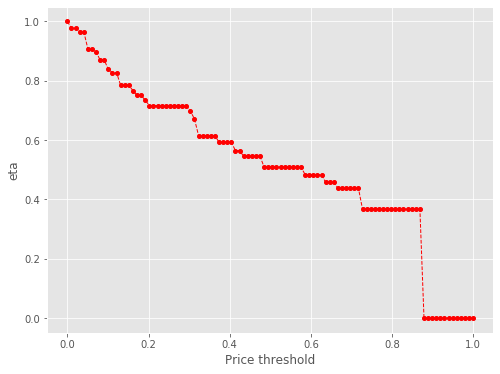

144 34
Number of cells with price above 9.0th percentile:  34


eta =  1.0
eta =  0.9883217281129405
eta =  0.9376427027983637
eta =  0.9287846806564124
eta =  0.9287846806564124
eta =  0.9189662885808408
eta =  0.8898083452681791
eta =  0.8898083452681791
eta =  0.8577259053708126
eta =  0.8469503521462853
eta =  0.8469503521462853
eta =  0.8024885158894004
eta =  0.8024885158894004
eta =  0.8024885158894004
eta =  0.7848555472907172
eta =  0.7677978566954676
eta =  0.7677978566954676
eta =  0.7517242363652507
eta =  0.7329209694817971
eta =  0.7329209694817971
eta =  0.7329209694817971
eta =  0.7329209694817971
eta =  0.7329209694817971
eta =  0.7329209694817971
eta =  0.7329209694817971
eta =  0.7329209694817971
eta =  0.7329209694817971
eta =  0.7329209694817971
eta =  0.7141169778203829
eta =  0.7141169778203829
eta =  0.642395187717897
eta =  0.6296337607593605
eta =  0.6296337607593605
eta =  0.6296337607593605
eta =  0.6296337607593605
eta =  0.6296337607593605
eta =  0.6059412622252944
eta =  0.6059412622252944
eta =  0.6059412622252944
et

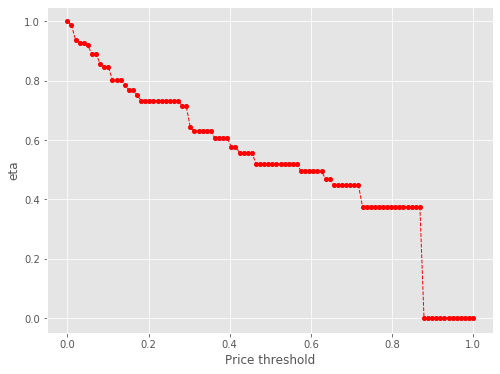

144 34
Number of cells with price above 10.0th percentile:  34


eta =  1.0
eta =  0.9883217281129405
eta =  0.9376427027983637
eta =  0.9287846806564124
eta =  0.9287846806564124
eta =  0.9189662885808408
eta =  0.8898083452681791
eta =  0.8898083452681791
eta =  0.8577259053708126
eta =  0.8469503521462853
eta =  0.8469503521462853
eta =  0.8024885158894004
eta =  0.8024885158894004
eta =  0.8024885158894004
eta =  0.7848555472907172
eta =  0.7677978566954676
eta =  0.7677978566954676
eta =  0.7517242363652507
eta =  0.7329209694817971
eta =  0.7329209694817971
eta =  0.7329209694817971
eta =  0.7329209694817971
eta =  0.7329209694817971
eta =  0.7329209694817971
eta =  0.7329209694817971
eta =  0.7329209694817971
eta =  0.7329209694817971
eta =  0.7329209694817971
eta =  0.7141169778203829
eta =  0.7141169778203829
eta =  0.642395187717897
eta =  0.6296337607593605
eta =  0.6296337607593605
eta =  0.6296337607593605
eta =  0.6296337607593605
eta =  0.6296337607593605
eta =  0.6059412622252944
eta =  0.6059412622252944
eta =  0.6059412622252944
et

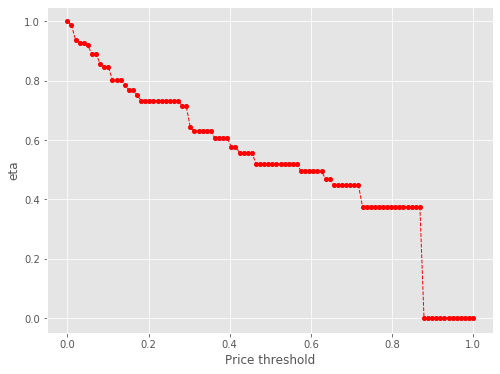

144 33
Number of cells with price above 11.0th percentile:  33


eta =  1.0
eta =  0.9397594469867564
eta =  0.9397594469867564
eta =  0.9298250381841507
eta =  0.9003225568733992
eta =  0.9003225568733992
eta =  0.8678610223499973
eta =  0.8569581423282238
eta =  0.8569581423282238
eta =  0.8357193907330293
eta =  0.8119709332118376
eta =  0.8119709332118376
eta =  0.8119709332118376
eta =  0.7768703599803154
eta =  0.7768703599803154
eta =  0.760606809485572
eta =  0.7415813582093406
eta =  0.7415813582093406
eta =  0.7415813582093406
eta =  0.7415813582093406
eta =  0.7415813582093406
eta =  0.7415813582093406
eta =  0.7415813582093406
eta =  0.7415813582093406
eta =  0.7415813582093406
eta =  0.7415813582093406
eta =  0.7415813582093406
eta =  0.7225551735909798
eta =  0.7225551735909798
eta =  0.6499858997782626
eta =  0.6370736804112932
eta =  0.6370736804112932
eta =  0.6370736804112932
eta =  0.6370736804112932
eta =  0.6370736804112932
eta =  0.6131012250254306
eta =  0.6131012250254306
eta =  0.6131012250254306
eta =  0.6131012250254306
et

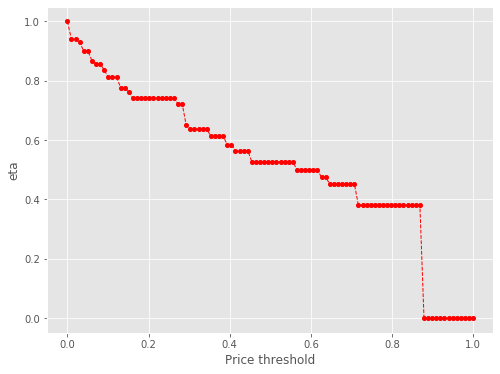

144 33
Number of cells with price above 12.0th percentile:  33


eta =  1.0
eta =  0.9397594469867564
eta =  0.9397594469867564
eta =  0.9298250381841507
eta =  0.9003225568733992
eta =  0.9003225568733992
eta =  0.8678610223499973
eta =  0.8569581423282238
eta =  0.8569581423282238
eta =  0.8357193907330293
eta =  0.8119709332118376
eta =  0.8119709332118376
eta =  0.8119709332118376
eta =  0.7768703599803154
eta =  0.7768703599803154
eta =  0.760606809485572
eta =  0.7415813582093406
eta =  0.7415813582093406
eta =  0.7415813582093406
eta =  0.7415813582093406
eta =  0.7415813582093406
eta =  0.7415813582093406
eta =  0.7415813582093406
eta =  0.7415813582093406
eta =  0.7415813582093406
eta =  0.7415813582093406
eta =  0.7415813582093406
eta =  0.7225551735909798
eta =  0.7225551735909798
eta =  0.6499858997782626
eta =  0.6370736804112932
eta =  0.6370736804112932
eta =  0.6370736804112932
eta =  0.6370736804112932
eta =  0.6370736804112932
eta =  0.6131012250254306
eta =  0.6131012250254306
eta =  0.6131012250254306
eta =  0.6131012250254306
et

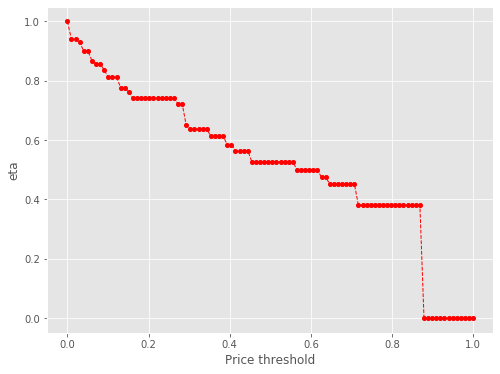

144 29
Number of cells with price above 13.0th percentile:  29


eta =  1.0
eta =  0.9732736933823487
eta =  0.9580351224562759
eta =  0.923492735436399
eta =  0.923492735436399
eta =  0.9118909579211716
eta =  0.9118909579211716
eta =  0.864019974276758
eta =  0.864019974276758
eta =  0.864019974276758
eta =  0.8450349834969562
eta =  0.8266693806284914
eta =  0.8266693806284914
eta =  0.8093633024114637
eta =  0.7891182797759002
eta =  0.7891182797759002
eta =  0.7891182797759002
eta =  0.7891182797759002
eta =  0.7891182797759002
eta =  0.7891182797759002
eta =  0.7891182797759002
eta =  0.7891182797759002
eta =  0.7891182797759002
eta =  0.7891182797759002
eta =  0.7891182797759002
eta =  0.7688724767894378
eta =  0.7688724767894378
eta =  0.6916513602096543
eta =  0.677911440479801
eta =  0.677911440479801
eta =  0.677911440479801
eta =  0.677911440479801
eta =  0.677911440479801
eta =  0.6524023003879106
eta =  0.6524023003879106
eta =  0.6524023003879106
eta =  0.6524023003879106
eta =  0.6221881711799142
eta =  0.6221881711799142
eta =  0.60

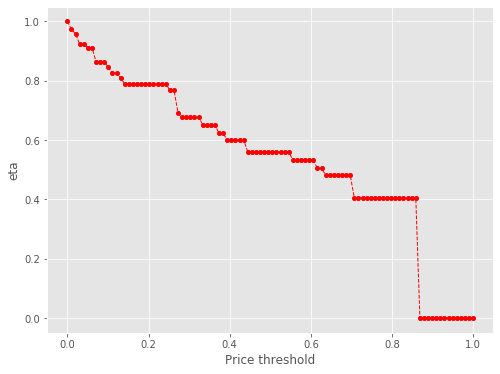

144 29
Number of cells with price above 14.000000000000002th percentile:  29


eta =  1.0
eta =  0.9732736933823487
eta =  0.9580351224562759
eta =  0.923492735436399
eta =  0.923492735436399
eta =  0.9118909579211716
eta =  0.9118909579211716
eta =  0.864019974276758
eta =  0.864019974276758
eta =  0.864019974276758
eta =  0.8450349834969562
eta =  0.8266693806284914
eta =  0.8266693806284914
eta =  0.8093633024114637
eta =  0.7891182797759002
eta =  0.7891182797759002
eta =  0.7891182797759002
eta =  0.7891182797759002
eta =  0.7891182797759002
eta =  0.7891182797759002
eta =  0.7891182797759002
eta =  0.7891182797759002
eta =  0.7891182797759002
eta =  0.7891182797759002
eta =  0.7891182797759002
eta =  0.7688724767894378
eta =  0.7688724767894378
eta =  0.6916513602096543
eta =  0.677911440479801
eta =  0.677911440479801
eta =  0.677911440479801
eta =  0.677911440479801
eta =  0.677911440479801
eta =  0.6524023003879106
eta =  0.6524023003879106
eta =  0.6524023003879106
eta =  0.6524023003879106
eta =  0.6221881711799142
eta =  0.6221881711799142
eta =  0.60

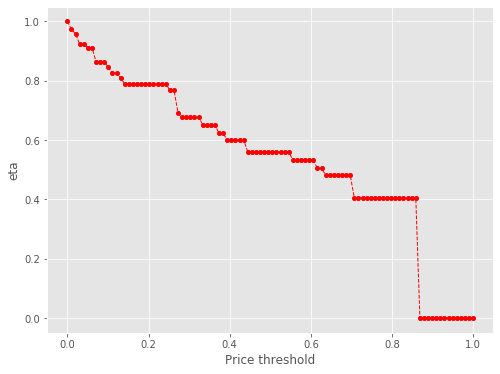

144 28
Number of cells with price above 15.000000000000002th percentile:  28


eta =  1.0
eta =  0.9682709325956992
eta =  0.9682709325956992
eta =  0.9333594888397901
eta =  0.9216337559609835
eta =  0.9216337559609835
eta =  0.8732513105879901
eta =  0.8732513105879901
eta =  0.8732513105879901
eta =  0.8540634809387504
eta =  0.8355016568466047
eta =  0.8355016568466047
eta =  0.8180106775474191
eta =  0.7975493536478324
eta =  0.7975493536478324
eta =  0.7975493536478324
eta =  0.7975493536478324
eta =  0.7975493536478324
eta =  0.7975493536478324
eta =  0.7975493536478324
eta =  0.7975493536478324
eta =  0.7975493536478324
eta =  0.7975493536478324
eta =  0.7975493536478324
eta =  0.7770872410599451
eta =  0.7770872410599451
eta =  0.7227768253624777
eta =  0.6851543615726139
eta =  0.6851543615726139
eta =  0.6851543615726139
eta =  0.6851543615726139
eta =  0.6851543615726139
eta =  0.6593726774907589
eta =  0.6593726774907589
eta =  0.6593726774907589
eta =  0.6593726774907589
eta =  0.6593726774907589
eta =  0.6288357353891098
eta =  0.6288357353891098
e

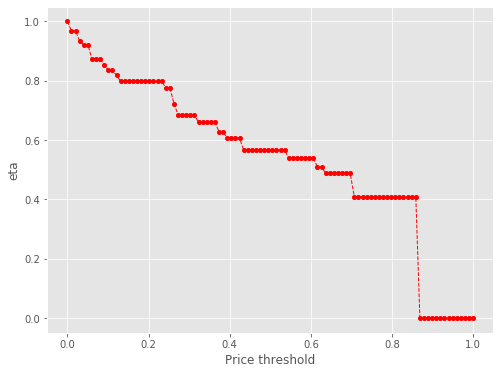

144 26
Number of cells with price above 16.0th percentile:  26


eta =  1.0
eta =  0.9639445504551913
eta =  0.9518345794914108
eta =  0.9518345794914108
eta =  0.9018666998987727
eta =  0.9018666998987727
eta =  0.9018666998987727
eta =  0.9018666998987727
eta =  0.8628800356598827
eta =  0.8628800356598827
eta =  0.8448158981231949
eta =  0.8448158981231949
eta =  0.8236840813859777
eta =  0.8236840813859777
eta =  0.8236840813859777
eta =  0.8236840813859777
eta =  0.8236840813859777
eta =  0.8236840813859777
eta =  0.8236840813859777
eta =  0.8236840813859777
eta =  0.8236840813859777
eta =  0.8236840813859777
eta =  0.8236840813859777
eta =  0.8025514501160982
eta =  0.7721745592540212
eta =  0.721947811721507
eta =  0.7076060413544394
eta =  0.7076060413544394
eta =  0.7076060413544394
eta =  0.7076060413544394
eta =  0.7076060413544394
eta =  0.6809795226663894
eta =  0.6809795226663894
eta =  0.6809795226663894
eta =  0.6809795226663894
eta =  0.649441921904393
eta =  0.649441921904393
eta =  0.6270134394552785
eta =  0.6270134394552785
eta 

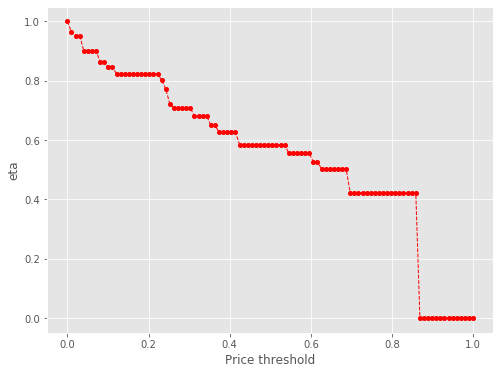

144 24
Number of cells with price above 17.0th percentile:  24


eta =  1.0
eta =  0.9874370668332924
eta =  0.9874370668332924
eta =  0.9356001851692564
eta =  0.9356001851692564
eta =  0.9356001851692564
eta =  0.9150423723665054
eta =  0.8951552610079239
eta =  0.8951552610079239
eta =  0.8764154512043854
eta =  0.854493218512434
eta =  0.854493218512434
eta =  0.854493218512434
eta =  0.854493218512434
eta =  0.854493218512434
eta =  0.854493218512434
eta =  0.854493218512434
eta =  0.854493218512434
eta =  0.854493218512434
eta =  0.854493218512434
eta =  0.854493218512434
eta =  0.8325701408209834
eta =  0.8325701408209834
eta =  0.8010570306034585
eta =  0.734073387333634
eta =  0.734073387333634
eta =  0.734073387333634
eta =  0.734073387333634
eta =  0.734073387333634
eta =  0.734073387333634
eta =  0.7064509284738619
eta =  0.7064509284738619
eta =  0.7064509284738619
eta =  0.7064509284738619
eta =  0.6737336930819466
eta =  0.6737336930819466
eta =  0.6504662941029045
eta =  0.6504662941029045
eta =  0.6504662941029045
eta =  0.650466294

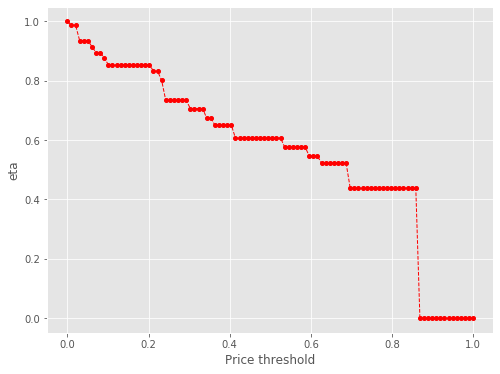

144 24
Number of cells with price above 18.000000000000004th percentile:  24


eta =  1.0
eta =  0.9874370668332924
eta =  0.9874370668332924
eta =  0.9356001851692564
eta =  0.9356001851692564
eta =  0.9356001851692564
eta =  0.9150423723665054
eta =  0.8951552610079239
eta =  0.8951552610079239
eta =  0.8764154512043854
eta =  0.854493218512434
eta =  0.854493218512434
eta =  0.854493218512434
eta =  0.854493218512434
eta =  0.854493218512434
eta =  0.854493218512434
eta =  0.854493218512434
eta =  0.854493218512434
eta =  0.854493218512434
eta =  0.854493218512434
eta =  0.854493218512434
eta =  0.8325701408209834
eta =  0.8325701408209834
eta =  0.8010570306034585
eta =  0.734073387333634
eta =  0.734073387333634
eta =  0.734073387333634
eta =  0.734073387333634
eta =  0.734073387333634
eta =  0.734073387333634
eta =  0.7064509284738619
eta =  0.7064509284738619
eta =  0.7064509284738619
eta =  0.7064509284738619
eta =  0.6737336930819466
eta =  0.6737336930819466
eta =  0.6504662941029045
eta =  0.6504662941029045
eta =  0.6504662941029045
eta =  0.650466294

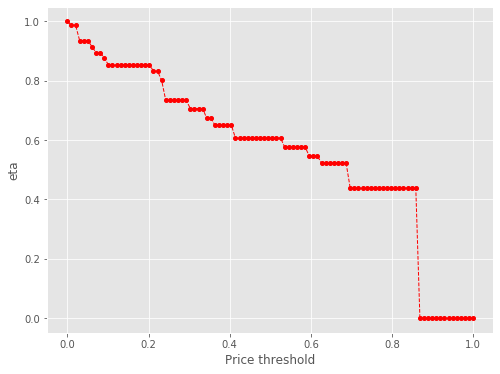

144 23
Number of cells with price above 19.0th percentile:  23


eta =  1.0
eta =  0.9475036096930443
eta =  0.9475036096930443
eta =  0.9475036096930443
eta =  0.9266842445980314
eta =  0.9065441141263655
eta =  0.9065441141263655
eta =  0.8875658820617773
eta =  0.8653647378792362
eta =  0.8653647378792362
eta =  0.8653647378792362
eta =  0.8653647378792362
eta =  0.8653647378792362
eta =  0.8653647378792362
eta =  0.8653647378792362
eta =  0.8653647378792362
eta =  0.8653647378792362
eta =  0.8653647378792362
eta =  0.8653647378792362
eta =  0.8653647378792362
eta =  0.8431627379464629
eta =  0.8112486937242955
eta =  0.7584803360550968
eta =  0.743412833070775
eta =  0.743412833070775
eta =  0.743412833070775
eta =  0.743412833070775
eta =  0.743412833070775
eta =  0.7154389400627301
eta =  0.7154389400627301
eta =  0.7154389400627301
eta =  0.7154389400627301
eta =  0.7154389400627301
eta =  0.682305450860386
eta =  0.682305450860386
eta =  0.6587420261515479
eta =  0.6587420261515479
eta =  0.6587420261515479
eta =  0.6587420261515479
eta =  0

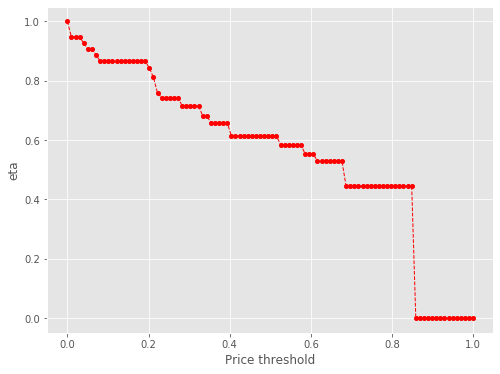

144 22
Number of cells with price above 20.0th percentile:  22


eta =  1.0
eta =  0.9715832158682338
eta =  0.9715832158682338
eta =  0.9715832158682338
eta =  0.9295827865127122
eta =  0.9295827865127122
eta =  0.9295827865127122
eta =  0.9101222466771122
eta =  0.8873568884872732
eta =  0.8873568884872732
eta =  0.8873568884872732
eta =  0.8873568884872732
eta =  0.8873568884872732
eta =  0.8873568884872732
eta =  0.8873568884872732
eta =  0.8873568884872732
eta =  0.8873568884872732
eta =  0.8873568884872732
eta =  0.8873568884872732
eta =  0.8645906527993918
eta =  0.8645906527993918
eta =  0.8318655534968367
eta =  0.7777561547401031
eta =  0.7623057302194469
eta =  0.7623057302194469
eta =  0.7623057302194469
eta =  0.7623057302194469
eta =  0.7623057302194469
eta =  0.733620916092021
eta =  0.733620916092021
eta =  0.733620916092021
eta =  0.733620916092021
eta =  0.733620916092021
eta =  0.6996453811570376
eta =  0.6996453811570376
eta =  0.6754831218038531
eta =  0.6754831218038531
eta =  0.6754831218038531
eta =  0.6754831218038531
eta = 

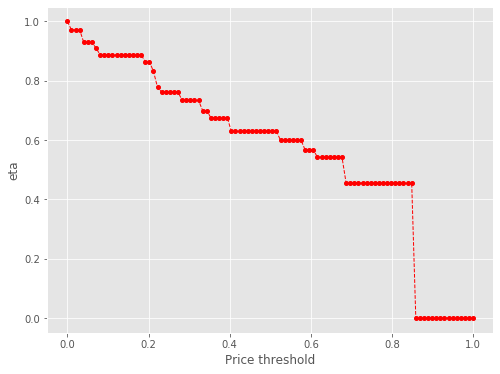

144 21
Number of cells with price above 21.000000000000004th percentile:  21


eta =  1.0
eta =  0.9567711456213364
eta =  0.9567711456213364
eta =  0.9367414255543738
eta =  0.9367414255543738
eta =  0.9133102280840725
eta =  0.9133102280840725
eta =  0.9133102280840725
eta =  0.9133102280840725
eta =  0.9133102280840725
eta =  0.9133102280840725
eta =  0.9133102280840725
eta =  0.9133102280840725
eta =  0.9133102280840725
eta =  0.9133102280840725
eta =  0.9133102280840725
eta =  0.9133102280840725
eta =  0.8898781274507399
eta =  0.8898781274507399
eta =  0.8005039012999814
eta =  0.7846015840632131
eta =  0.7846015840632131
eta =  0.7846015840632131
eta =  0.7846015840632131
eta =  0.7846015840632131
eta =  0.7846015840632131
eta =  0.7550777989062285
eta =  0.7550777989062285
eta =  0.7550777989062285
eta =  0.7550777989062285
eta =  0.7550777989062285
eta =  0.7201085503847604
eta =  0.7201085503847604
eta =  0.6952395953034476
eta =  0.6952395953034476
eta =  0.6952395953034476
eta =  0.6952395953034476
eta =  0.6952395953034476
eta =  0.6487017970411487
e

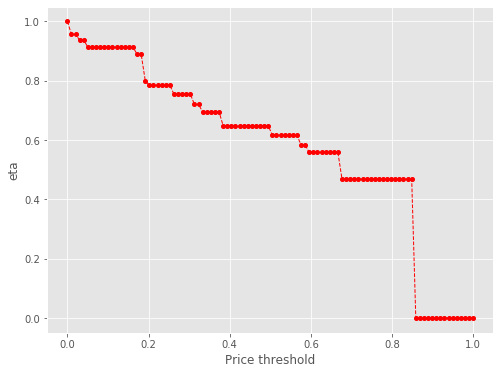

144 21
Number of cells with price above 22.0th percentile:  21


eta =  1.0
eta =  0.9567711456213364
eta =  0.9567711456213364
eta =  0.9367414255543738
eta =  0.9367414255543738
eta =  0.9133102280840725
eta =  0.9133102280840725
eta =  0.9133102280840725
eta =  0.9133102280840725
eta =  0.9133102280840725
eta =  0.9133102280840725
eta =  0.9133102280840725
eta =  0.9133102280840725
eta =  0.9133102280840725
eta =  0.9133102280840725
eta =  0.9133102280840725
eta =  0.9133102280840725
eta =  0.8898781274507399
eta =  0.8898781274507399
eta =  0.8005039012999814
eta =  0.7846015840632131
eta =  0.7846015840632131
eta =  0.7846015840632131
eta =  0.7846015840632131
eta =  0.7846015840632131
eta =  0.7846015840632131
eta =  0.7550777989062285
eta =  0.7550777989062285
eta =  0.7550777989062285
eta =  0.7550777989062285
eta =  0.7550777989062285
eta =  0.7201085503847604
eta =  0.7201085503847604
eta =  0.6952395953034476
eta =  0.6952395953034476
eta =  0.6952395953034476
eta =  0.6952395953034476
eta =  0.6952395953034476
eta =  0.6487017970411487
e

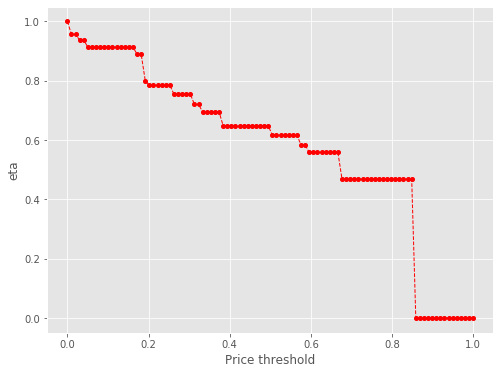

144 20
Number of cells with price above 23.0th percentile:  20


eta =  1.0
eta =  0.9782664585169438
eta =  0.9782664585169438
eta =  0.9577867404520053
eta =  0.9338291256420423
eta =  0.9338291256420423
eta =  0.9338291256420423
eta =  0.9338291256420423
eta =  0.9338291256420423
eta =  0.9338291256420423
eta =  0.9338291256420423
eta =  0.9338291256420423
eta =  0.9338291256420423
eta =  0.9338291256420423
eta =  0.9338291256420423
eta =  0.9338291256420423
eta =  0.9098705873781229
eta =  0.9098705873781229
eta =  0.8754316245834001
eta =  0.8022288469933421
eta =  0.8022288469933421
eta =  0.8022288469933421
eta =  0.8022288469933421
eta =  0.8022288469933421
eta =  0.8022288469933421
eta =  0.7720417652865854
eta =  0.7720417652865854
eta =  0.7720417652865854
eta =  0.7720417652865854
eta =  0.7720417652865854
eta =  0.7362868796332565
eta =  0.7362868796332565
eta =  0.7108592058099477
eta =  0.7108592058099477
eta =  0.7108592058099477
eta =  0.7108592058099477
eta =  0.7108592058099477
eta =  0.6632758654243325
eta =  0.6632758654243325
e

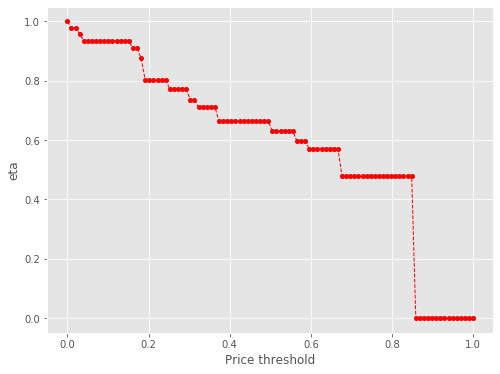

144 19
Number of cells with price above 24.000000000000004th percentile:  19


eta =  1.0
eta =  0.9790652966922878
eta =  0.9545754303563994
eta =  0.9545754303563994
eta =  0.9545754303563994
eta =  0.9545754303563994
eta =  0.9545754303563994
eta =  0.9545754303563994
eta =  0.9545754303563994
eta =  0.9545754303563994
eta =  0.9545754303563994
eta =  0.9545754303563994
eta =  0.9545754303563994
eta =  0.9545754303563994
eta =  0.9300846200507483
eta =  0.9300846200507483
eta =  0.8948805480978651
eta =  0.8200514696267155
eta =  0.8200514696267155
eta =  0.8200514696267155
eta =  0.8200514696267155
eta =  0.8200514696267155
eta =  0.8200514696267155
eta =  0.789193740176888
eta =  0.789193740176888
eta =  0.789193740176888
eta =  0.789193740176888
eta =  0.789193740176888
eta =  0.7526445103202972
eta =  0.7526445103202972
eta =  0.7526445103202972
eta =  0.7266519255782451
eta =  0.7266519255782451
eta =  0.7266519255782451
eta =  0.7266519255782451
eta =  0.7266519255782451
eta =  0.6780114555188385
eta =  0.6780114555188385
eta =  0.6780114555188385
eta = 

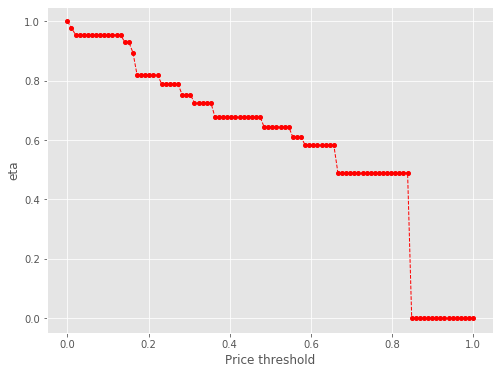

144 19
Number of cells with price above 25.0th percentile:  19


eta =  1.0
eta =  0.9790652966922878
eta =  0.9545754303563994
eta =  0.9545754303563994
eta =  0.9545754303563994
eta =  0.9545754303563994
eta =  0.9545754303563994
eta =  0.9545754303563994
eta =  0.9545754303563994
eta =  0.9545754303563994
eta =  0.9545754303563994
eta =  0.9545754303563994
eta =  0.9545754303563994
eta =  0.9545754303563994
eta =  0.9300846200507483
eta =  0.9300846200507483
eta =  0.8948805480978651
eta =  0.8200514696267155
eta =  0.8200514696267155
eta =  0.8200514696267155
eta =  0.8200514696267155
eta =  0.8200514696267155
eta =  0.8200514696267155
eta =  0.789193740176888
eta =  0.789193740176888
eta =  0.789193740176888
eta =  0.789193740176888
eta =  0.789193740176888
eta =  0.7526445103202972
eta =  0.7526445103202972
eta =  0.7526445103202972
eta =  0.7266519255782451
eta =  0.7266519255782451
eta =  0.7266519255782451
eta =  0.7266519255782451
eta =  0.7266519255782451
eta =  0.6780114555188385
eta =  0.6780114555188385
eta =  0.6780114555188385
eta = 

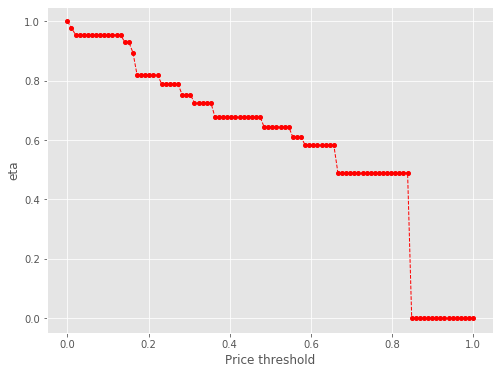

144 18
Number of cells with price above 26.0th percentile:  18


eta =  1.0
eta =  0.9749864831093228
eta =  0.9749864831093228
eta =  0.9749864831093228
eta =  0.9749864831093228
eta =  0.9749864831093228
eta =  0.9749864831093228
eta =  0.9749864831093228
eta =  0.9749864831093228
eta =  0.9749864831093228
eta =  0.9749864831093228
eta =  0.9749864831093228
eta =  0.9749864831093228
eta =  0.9499720020646042
eta =  0.9499720020646042
eta =  0.8835787174924489
eta =  0.8375860858281967
eta =  0.8375860858281967
eta =  0.8375860858281967
eta =  0.8375860858281967
eta =  0.8375860858281967
eta =  0.8375860858281967
eta =  0.8060685460337843
eta =  0.8060685460337843
eta =  0.8060685460337843
eta =  0.8060685460337843
eta =  0.8060685460337843
eta =  0.7687378082575907
eta =  0.7687378082575907
eta =  0.7687378082575907
eta =  0.7421894413306183
eta =  0.7421894413306183
eta =  0.7421894413306183
eta =  0.7421894413306183
eta =  0.7421894413306183
eta =  0.6925089243888621
eta =  0.6925089243888621
eta =  0.6925089243888621
eta =  0.6925089243888621
e

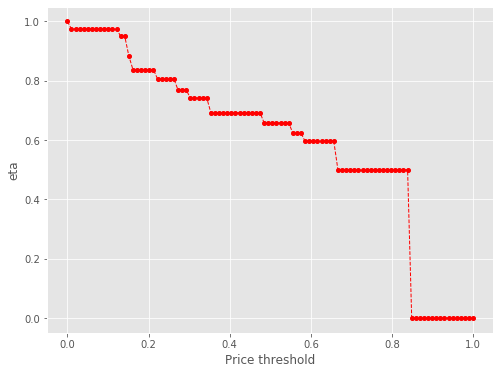

144 17
Number of cells with price above 27.0th percentile:  17


eta =  1.0
eta =  0.9743437663207954
eta =  0.9743437663207954
eta =  0.9062471457805589
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.7884599649074254
eta =  0.7884599649074254
eta =  0.7884599649074254
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
e

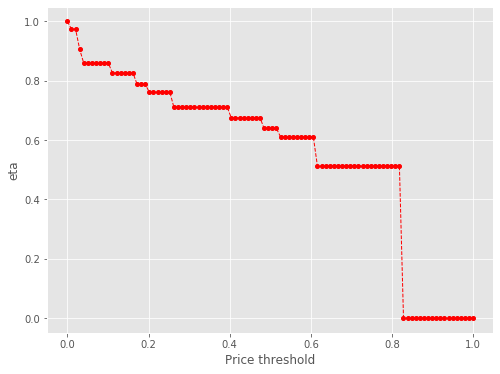

144 17
Number of cells with price above 28.000000000000004th percentile:  17


eta =  1.0
eta =  0.9743437663207954
eta =  0.9743437663207954
eta =  0.9062471457805589
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.7884599649074254
eta =  0.7884599649074254
eta =  0.7884599649074254
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
e

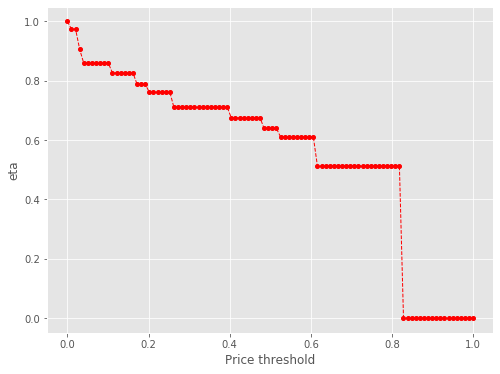

144 17
Number of cells with price above 29.000000000000004th percentile:  17


eta =  1.0
eta =  0.9743437663207954
eta =  0.9743437663207954
eta =  0.9062471457805589
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.7884599649074254
eta =  0.7884599649074254
eta =  0.7884599649074254
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
e

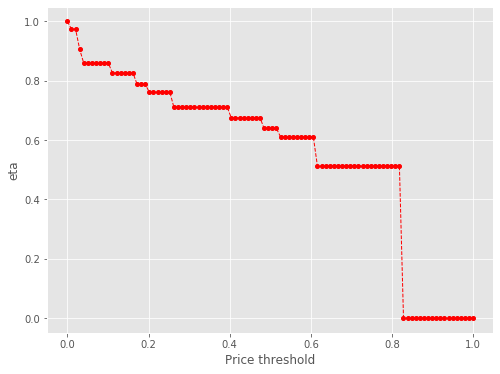

144 17
Number of cells with price above 30.0th percentile:  17


eta =  1.0
eta =  0.9743437663207954
eta =  0.9743437663207954
eta =  0.9062471457805589
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.7884599649074254
eta =  0.7884599649074254
eta =  0.7884599649074254
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
e

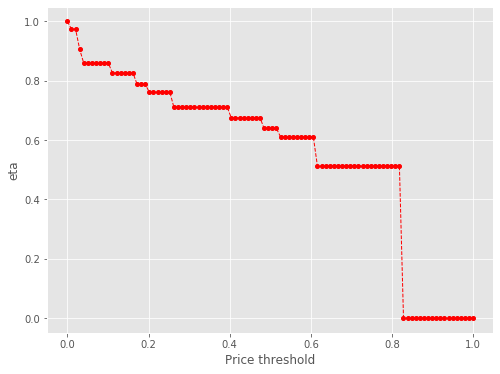

144 17
Number of cells with price above 31.0th percentile:  17


eta =  1.0
eta =  0.9743437663207954
eta =  0.9743437663207954
eta =  0.9062471457805589
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.7884599649074254
eta =  0.7884599649074254
eta =  0.7884599649074254
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
e

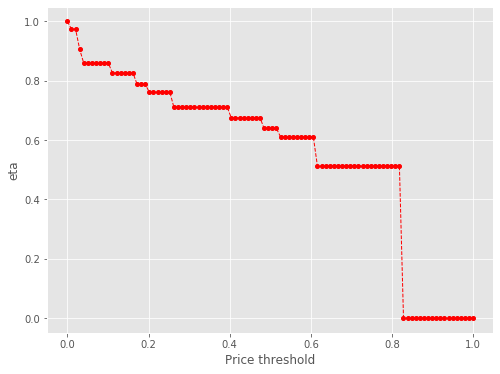

144 17
Number of cells with price above 32.0th percentile:  17


eta =  1.0
eta =  0.9743437663207954
eta =  0.9743437663207954
eta =  0.9062471457805589
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.7884599649074254
eta =  0.7884599649074254
eta =  0.7884599649074254
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
e

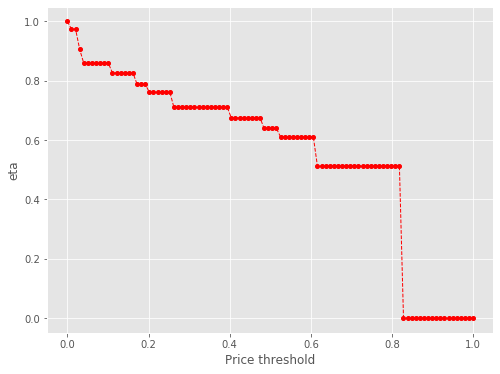

144 17
Number of cells with price above 33.0th percentile:  17


eta =  1.0
eta =  0.9743437663207954
eta =  0.9743437663207954
eta =  0.9062471457805589
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.7884599649074254
eta =  0.7884599649074254
eta =  0.7884599649074254
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
e

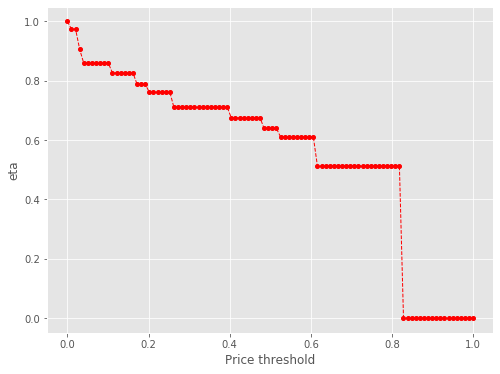

144 17
Number of cells with price above 34.0th percentile:  17


eta =  1.0
eta =  0.9743437663207954
eta =  0.9743437663207954
eta =  0.9062471457805589
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.7884599649074254
eta =  0.7884599649074254
eta =  0.7884599649074254
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
e

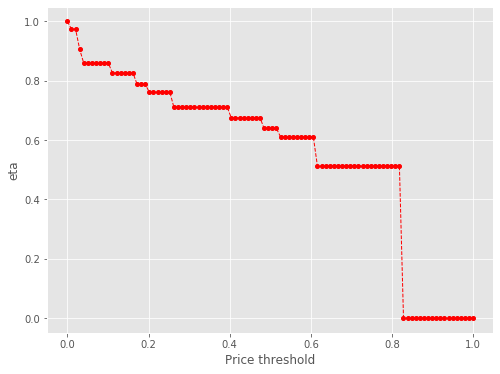

144 17
Number of cells with price above 35.0th percentile:  17


eta =  1.0
eta =  0.9743437663207954
eta =  0.9743437663207954
eta =  0.9062471457805589
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8590745618924445
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.8267484318994419
eta =  0.7884599649074254
eta =  0.7884599649074254
eta =  0.7884599649074254
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7612304931281785
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
eta =  0.7102754103630099
e

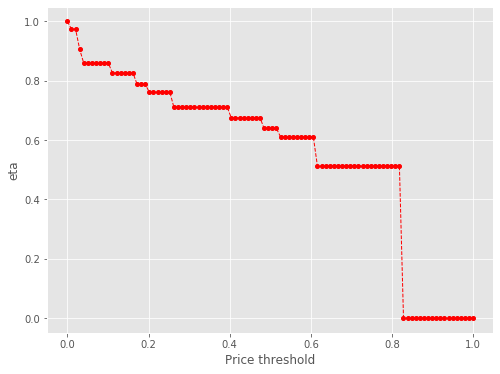

144 16
Number of cells with price above 36.00000000000001th percentile:  16


eta =  1.0
eta =  0.8995657681723322
eta =  0.8816955489296994
eta =  0.8816955489296994
eta =  0.8816955489296994
eta =  0.8816955489296994
eta =  0.8816955489296994
eta =  0.8816955489296994
eta =  0.8816955489296994
eta =  0.8485182134651653
eta =  0.8485182134651653
eta =  0.8485182134651653
eta =  0.8485182134651653
eta =  0.8485182134651653
eta =  0.8485182134651653
eta =  0.809221541884254
eta =  0.809221541884254
eta =  0.809221541884254
eta =  0.7812750688626554
eta =  0.7812750688626554
eta =  0.7812750688626554
eta =  0.7812750688626554
eta =  0.7812750688626554
eta =  0.7812750688626554
eta =  0.7289782466049637
eta =  0.7289782466049637
eta =  0.7289782466049637
eta =  0.7289782466049637
eta =  0.7289782466049637
eta =  0.7289782466049637
eta =  0.7289782466049637
eta =  0.7289782466049637
eta =  0.7289782466049637
eta =  0.7289782466049637
eta =  0.7289782466049637
eta =  0.7289782466049637
eta =  0.7289782466049637
eta =  0.7289782466049637
eta =  0.7289782466049637
eta 

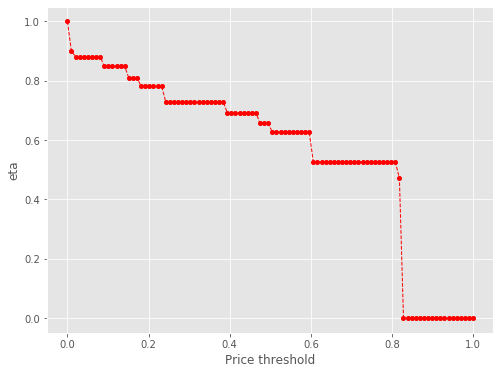

144 15
Number of cells with price above 37.0th percentile:  15


eta =  1.0
eta =  0.9163809308066821
eta =  0.9163809308066821
eta =  0.9163809308066821
eta =  0.9163809308066821
eta =  0.9163809308066821
eta =  0.9163809308066821
eta =  0.9163809308066821
eta =  0.9163809308066821
eta =  0.8818984185703643
eta =  0.8818984185703643
eta =  0.8818984185703643
eta =  0.8818984185703643
eta =  0.8818984185703643
eta =  0.8818984185703643
eta =  0.8410558391509334
eta =  0.8410558391509334
eta =  0.8120099683949971
eta =  0.8120099683949971
eta =  0.8120099683949971
eta =  0.8120099683949971
eta =  0.8120099683949971
eta =  0.8120099683949971
eta =  0.8120099683949971
eta =  0.7576558200533042
eta =  0.7576558200533042
eta =  0.7576558200533042
eta =  0.7576558200533042
eta =  0.7576558200533042
eta =  0.7576558200533042
eta =  0.7576558200533042
eta =  0.7576558200533042
eta =  0.7576558200533042
eta =  0.7576558200533042
eta =  0.7576558200533042
eta =  0.7576558200533042
eta =  0.7576558200533042
eta =  0.7576558200533042
eta =  0.7576558200533042
e

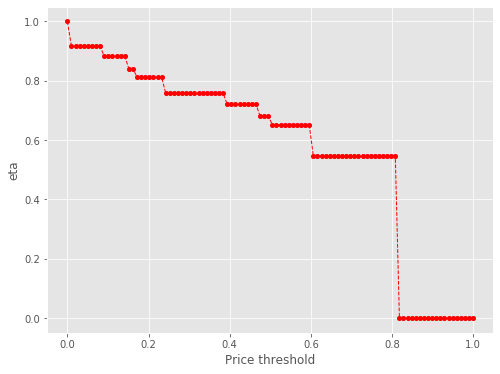

144 12
Number of cells with price above 38.0th percentile:  12


eta =  1.0
eta =  0.9623709845140894
eta =  0.9623709845140894
eta =  0.9623709845140894
eta =  0.9623709845140894
eta =  0.9623709845140894
eta =  0.9623709845140894
eta =  0.9178015505086508
eta =  0.9178015505086508
eta =  0.9178015505086508
eta =  0.8861052659402152
eta =  0.8861052659402152
eta =  0.8861052659402152
eta =  0.8861052659402152
eta =  0.8861052659402152
eta =  0.8861052659402152
eta =  0.8861052659402152
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.7858535621959267
eta =  0.7858535621959267
eta =  0.7858535621959267
eta =  0.7858535621959267
eta =  0.7858535621959267
eta =  0.7858535621959267
e

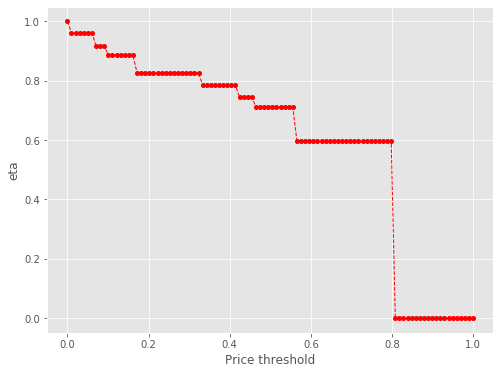

144 12
Number of cells with price above 39.0th percentile:  12


eta =  1.0
eta =  0.9623709845140894
eta =  0.9623709845140894
eta =  0.9623709845140894
eta =  0.9623709845140894
eta =  0.9623709845140894
eta =  0.9623709845140894
eta =  0.9178015505086508
eta =  0.9178015505086508
eta =  0.9178015505086508
eta =  0.8861052659402152
eta =  0.8861052659402152
eta =  0.8861052659402152
eta =  0.8861052659402152
eta =  0.8861052659402152
eta =  0.8861052659402152
eta =  0.8861052659402152
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.7858535621959267
eta =  0.7858535621959267
eta =  0.7858535621959267
eta =  0.7858535621959267
eta =  0.7858535621959267
eta =  0.7858535621959267
e

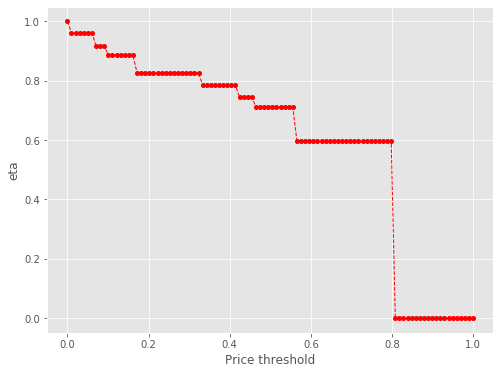

144 12
Number of cells with price above 40.0th percentile:  12


eta =  1.0
eta =  0.9623709845140894
eta =  0.9623709845140894
eta =  0.9623709845140894
eta =  0.9623709845140894
eta =  0.9623709845140894
eta =  0.9623709845140894
eta =  0.9178015505086508
eta =  0.9178015505086508
eta =  0.9178015505086508
eta =  0.8861052659402152
eta =  0.8861052659402152
eta =  0.8861052659402152
eta =  0.8861052659402152
eta =  0.8861052659402152
eta =  0.8861052659402152
eta =  0.8861052659402152
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.7858535621959267
eta =  0.7858535621959267
eta =  0.7858535621959267
eta =  0.7858535621959267
eta =  0.7858535621959267
eta =  0.7858535621959267
e

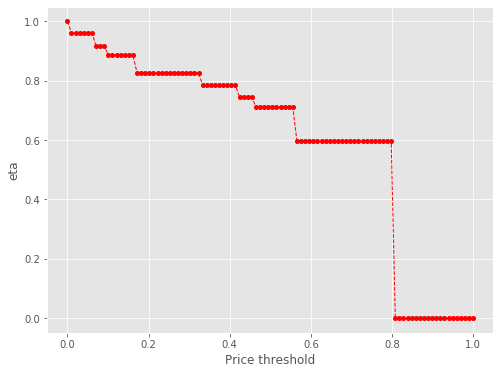

144 12
Number of cells with price above 41.0th percentile:  12


eta =  1.0
eta =  0.9623709845140894
eta =  0.9623709845140894
eta =  0.9623709845140894
eta =  0.9623709845140894
eta =  0.9623709845140894
eta =  0.9623709845140894
eta =  0.9178015505086508
eta =  0.9178015505086508
eta =  0.9178015505086508
eta =  0.8861052659402152
eta =  0.8861052659402152
eta =  0.8861052659402152
eta =  0.8861052659402152
eta =  0.8861052659402152
eta =  0.8861052659402152
eta =  0.8861052659402152
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.7858535621959267
eta =  0.7858535621959267
eta =  0.7858535621959267
eta =  0.7858535621959267
eta =  0.7858535621959267
eta =  0.7858535621959267
e

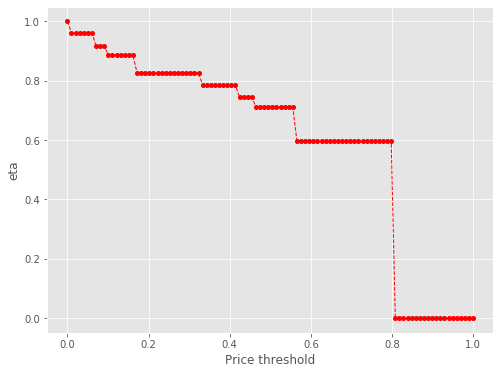

144 12
Number of cells with price above 42.00000000000001th percentile:  12


eta =  1.0
eta =  0.9623709845140894
eta =  0.9623709845140894
eta =  0.9623709845140894
eta =  0.9623709845140894
eta =  0.9623709845140894
eta =  0.9623709845140894
eta =  0.9178015505086508
eta =  0.9178015505086508
eta =  0.9178015505086508
eta =  0.8861052659402152
eta =  0.8861052659402152
eta =  0.8861052659402152
eta =  0.8861052659402152
eta =  0.8861052659402152
eta =  0.8861052659402152
eta =  0.8861052659402152
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.8267913425330081
eta =  0.7858535621959267
eta =  0.7858535621959267
eta =  0.7858535621959267
eta =  0.7858535621959267
eta =  0.7858535621959267
eta =  0.7858535621959267
e

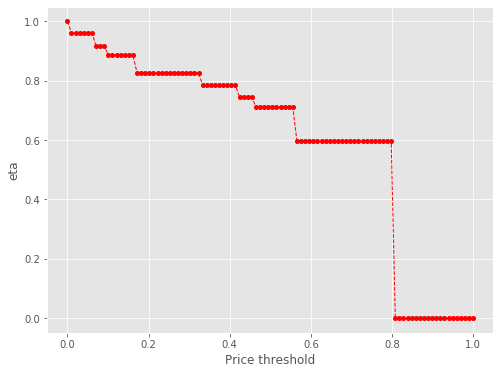

144 11
Number of cells with price above 43.0th percentile:  11


eta =  1.0
eta =  0.9536878867685914
eta =  0.9536878867685914
eta =  0.9536878867685914
eta =  0.920752267263771
eta =  0.920752267263771
eta =  0.920752267263771
eta =  0.920752267263771
eta =  0.920752267263771
eta =  0.920752267263771
eta =  0.920752267263771
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8165806896107866
eta =  0.8165806896107866
eta =  0.8165806896107866
eta =  0.8165806896107866
eta =  0.8165806896107866
eta =  0.8165806896107866
eta =  0.8165806896107866
eta =  0.8165806896107866
eta =  0.8165806896107866
eta =  0.8165806896107866
eta =  0.7730893911715914
eta =  0

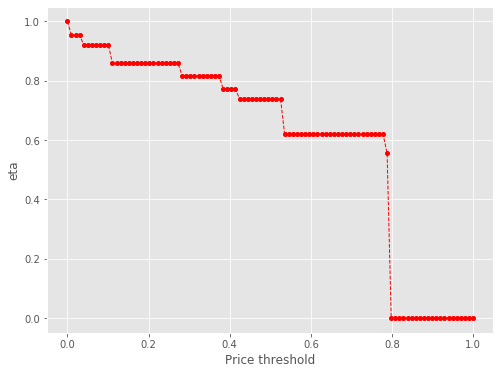

144 11
Number of cells with price above 44.0th percentile:  11


eta =  1.0
eta =  0.9536878867685914
eta =  0.9536878867685914
eta =  0.9536878867685914
eta =  0.920752267263771
eta =  0.920752267263771
eta =  0.920752267263771
eta =  0.920752267263771
eta =  0.920752267263771
eta =  0.920752267263771
eta =  0.920752267263771
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8165806896107866
eta =  0.8165806896107866
eta =  0.8165806896107866
eta =  0.8165806896107866
eta =  0.8165806896107866
eta =  0.8165806896107866
eta =  0.8165806896107866
eta =  0.8165806896107866
eta =  0.8165806896107866
eta =  0.8165806896107866
eta =  0.7730893911715914
eta =  0

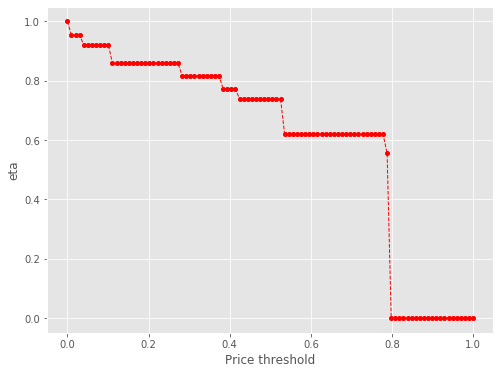

144 11
Number of cells with price above 45.0th percentile:  11


eta =  1.0
eta =  0.9536878867685914
eta =  0.9536878867685914
eta =  0.9536878867685914
eta =  0.920752267263771
eta =  0.920752267263771
eta =  0.920752267263771
eta =  0.920752267263771
eta =  0.920752267263771
eta =  0.920752267263771
eta =  0.920752267263771
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8165806896107866
eta =  0.8165806896107866
eta =  0.8165806896107866
eta =  0.8165806896107866
eta =  0.8165806896107866
eta =  0.8165806896107866
eta =  0.8165806896107866
eta =  0.8165806896107866
eta =  0.8165806896107866
eta =  0.8165806896107866
eta =  0.7730893911715914
eta =  0

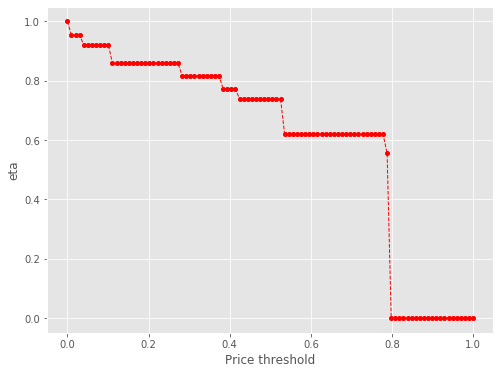

144 11
Number of cells with price above 46.0th percentile:  11


eta =  1.0
eta =  0.9536878867685914
eta =  0.9536878867685914
eta =  0.9536878867685914
eta =  0.920752267263771
eta =  0.920752267263771
eta =  0.920752267263771
eta =  0.920752267263771
eta =  0.920752267263771
eta =  0.920752267263771
eta =  0.920752267263771
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8591191503456052
eta =  0.8165806896107866
eta =  0.8165806896107866
eta =  0.8165806896107866
eta =  0.8165806896107866
eta =  0.8165806896107866
eta =  0.8165806896107866
eta =  0.8165806896107866
eta =  0.8165806896107866
eta =  0.8165806896107866
eta =  0.8165806896107866
eta =  0.7730893911715914
eta =  0

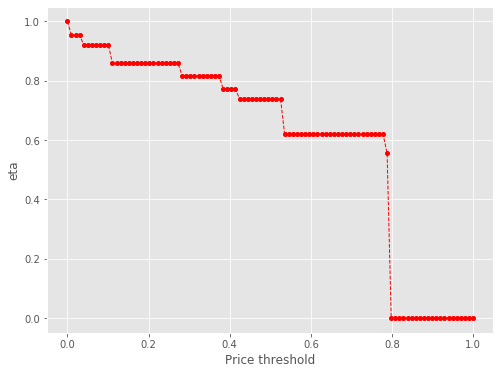

144 10
Number of cells with price above 47.0th percentile:  10


eta =  1.0
eta =  0.9654649912599633
eta =  0.9654649912599633
eta =  0.9654649912599633
eta =  0.9654649912599633
eta =  0.9654649912599633
eta =  0.9654649912599633
eta =  0.9654649912599633
eta =  0.9008389036549304
eta =  0.9008389036549304
eta =  0.9008389036549304
eta =  0.9008389036549304
eta =  0.9008389036549304
eta =  0.9008389036549304
eta =  0.9008389036549304
eta =  0.9008389036549304
eta =  0.9008389036549304
eta =  0.9008389036549304
eta =  0.9008389036549304
eta =  0.9008389036549304
eta =  0.9008389036549304
eta =  0.9008389036549304
eta =  0.9008389036549304
eta =  0.9008389036549304
eta =  0.9008389036549304
eta =  0.9008389036549304
eta =  0.856234729349065
eta =  0.856234729349065
eta =  0.856234729349065
eta =  0.856234729349065
eta =  0.856234729349065
eta =  0.856234729349065
eta =  0.856234729349065
eta =  0.856234729349065
eta =  0.856234729349065
eta =  0.856234729349065
eta =  0.8106314465113663
eta =  0.8106314465113663
eta =  0.8106314465113663
eta =  0.81

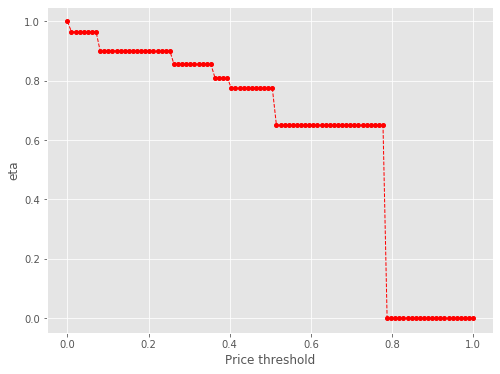

144 9
Number of cells with price above 48.00000000000001th percentile:  9


eta =  1.0
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.8868625347374333
eta =  0.8868625347374333
eta =  0.8868625347374333
eta =  0.8868625347374333
eta =  0.8868625347374333
eta =  0.8868625347374333
eta =  0.8868625347374333
eta =  0.8868625347374333
eta =  0.8868625347374333
eta =  0.8868625347374333
eta =  0.8868625347374333
eta =  0.839628007074048
eta =  0.839628007074048
eta =  0.839628007074048
eta =  0.839628007074048
eta =  0.802777004032492
eta =  0.802777004032492
eta =  0.802777004032492
eta =  0.802777004032492
eta =  0.

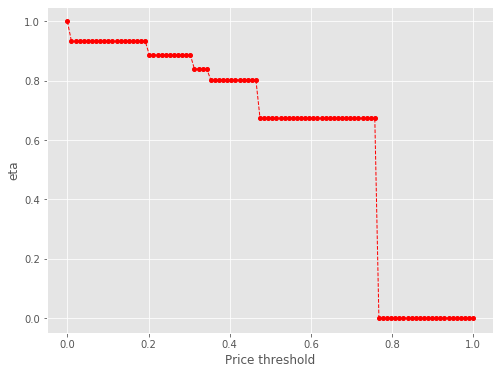

144 9
Number of cells with price above 49.0th percentile:  9


eta =  1.0
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.8868625347374333
eta =  0.8868625347374333
eta =  0.8868625347374333
eta =  0.8868625347374333
eta =  0.8868625347374333
eta =  0.8868625347374333
eta =  0.8868625347374333
eta =  0.8868625347374333
eta =  0.8868625347374333
eta =  0.8868625347374333
eta =  0.8868625347374333
eta =  0.839628007074048
eta =  0.839628007074048
eta =  0.839628007074048
eta =  0.839628007074048
eta =  0.802777004032492
eta =  0.802777004032492
eta =  0.802777004032492
eta =  0.802777004032492
eta =  0.

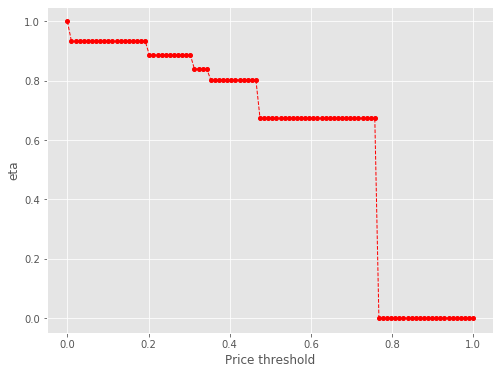

144 9
Number of cells with price above 50.0th percentile:  9


eta =  1.0
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.8868625347374333
eta =  0.8868625347374333
eta =  0.8868625347374333
eta =  0.8868625347374333
eta =  0.8868625347374333
eta =  0.8868625347374333
eta =  0.8868625347374333
eta =  0.8868625347374333
eta =  0.8868625347374333
eta =  0.8868625347374333
eta =  0.8868625347374333
eta =  0.839628007074048
eta =  0.839628007074048
eta =  0.839628007074048
eta =  0.839628007074048
eta =  0.802777004032492
eta =  0.802777004032492
eta =  0.802777004032492
eta =  0.802777004032492
eta =  0.

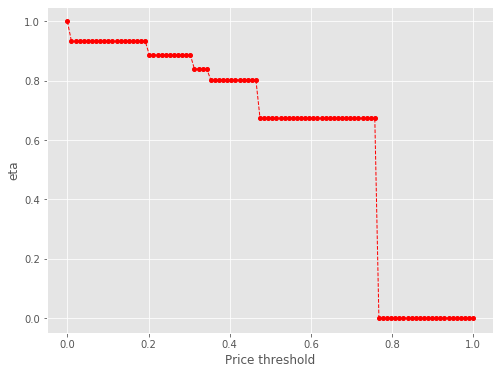

144 9
Number of cells with price above 51.0th percentile:  9


eta =  1.0
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.9330622154194386
eta =  0.8868625347374333
eta =  0.8868625347374333
eta =  0.8868625347374333
eta =  0.8868625347374333
eta =  0.8868625347374333
eta =  0.8868625347374333
eta =  0.8868625347374333
eta =  0.8868625347374333
eta =  0.8868625347374333
eta =  0.8868625347374333
eta =  0.8868625347374333
eta =  0.839628007074048
eta =  0.839628007074048
eta =  0.839628007074048
eta =  0.839628007074048
eta =  0.802777004032492
eta =  0.802777004032492
eta =  0.802777004032492
eta =  0.802777004032492
eta =  0.

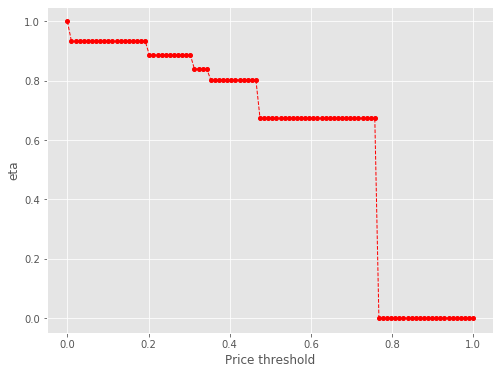

144 8
Number of cells with price above 52.0th percentile:  8


eta =  1.0
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.89986283143682
eta =  0.89986283143682
eta =  0.89986283143682
eta =  0.89986283143682
eta =  0.89986283143682
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.7218495630533903
eta =  0.7218495630530226
eta =  0.7218495630530226
eta =  0.7218495630530226
eta =  0.72

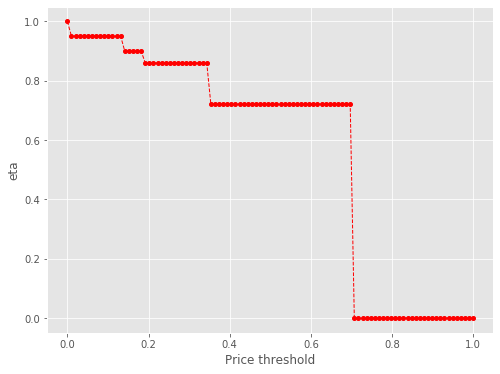

144 8
Number of cells with price above 53.0th percentile:  8


eta =  1.0
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.89986283143682
eta =  0.89986283143682
eta =  0.89986283143682
eta =  0.89986283143682
eta =  0.89986283143682
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.7218495630533903
eta =  0.7218495630530226
eta =  0.7218495630530226
eta =  0.7218495630530226
eta =  0.72

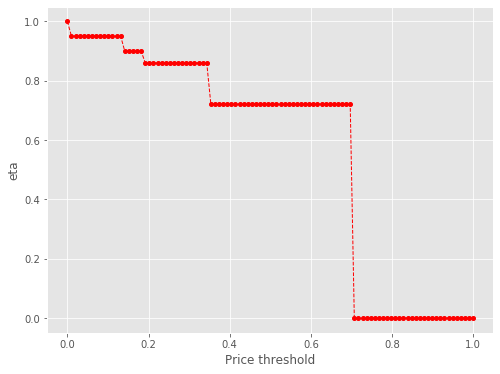

144 8
Number of cells with price above 54.0th percentile:  8


eta =  1.0
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.89986283143682
eta =  0.89986283143682
eta =  0.89986283143682
eta =  0.89986283143682
eta =  0.89986283143682
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.7218495630533903
eta =  0.7218495630530226
eta =  0.7218495630530226
eta =  0.7218495630530226
eta =  0.72

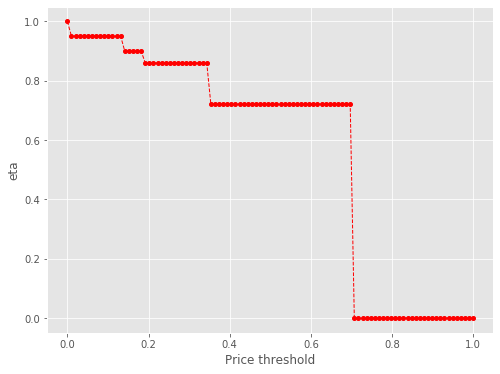

144 8
Number of cells with price above 55.00000000000001th percentile:  8


eta =  1.0
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.89986283143682
eta =  0.89986283143682
eta =  0.89986283143682
eta =  0.89986283143682
eta =  0.89986283143682
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.7218495630533903
eta =  0.7218495630530226
eta =  0.7218495630530226
eta =  0.7218495630530226
eta =  0.72

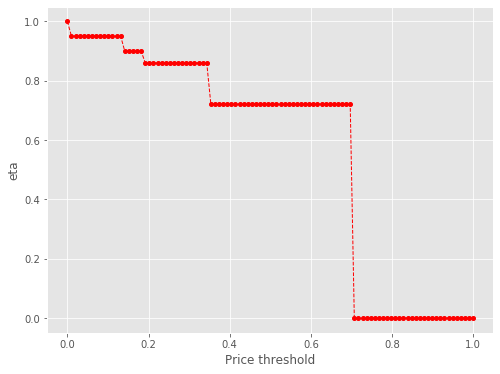

144 8
Number of cells with price above 56.00000000000001th percentile:  8


eta =  1.0
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.89986283143682
eta =  0.89986283143682
eta =  0.89986283143682
eta =  0.89986283143682
eta =  0.89986283143682
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.7218495630533903
eta =  0.7218495630530226
eta =  0.7218495630530226
eta =  0.7218495630530226
eta =  0.72

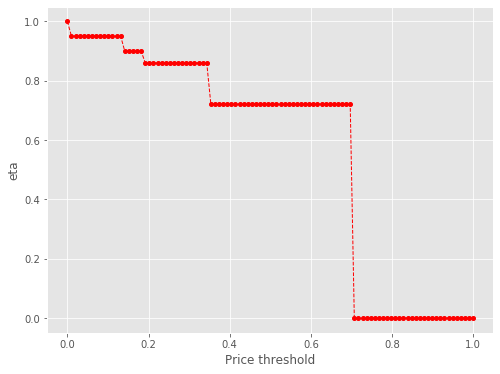

144 8
Number of cells with price above 57.00000000000001th percentile:  8


eta =  1.0
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.89986283143682
eta =  0.89986283143682
eta =  0.89986283143682
eta =  0.89986283143682
eta =  0.89986283143682
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.7218495630533903
eta =  0.7218495630530226
eta =  0.7218495630530226
eta =  0.7218495630530226
eta =  0.72

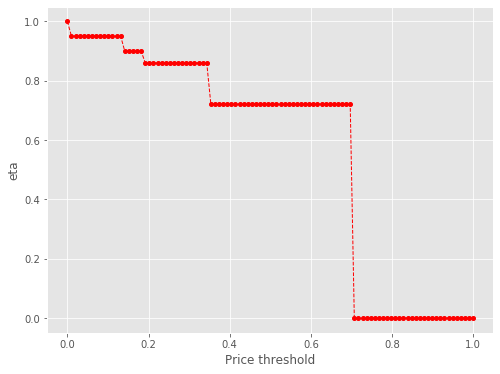

144 8
Number of cells with price above 58.00000000000001th percentile:  8


eta =  1.0
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.89986283143682
eta =  0.89986283143682
eta =  0.89986283143682
eta =  0.89986283143682
eta =  0.89986283143682
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.7218495630533903
eta =  0.7218495630530226
eta =  0.7218495630530226
eta =  0.7218495630530226
eta =  0.72

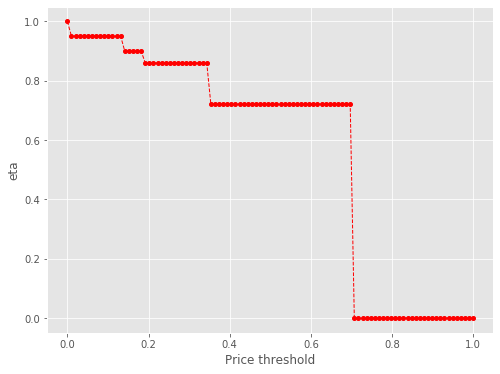

144 8
Number of cells with price above 59.0th percentile:  8


eta =  1.0
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.89986283143682
eta =  0.89986283143682
eta =  0.89986283143682
eta =  0.89986283143682
eta =  0.89986283143682
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.7218495630533903
eta =  0.7218495630530226
eta =  0.7218495630530226
eta =  0.7218495630530226
eta =  0.72

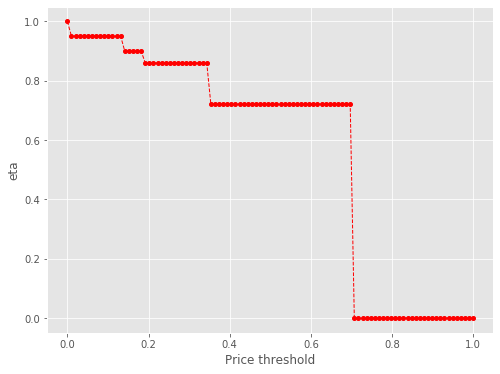

144 8
Number of cells with price above 60.0th percentile:  8


eta =  1.0
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.89986283143682
eta =  0.89986283143682
eta =  0.89986283143682
eta =  0.89986283143682
eta =  0.89986283143682
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.7218495630533903
eta =  0.7218495630530226
eta =  0.7218495630530226
eta =  0.7218495630530226
eta =  0.72

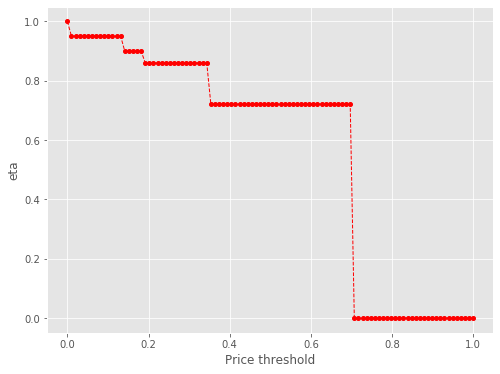

144 8
Number of cells with price above 61.0th percentile:  8


eta =  1.0
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.9504859591155588
eta =  0.89986283143682
eta =  0.89986283143682
eta =  0.89986283143682
eta =  0.89986283143682
eta =  0.89986283143682
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.8603681413373067
eta =  0.7218495630533903
eta =  0.7218495630530226
eta =  0.7218495630530226
eta =  0.7218495630530226
eta =  0.72

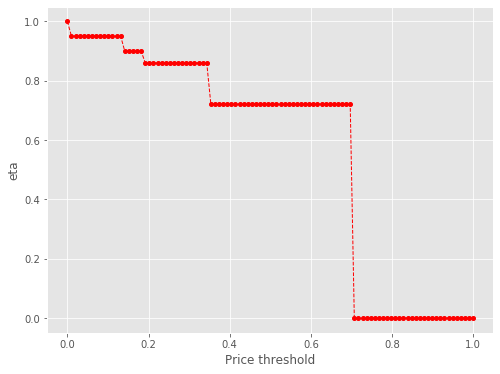

144 7
Number of cells with price above 62.0th percentile:  7


eta =  1.0
eta =  0.946739741715023
eta =  0.946739741715023
eta =  0.946739741715023
eta =  0.946739741715023
eta =  0.946739741715023
eta =  0.946739741715023
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.7594531577563565
eta =  0.7594531577563565
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  

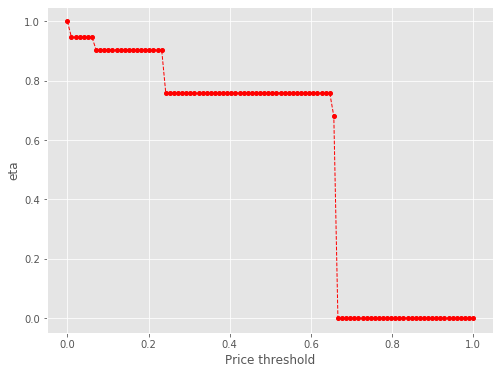

144 7
Number of cells with price above 63.0th percentile:  7


eta =  1.0
eta =  0.946739741715023
eta =  0.946739741715023
eta =  0.946739741715023
eta =  0.946739741715023
eta =  0.946739741715023
eta =  0.946739741715023
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.7594531577563565
eta =  0.7594531577563565
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  

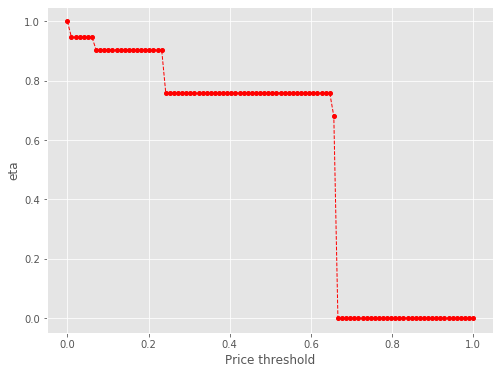

144 7
Number of cells with price above 64.0th percentile:  7


eta =  1.0
eta =  0.946739741715023
eta =  0.946739741715023
eta =  0.946739741715023
eta =  0.946739741715023
eta =  0.946739741715023
eta =  0.946739741715023
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.7594531577563565
eta =  0.7594531577563565
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  

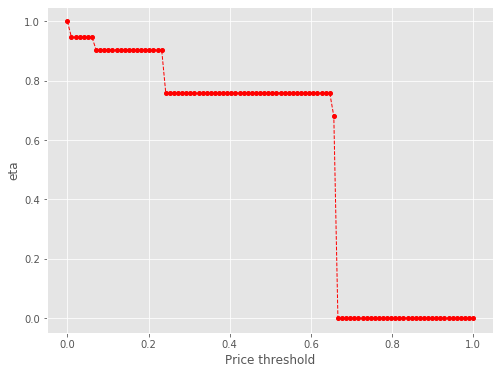

144 7
Number of cells with price above 65.0th percentile:  7


eta =  1.0
eta =  0.946739741715023
eta =  0.946739741715023
eta =  0.946739741715023
eta =  0.946739741715023
eta =  0.946739741715023
eta =  0.946739741715023
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.7594531577563565
eta =  0.7594531577563565
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  

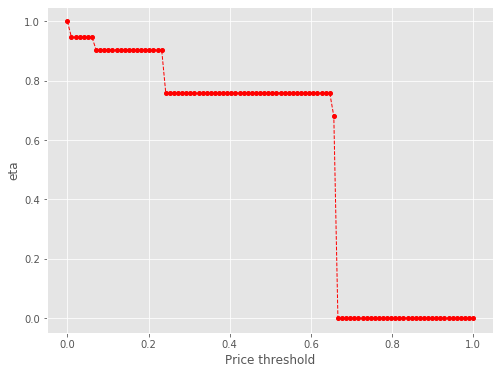

144 7
Number of cells with price above 66.0th percentile:  7


eta =  1.0
eta =  0.946739741715023
eta =  0.946739741715023
eta =  0.946739741715023
eta =  0.946739741715023
eta =  0.946739741715023
eta =  0.946739741715023
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.9051876391082009
eta =  0.7594531577563565
eta =  0.7594531577563565
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  0.7594531577559697
eta =  

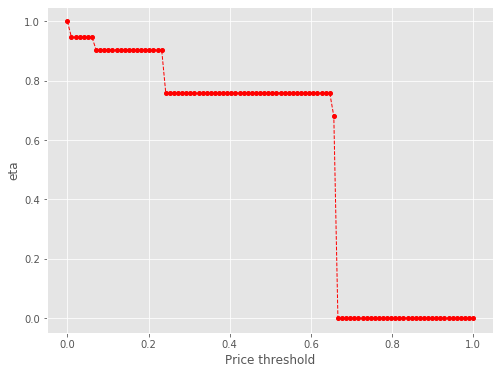

144 6
Number of cells with price above 67.0th percentile:  6


eta =  1.0
eta =  0.9561103217959878
eta =  0.9561103217959878
eta =  0.9561103217959878
eta =  0.9561103217959878
eta =  0.9561103217959878
eta =  0.9561103217959878
eta =  0.9561103217959878
eta =  0.9561103217959878
eta =  0.9561103217959878
eta =  0.9561103217959878
eta =  0.9561103217959878
eta =  0.9561103217959878
eta =  0.9561103217959878
eta =  0.9561103217959878
eta =  0.9561103217959878
eta =  0.9561103217959878
eta =  0.9561103217959878
eta =  0.9561103217959878
eta =  0.802177329516773
eta =  0.802177329516773
eta =  0.8021773295163644
eta =  0.8021773295163644
eta =  0.8021773295163644
eta =  0.8021773295163644
eta =  0.8021773295163644
eta =  0.8021773295163644
eta =  0.8021773295163644
eta =  0.8021773295163644
eta =  0.8021773295163644
eta =  0.8021773295163644
eta =  0.8021773295163644
eta =  0.8021773295163644
eta =  0.8021773295163644
eta =  0.8021773295163644
eta =  0.8021773295163644
eta =  0.8021773295163644
eta =  0.8021773295163644
eta =  0.8021773295163644
eta

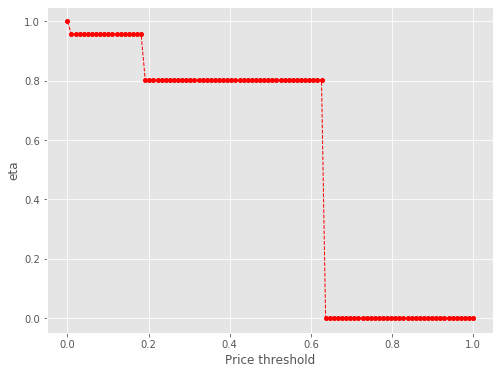

144 6
Number of cells with price above 68.0th percentile:  6


eta =  1.0
eta =  0.9561103217959878
eta =  0.9561103217959878
eta =  0.9561103217959878
eta =  0.9561103217959878
eta =  0.9561103217959878
eta =  0.9561103217959878
eta =  0.9561103217959878
eta =  0.9561103217959878
eta =  0.9561103217959878
eta =  0.9561103217959878
eta =  0.9561103217959878
eta =  0.9561103217959878
eta =  0.9561103217959878
eta =  0.9561103217959878
eta =  0.9561103217959878
eta =  0.9561103217959878
eta =  0.9561103217959878
eta =  0.9561103217959878
eta =  0.802177329516773
eta =  0.802177329516773
eta =  0.8021773295163644
eta =  0.8021773295163644
eta =  0.8021773295163644
eta =  0.8021773295163644
eta =  0.8021773295163644
eta =  0.8021773295163644
eta =  0.8021773295163644
eta =  0.8021773295163644
eta =  0.8021773295163644
eta =  0.8021773295163644
eta =  0.8021773295163644
eta =  0.8021773295163644
eta =  0.8021773295163644
eta =  0.8021773295163644
eta =  0.8021773295163644
eta =  0.8021773295163644
eta =  0.8021773295163644
eta =  0.8021773295163644
eta

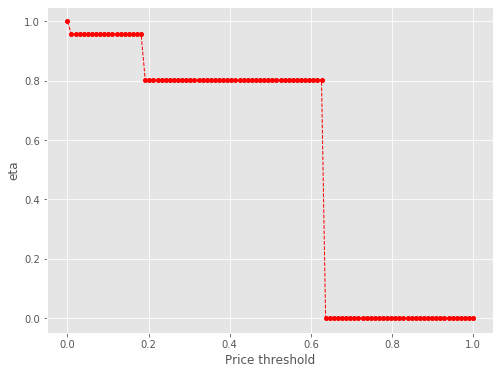

144 5
Number of cells with price above 69.0th percentile:  5


eta =  1.0
eta =  0.8390008048547555
eta =  0.8390008048547555
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
e

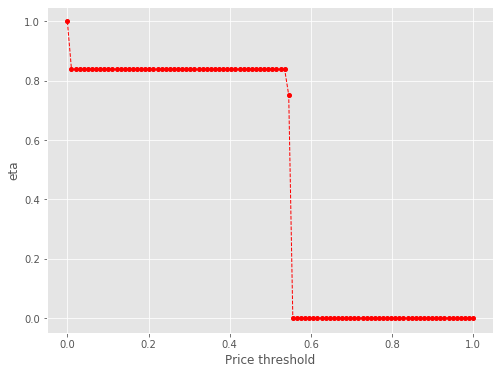

144 5
Number of cells with price above 70.0th percentile:  5


eta =  1.0
eta =  0.8390008048547555
eta =  0.8390008048547555
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
e

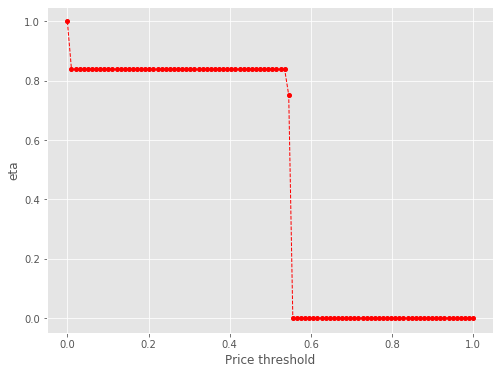

144 5
Number of cells with price above 71.00000000000001th percentile:  5


eta =  1.0
eta =  0.8390008048547555
eta =  0.8390008048547555
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
e

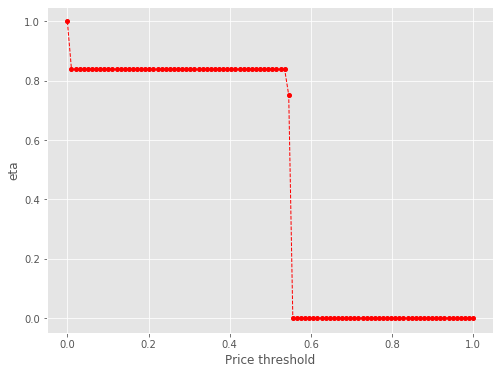

144 5
Number of cells with price above 72.0th percentile:  5


eta =  1.0
eta =  0.8390008048547555
eta =  0.8390008048547555
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
e

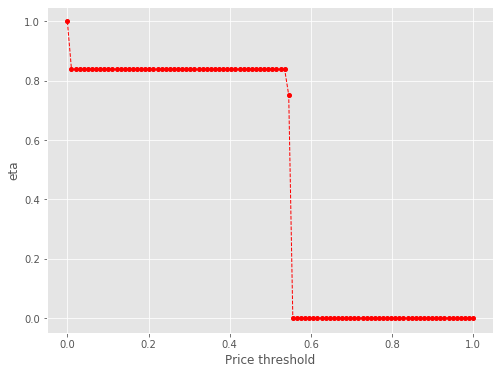

144 5
Number of cells with price above 73.0th percentile:  5


eta =  1.0
eta =  0.8390008048547555
eta =  0.8390008048547555
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
e

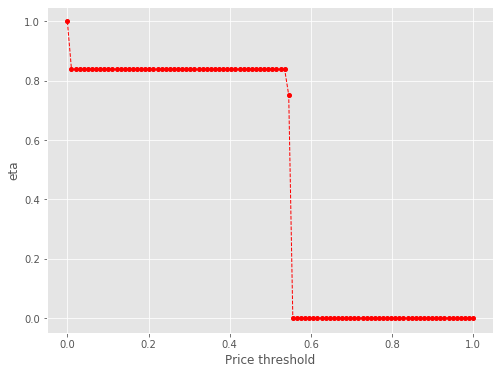

144 5
Number of cells with price above 74.0th percentile:  5


eta =  1.0
eta =  0.8390008048547555
eta =  0.8390008048547555
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
eta =  0.8390008048543282
e

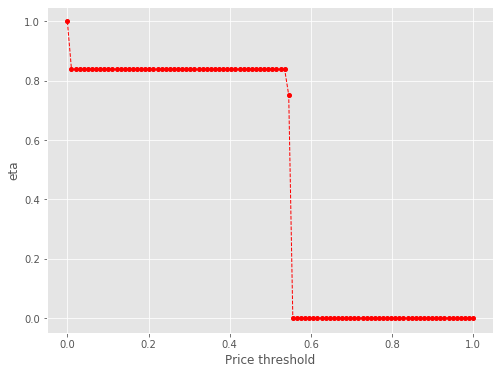

144 4
Number of cells with price above 75.0th percentile:  4


eta =  1.0
eta =  0.9999999999994906
eta =  0.9999999999994906
eta =  0.9999999999994906
eta =  0.9999999999994906
eta =  0.9999999999994906
eta =  0.9999999999994906
eta =  0.9999999999994906
eta =  0.9999999999994906
eta =  0.9999999999994906
eta =  0.9999999999994906
eta =  0.9999999999994906
eta =  0.9999999999994906
eta =  0.9999999999994906
eta =  0.9999999999994906
eta =  0.9999999999994906
eta =  0.9999999999994906
eta =  0.9999999999994906
eta =  0.9999999999994906
eta =  0.9999999999994906
eta =  0.9999999999994906
eta =  0.9999999999994906
eta =  0.9999999999994906
eta =  0.9999999999994906
eta =  0.9999999999994906
eta =  0.9999999999994906
eta =  0.9999999999994906
eta =  0.9999999999994906
eta =  0.9999999999994906
eta =  0.9999999999994906
eta =  0.9999999999994906
eta =  0.9999999999994906
eta =  0.9999999999994906
eta =  0.9999999999994906
eta =  0.9999999999994906
eta =  0.9999999999994906
eta =  0.9999999999994906
eta =  0.9999999999994906
eta =  0.9999999999994906
e

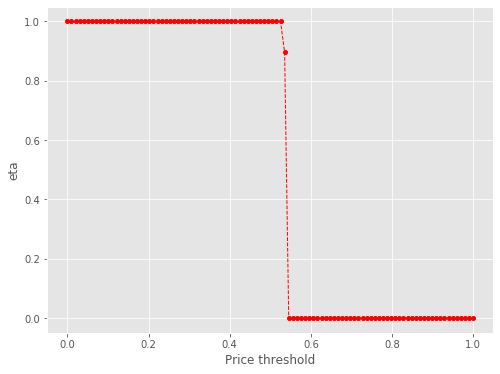

144 3
Number of cells with price above 76.0th percentile:  3


eta =  1.0
eta =  0.8959889573713793
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta = 

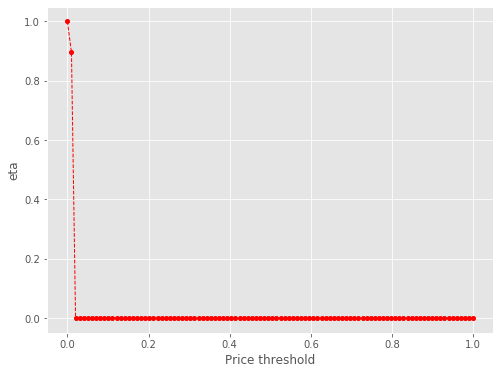

144 3
Number of cells with price above 77.0th percentile:  3


eta =  1.0
eta =  0.8959889573713793
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta = 

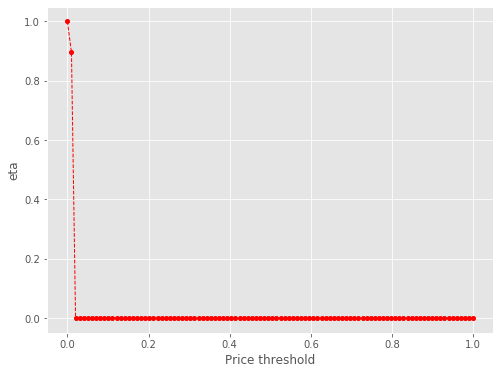

144 3
Number of cells with price above 78.0th percentile:  3


eta =  1.0
eta =  0.8959889573713793
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta = 

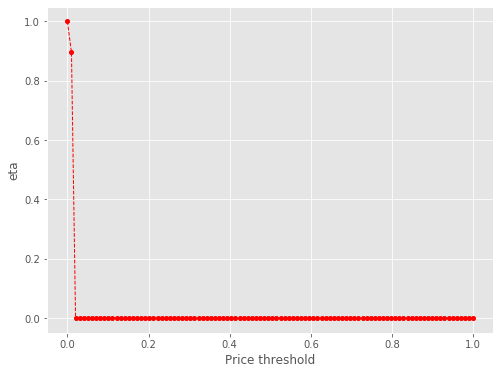

144 3
Number of cells with price above 79.0th percentile:  3


eta =  1.0
eta =  0.8959889573713793
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta = 

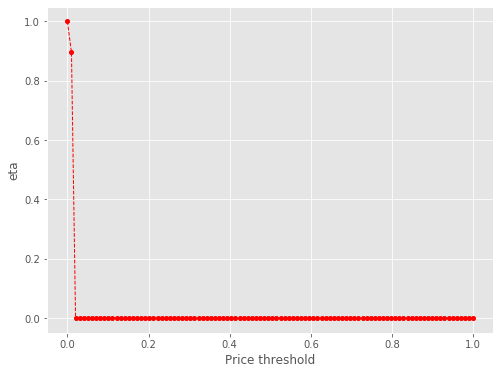

144 3
Number of cells with price above 80.0th percentile:  3


eta =  1.0
eta =  0.8959889573713793
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta = 

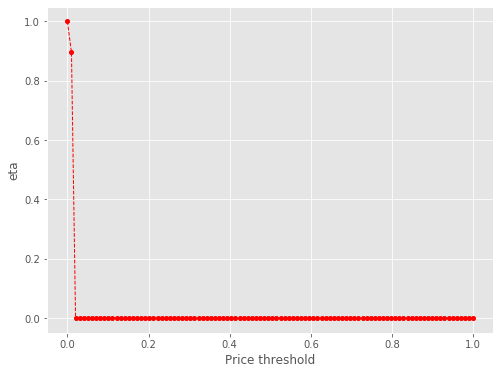

144 3
Number of cells with price above 81.0th percentile:  3


eta =  1.0
eta =  0.8959889573713793
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta = 

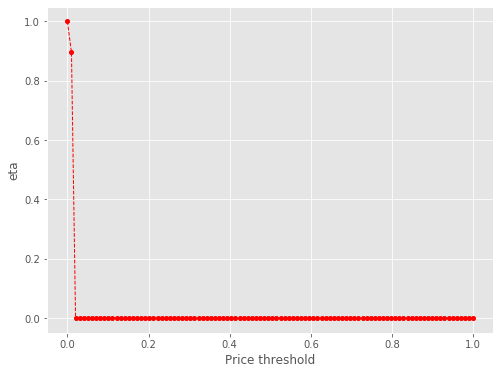

144 3
Number of cells with price above 82.0th percentile:  3


eta =  1.0
eta =  0.8959889573713793
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta = 

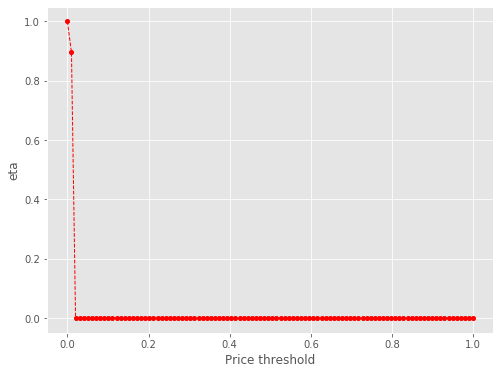

144 3
Number of cells with price above 83.0th percentile:  3


eta =  1.0
eta =  0.8959889573713793
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta = 

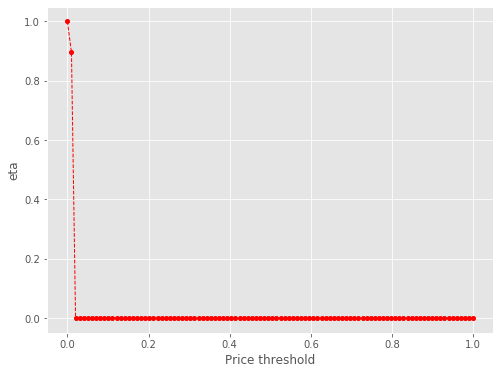

144 3
Number of cells with price above 84.00000000000001th percentile:  3


eta =  1.0
eta =  0.8959889573713793
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta = 

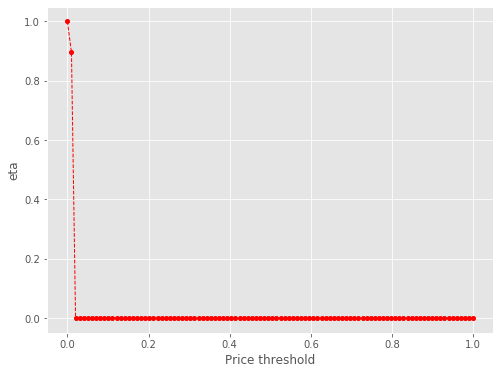

144 3
Number of cells with price above 85.0th percentile:  3


eta =  1.0
eta =  0.8959889573713793
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta = 

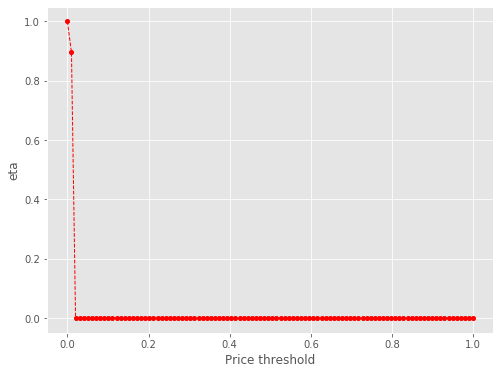

144 3
Number of cells with price above 86.0th percentile:  3


eta =  1.0
eta =  0.8959889573713793
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta = 

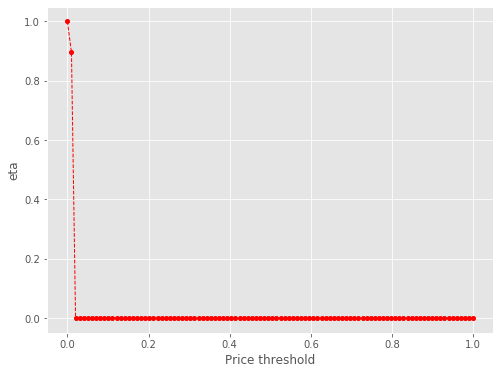

144 3
Number of cells with price above 87.0th percentile:  3


eta =  1.0
eta =  0.8959889573713793
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta = 

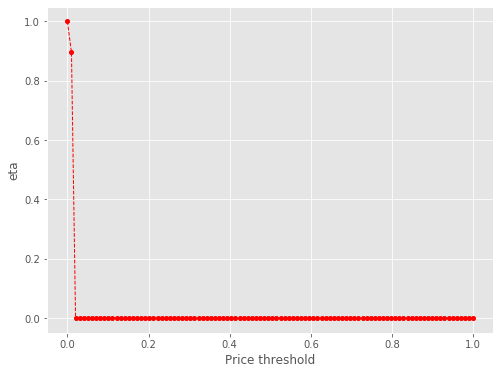

144 3
Number of cells with price above 88.0th percentile:  3


eta =  1.0
eta =  0.8959889573713793
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta = 

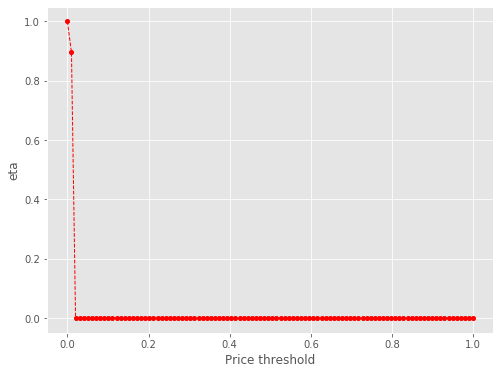

144 1
Number of cells with price above 89.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning:

invalid value encountered in true_divide



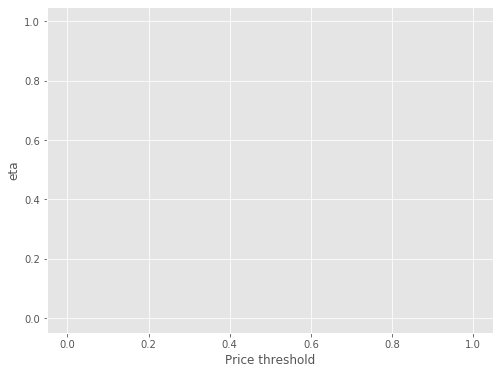

144 1
Number of cells with price above 90.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

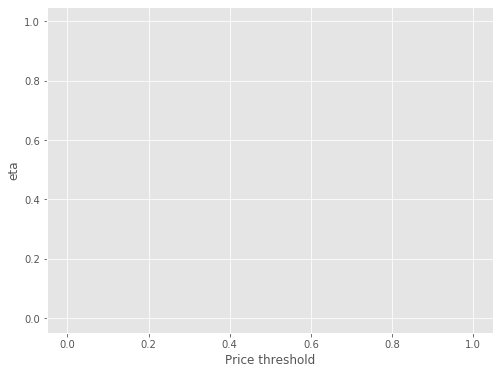

144 1
Number of cells with price above 91.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

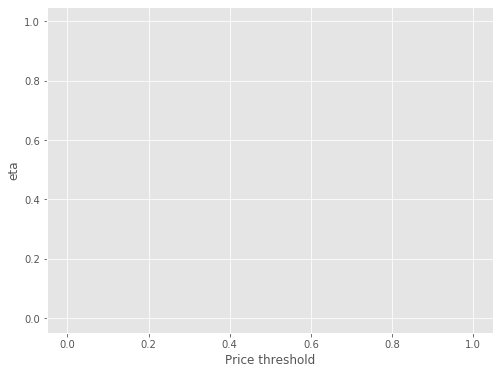

144 1
Number of cells with price above 92.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

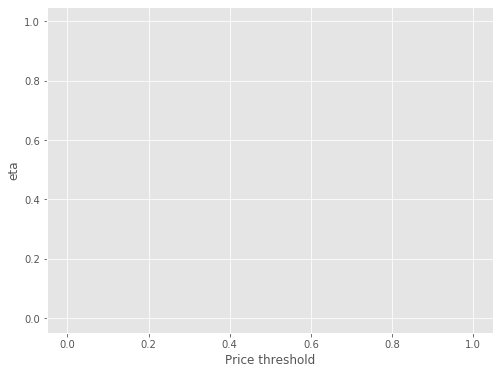

144 1
Number of cells with price above 93.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

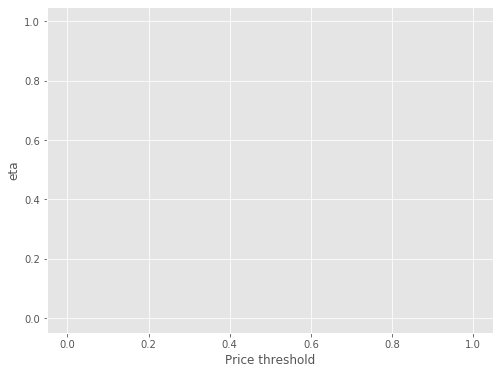

144 1
Number of cells with price above 94.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

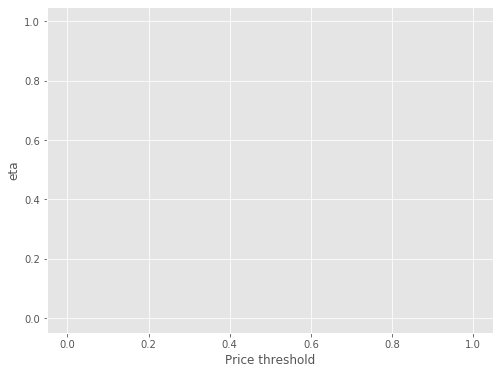

144 1
Number of cells with price above 95.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

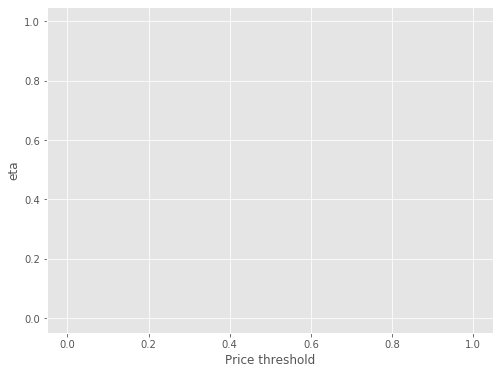

144 1
Number of cells with price above 96.00000000000001th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

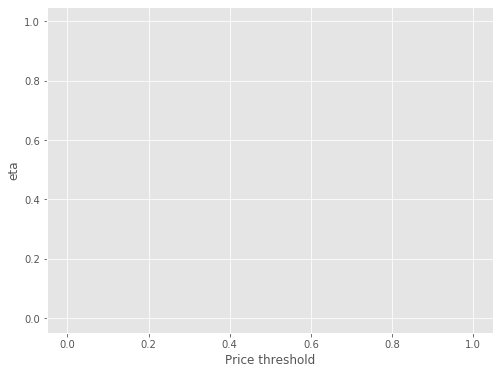

144 1
Number of cells with price above 97.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

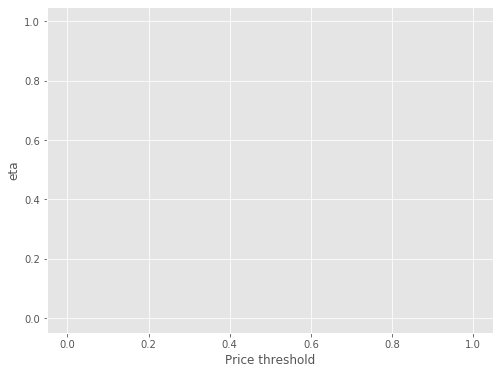

144 1
Number of cells with price above 98.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

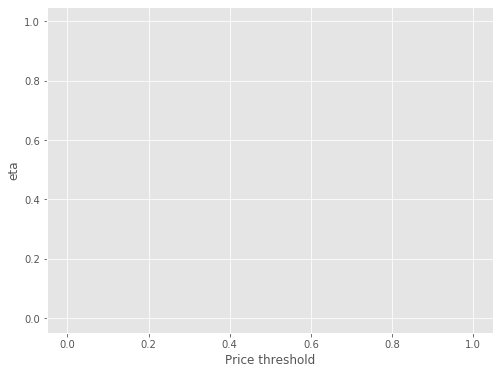

144 1
Number of cells with price above 99.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

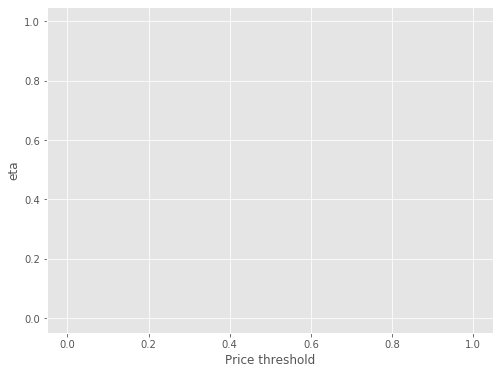

144 1
Number of cells with price above 100.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

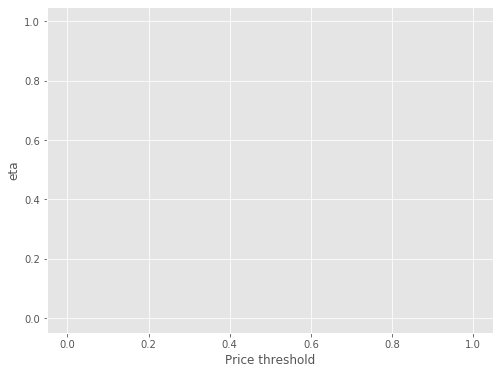


time: 1min 25s


In [27]:
lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
#keys = np.array(keys)
keys_initial = np.array(keys)


perc_vals = np.linspace(0.01, 1, 100)
etas_2d = []
for i in tqdm_notebook(perc_vals):
    keys = keys_initial
    vals_cut = vals[vals>=i*vals.max()]
    print(len(vals), len(vals_cut))

    L = np.cumsum(vals_cut)/np.sum(vals_cut)
    keys = keys[vals>=i*vals.max()]
    print('Number of cells with price above {}th percentile: '.format(i*100), len(keys))
    etas = []
    lval = np.linspace(min(vals_cut), max(vals_cut), 100)
    for k in tqdm_notebook(lval):
        loubar_keys = keys[vals_cut>=k]
        dist_mat = mat[keys.reshape(-1,1), keys]

        total_dist = dist_mat.sum()
        dist_corr = dist_mat[dist_mat>0]

        loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

        loubar_dist = loubar_dist_mat.sum()

        loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
        eta = loubar_dist_corr.mean()/dist_corr.mean()
        etas.append(eta)
        print('eta = ', eta)
    etas_array = np.array(etas)
    etas_array = np.where(np.isnan(etas_array), 0, etas_array)
    lval = (lval - lval.min())/(lval - lval.min()).max()
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(lval, etas_array, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
    plt.xlabel("Price threshold")
    plt.ylabel("eta")
    plt.show()
    etas_2d.append(etas)
etas_2d = np.array(etas_2d)
etas_2d = np.where(np.isnan(etas_2d), 0, etas_2d)
lval = lval/lval.max()

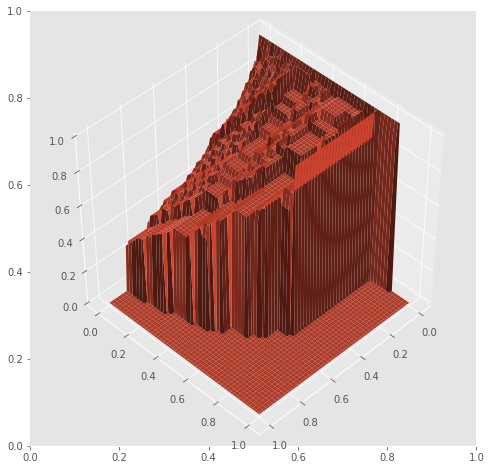

time: 1.47 s


In [28]:
X,Y = np.meshgrid(np.linspace(0,1, 100),np.linspace(0,1, 100))
etas_surface = etas_2d
fig, ax = plt.subplots(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
# Plot a 3D surface
ax.plot_surface(X, Y, etas_surface)
ax.view_init(45, 45)
plt.show()

In [29]:
pickle_in = open("etas_surface_dict.pickle","rb")
etas_surface_dict = pickle.load(pickle_in)
#etas_surface_dict = {}
etas_surface_dict['Arezzo'] = etas_surface


pickle_out = open("etas_surface_dict.pickle","wb")
pickle.dump(etas_surface_dict, pickle_out)
pickle_out.close()

etas_surface_dict

{'NY': array([[1.        , 0.40697941, 0.38848337, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.95418349, 0.92471336, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.96911482, 0.94572765, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 'Boston': array([[1.        , 0.49308111, 0.46754658, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.94621367, 0.92299712, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.97340556, 0.95206791, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.       

time: 19 ms


144 45
Number of cells with price above 5th percentile:  45
total number of cells:  144
number of cells within urban airbnb territory:  45



Mean travel times in minutes:  6.042318306878308


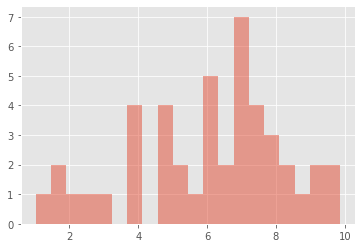

time: 1.72 s


In [30]:
from tqdm import tqdm_notebook

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys = np.array(keys)

vals_cut = vals[vals>0.05*vals.max()]
print(len(vals), len(vals_cut))

L = np.cumsum(vals_cut)/np.sum(vals_cut)
keys = keys[vals>0.05*vals.max()]
print('Number of cells with price above 5th percentile: ', len(keys))

print('total number of cells: ', len(polylist))

times_names = ['times_{}'.format(c) for c in range(1, len(centers)+1)]
times_dict = {name:[] for name in times_names}

plist = poly_prices[poly_prices.index.isin(keys)].geometry.tolist()
print('number of cells within urban airbnb territory: ', len(plist))
for poly in tqdm_notebook(plist):
    origin = ox.get_nearest_node(G, poly.centroid.coords[0][::-1])
    dists_to_centers = []
    for node, target in centers.items():
        try:
            if origin!=target:
                path = nx.shortest_path(G, origin, target, weight='length')
                edges = [ tuple( path[i:i+2] ) for i in range( len(path) - 1 ) ]
                dist = np.sum([G.get_edge_data(*edge)[0]['length'] for edge in edges])
                dists_to_centers.append(dist)
        except:
            pass
    if len(dists_to_centers) != 0:
        dists_to_centers = sorted(dists_to_centers)
        #print('distance list length equal to # of centers: ', len(dists_to_centers)==len(centers))
        if len(dists_to_centers)==len(centers):
            for n, dist in enumerate(dists_to_centers):
                time = (dist/3.5)/60
                times_dict['times_{}'.format(n+1)].append(time)
                #print(times_dict['times_{}'.format(n+1)][-1])
        else:
            print('Distance list length NOT equal to # of centers')

#print(distances_dict)
for center in range(1, len(centers)+1):
    print("Mean travel times in minutes: ", np.mean(times_dict['times_{}'.format(center)]))
for center in range(1, len(centers)+1):
    plt.hist(times_dict['times_{}'.format(center)], bins=20, alpha=0.5)
plt.show()

Mean travel times in minutes:  6.042318306878308


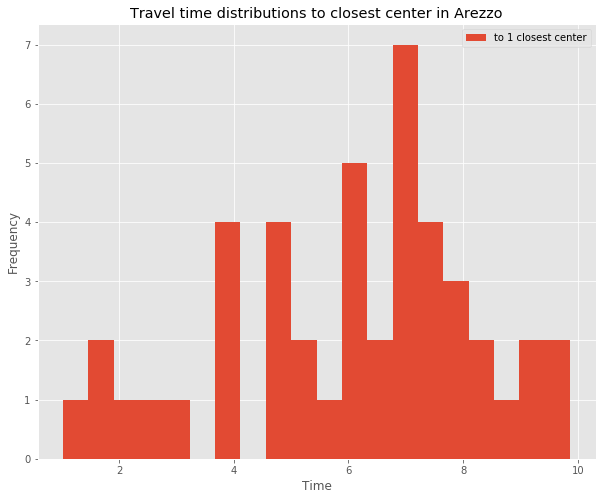

time: 339 ms


In [31]:
for center in range(1, len(centers)+1):
    times_dict['times_{}'.format(center)] = np.array(times_dict['times_{}'.format(center)])
    
for center in range(1, len(centers)+1):
    print("Mean travel times in minutes: ", np.mean(times_dict['times_{}'.format(center)]))

fig, ax = plt.subplots(figsize=(10,8))
for center in range(1, len(centers)+1):
    plt.hist(times_dict['times_{}'.format(center)], bins=20, alpha=1, label='to {} closest center'.format(center))
plt.title('Travel time distributions to closest center in Arezzo')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [32]:
pickle_in = open("City_Accessibility.pickle","rb")
access_dict = pickle.load(pickle_in)
#access_dict = {}
access_dict['Arezzo'] = times_dict


pickle_out = open("City_Accessibility.pickle","wb")
pickle.dump(access_dict, pickle_out)
pickle_out.close()

access_dict

{'Paris': {'times_1': array([ 4.73219737,  4.40047807,  7.81577632,  7.07926754,  6.7129386 ,
          7.48037281, 10.85755263,  8.41227193, 14.20045614, 15.15502193,
         16.00692982, 15.80582895, 14.35941228, 14.10681579, 12.26687281,
         13.89203947, 14.31310965, 15.99389474, 16.77728947, 17.82112281,
         20.19769737, 20.40849561, 21.93033333, 22.03087719, 20.6584386 ,
         20.62538596, 19.53197368, 20.61141228, 21.70609211, 23.22407018,
         21.70395614, 23.12607456, 22.79396053, 23.95434211, 21.49400439,
         21.55605702, 22.35374123, 22.36948246, 22.44162719, 21.54410965,
         21.93589912, 21.86757456, 21.86757456, 21.41060088, 21.92571491,
         22.93862281, 23.57200877, 25.13889474, 24.49192982, 26.04400877,
         26.815     , 38.90660088, 38.56507018, 37.89241228, 36.57546491,
         29.87379386, 27.54254825, 25.54755702, 26.98263158, 25.76562281,
         25.03485526, 25.37799123, 25.69687719, 26.07382018, 23.81846491,
         24.034649

time: 718 ms


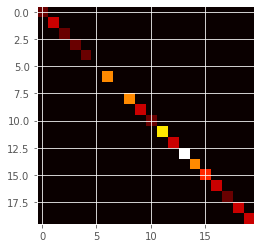

time: 221 ms


In [33]:
x = times_dict['times_{}'.format(1)]
#y = times_dict['times_{}'.format(2)]
#c_xy = np.histogram2d(x, y, 20)[0]
c_xx = np.histogram2d(x, x, 20)[0]
plt.imshow(c_xx, cmap='hot', interpolation='nearest')
plt.show()

In [34]:
from sklearn.metrics import mutual_info_score

def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

mi_list = []
for center in range(1, len(centers)+1):
    mi_list.append(times_dict['times_{}'.format(center)])

mis = []
for pair in combinations_with_replacement(mi_list, 2):
    MI = calc_MI(pair[0], pair[1], 20)
    print(MI)
    mis.append(MI)
mis = np.array(mis)
avg_mi = np.mean(mis)
print('average mutual information = ', avg_mi)

2.697380357065429
average mutual information =  2.697380357065429
time: 11 ms


In [35]:
pickle_in = open("Time_distribution_mutual_information.pickle","rb")
MI_dict = pickle.load(pickle_in)
#MI_dict = {}
MI_dict['Arezzo'] = avg_mi


pickle_out = open("Time_distribution_mutual_information.pickle","wb")
pickle.dump(MI_dict, pickle_out)
pickle_out.close()

MI_dict

{'Beijing': 1.6170682943522052,
 'Florence': 2.0836399429599792,
 'Palermo': 1.8596013030930105,
 'Los_Angeles': 1.5602500680599918,
 'Moscow': 1.5631970905638934,
 'Porto': 1.6277816420571996,
 'Prague': 2.176480497902222,
 'Reykjavik': 1.3730161847793374,
 'Riga': 2.240374487910287,
 'Rome': 1.6095563575725969,
 'Seoul': 1.2910685865906735,
 'Siena': 2.7660068415344448,
 'Sydney': 1.2791891753795948,
 'Tallin': 2.3884073435187867,
 'Treviso': 2.631909071373147,
 'Valencia': 2.1872520197930965,
 'Venezia': 2.719891808939249,
 'Verona': 2.7080241467515376,
 'Vicenza': 2.6192607829416756,
 'Vienna': 1.4481542925032476,
 'Wellington': 2.1855226822614866,
 'Zurich': 2.462051055806955,
 'Aarhus': 2.2910468431831847,
 'Milan': 1.6107461389394335,
 'Busan': 1.903641833377143,
 'Barcelona': 1.6449937230537024,
 'Bologna': 2.7317991260148045,
 'Bremen': 1.9447717965210316,
 'Brno': 2.4300669174144036,
 'Budapest': 2.219525897631017,
 'Dublin': 1.830502368836079,
 'Boston': 1.1451275682586615,


time: 7.98 ms
